In [ ]:
# Import necessary librarie
import pandas as pd
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import pickle
import ast



# VirusTotal

In [ ]:
# Loading Virustotal scanning results into pandas
vt_pd = pd.read_csv("https://raw.githubusercontent.com/lyvd/patd-results/refs/heads/main/results-csv/vt.csv")
vt_pd.head()

,Package,Dataset,#AVs,ALYac,APEX,AVG,Acronis,AhnLab-V3,Alibaba,Antiy-AVL,...,VirIT,Webroot,Xcitium,Yandex,Zillya,ZoneAlarm,Zoner,alibabacloud,huorong,tehtris
0,add-position-99.10.9.tgz,dataset1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,call-with-safe-iteration-closing-99.10.13.tgz,dataset1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,eslint-config-eslint-5.0.2.tgz,dataset1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ethers-4-99.10.9.tgz,dataset1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,plugin-proposal-decorators-99.10.9.tgz,dataset1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
# Number of packages
vt_package_counts = vt_pd.groupby('Dataset')['Package'].nunique()
vt_package_counts

,Package
Dataset,
dataset1,30
dataset2,30
dataset3,30
dataset4,30
dataset5,10
upstream-repos,1855
wolfi-apks,1862


## Performance of VirusTotal (VT) on the source code and apk datasets

In [ ]:
# Label the packages based on the dataset
def label_package(row):
    if row['Dataset'] in ['dataset1', 'dataset2', 'dataset3', 'dataset4', 'dataset5']:
        return 'malicious'
    elif row['Dataset'] in ['wolfi-apks', 'upstream-repos']:
        return 'benign'
    else:
        return 'unknown'

vt_pd['Label'] = vt_pd.apply(label_package, axis=1)

In [ ]:
def calculate_metrics_vt(df):
    # Ensure necessary columns exist
    if 'Label' not in df.columns or '#AVs' not in df.columns:
        raise ValueError("DataFrame must contain 'Label' and '#AVs' columns.")

    # Convert labels to binary values (1 for 'malicious', 0 otherwise)
    y_true = (df['Label'] == 'malicious').astype(int)
    y_scores = df['#AVs']

    # Create thresholds from 0 to max predicted value
    thresholds = np.linspace(0, y_scores.max(), 100)

    tpr_values = []
    fpr_values = []

    # Calculate TPR and FPR for each threshold
    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)  # Predictions based on threshold
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        # Calculate TPR and FPR
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

        tpr_values.append(tpr)
        fpr_values.append(fpr)

    # Calculate AUC using the list of FPR and TPR values
    AUC = auc(fpr_values, tpr_values)

    # Calculate metrics at threshold = 1 (specific threshold)
    specific_threshold = 1
    y_pred_specific = (y_scores >= specific_threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_specific).ravel()

    # Calculate TPR, FPR, TNR, FNR for threshold = 1
    TPR_specific = tp / (tp + fn) if (tp + fn) > 0 else 0
    FPR_specific = fp / (fp + tn) if (fp + tn) > 0 else 0
    TNR_specific = tn / (tn + fp) if (tn + fp) > 0 else 0
    FNR_specific = fn / (fn + tp) if (fn + tp) > 0 else 0

    # Calculate precision, recall, and F1 score at threshold = 1
    precision = (tp) / (tp + fp) if (tp + fp) > 0 else 0
    recall = (tp) / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Create the DataFrame with the desired metrics
    metrics_df = pd.DataFrame({
        'TP': [tp],
        'FP': [fp],
        'TN': [tn],
        'FN': [fn],
        'True Positive Rate (TPR)': [round(TPR_specific, 2)],
        'False Positive Rate (FPR)': [round(FPR_specific, 2)],
        'True Negative Rate (TNR)': [round(TNR_specific, 2)],
        'False Negative Rate (FNR)': [round(FNR_specific, 2)],
        'Precision': [round(precision, 2)],
        'Recall': [round(recall, 2)],
        'F1 Score': [round(f1, 2)],
        'AUC': [round(AUC, 3)]
    })

    return metrics_df




In [ ]:
# dataset1,4 and upstream-repos
calculate_metrics_vt(vt_pd[vt_pd['Dataset'].isin(["dataset1", "dataset4", "upstream-repos"])])



,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,43,59,1796,17,0.72,0.03,0.97,0.28,0.42,0.72,0.53,0.849


In [ ]:
# dataset1 and upstream-repos
calculate_metrics_vt(vt_pd[vt_pd['Dataset'].isin(["dataset1", "upstream-repos"])])


,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,22,59,1796,8,0.73,0.03,0.97,0.27,0.27,0.73,0.4,0.859


In [ ]:
# dataset1 and upstream-repos
calculate_metrics_vt(vt_pd[vt_pd['Dataset'].isin(["dataset4", "upstream-repos"])])


,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,21,59,1796,9,0.7,0.03,0.97,0.3,0.26,0.7,0.38,0.838


In [ ]:
# datset2, 3, 5 and wolfi apks
calculate_metrics_vt(vt_pd[vt_pd['Dataset'].isin(["dataset2", "dataset3", "dataset5", "wolfi-apks"])])


,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,37,13,1849,33,0.53,0.01,0.99,0.47,0.74,0.53,0.62,0.762


In [ ]:
# datset2 and wolfi apks
calculate_metrics_vt(vt_pd[vt_pd['Dataset'].isin(["dataset2", "wolfi-apks"])])


,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,22,13,1849,8,0.73,0.01,0.99,0.27,0.63,0.73,0.68,0.864


In [ ]:
# dataset3 and wolfi apks
calculate_metrics_vt(vt_pd[vt_pd['Dataset'].isin(["dataset3", "wolfi-apks"])])


,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,9,13,1849,21,0.3,0.01,0.99,0.7,0.41,0.3,0.35,0.647


In [ ]:
#datset5 and apks upstream-repos
calculate_metrics_vt(vt_pd[vt_pd['Dataset'].isin(["dataset5", "wolfi-apks"])])


,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,6,13,1849,4,0.6,0.01,0.99,0.4,0.32,0.6,0.41,0.798


In [ ]:
vt_pd.head()

,Package,Dataset,#AVs,ALYac,APEX,AVG,Acronis,AhnLab-V3,Alibaba,Antiy-AVL,...,Webroot,Xcitium,Yandex,Zillya,ZoneAlarm,Zoner,alibabacloud,huorong,tehtris,Label
0,add-position-99.10.9.tgz,dataset1,2,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,malicious
1,call-with-safe-iteration-closing-99.10.13.tgz,dataset1,2,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,malicious
2,eslint-config-eslint-5.0.2.tgz,dataset1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,malicious
3,ethers-4-99.10.9.tgz,dataset1,2,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,malicious
4,plugin-proposal-decorators-99.10.9.tgz,dataset1,2,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,malicious


### Plot scatter number of alert and number of samples

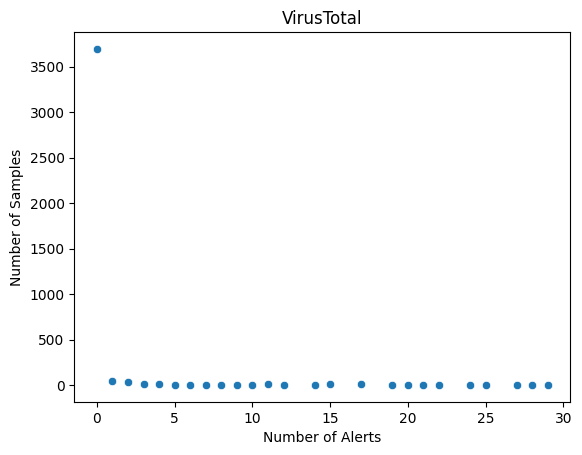

In [ ]:
#Total package
alert_counts = vt_pd.groupby('#AVs')['Package'].count().reset_index()
alert_counts.columns = ['#AV', 'Number of Samples']

# Plot the scatter plot
sns.scatterplot(data=alert_counts, x='#AV', y='Number of Samples')
plt.xlabel('Number of Alerts')
plt.ylabel('Number of Samples')
plt.title('VirusTotal')
#save to pdf
plt.savefig('vt_scatter.pdf')

plt.show()


## ClamAV

In [ ]:
# Filter for only ClamAV security vendor on VirusTotal
vt_clamAv_pd = vt_pd[['Package',	'Dataset', 'ClamAV']]

In [ ]:
vt_clamAv_pd['Label'] = vt_clamAv_pd.apply(label_package, axis=1)

<ipython-input-16-4764d2cbc2fe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vt_clamAv_pd['Label'] = vt_clamAv_pd.apply(label_package, axis=1)


In [ ]:
vt_clamAv_pd.head()

,Package,Dataset,ClamAV,Label
0,add-position-99.10.9.tgz,dataset1,0,malicious
1,call-with-safe-iteration-closing-99.10.13.tgz,dataset1,0,malicious
2,eslint-config-eslint-5.0.2.tgz,dataset1,0,malicious
3,ethers-4-99.10.9.tgz,dataset1,0,malicious
4,plugin-proposal-decorators-99.10.9.tgz,dataset1,0,malicious


In [ ]:

def calculate_metrics_ClamAV(df):
    # Ensure necessary columns exist
    if 'Label' not in df.columns :
        raise ValueError("DataFrame must contain 'Label' ")

    # Convert labels to binary values (1 for 'malicious', 0 otherwise)
    y_true = (df['Label'] == 'malicious').astype(int)
    y_scores = df['ClamAV']

    # Create thresholds from 0 to max predicted value
    thresholds = np.linspace(0, y_scores.max(), 100)

    tpr_values = []
    fpr_values = []

    # Calculate TPR and FPR for each threshold
    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)  # Predictions based on threshold
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        # Calculate TPR and FPR
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

        tpr_values.append(tpr)
        fpr_values.append(fpr)

    # Calculate AUC using the list of FPR and TPR values
    AUC = auc(fpr_values, tpr_values)

    # Calculate metrics at threshold = 1 (specific threshold)
    specific_threshold = 1
    y_pred_specific = (y_scores >= specific_threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_specific).ravel()

    # Calculate TPR, FPR, TNR, FNR for threshold = 1
    TPR_specific = tp / (tp + fn) if (tp + fn) > 0 else 0
    FPR_specific = fp / (fp + tn) if (fp + tn) > 0 else 0
    TNR_specific = tn / (tn + fp) if (tn + fp) > 0 else 0
    FNR_specific = fn / (fn + tp) if (fn + tp) > 0 else 0

    # Calculate precision, recall, and F1 score at threshold = 1
    precision = (tp) / (tp + fp) if (tp + fp) > 0 else 0
    recall = (tp) / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Create the DataFrame with the desired metrics
    metrics_df = pd.DataFrame({
        'TP': [tp],
        'FP': [fp],
        'TN': [tn],
        'FN': [fn],
        'True Positive Rate (TPR)': [round(TPR_specific, 2)],
        'False Positive Rate (FPR)': [round(FPR_specific, 2)],
        'True Negative Rate (TNR)': [round(TNR_specific, 2)],
        'False Negative Rate (FNR)': [round(FNR_specific, 2)],
        'Precision': [round(precision, 2)],
        'Recall': [round(recall, 2)],
        'F1 Score': [round(f1, 2)],
        'AUC': [round(AUC, 3)]
    })

    return metrics_df




In [ ]:
#dataset1, dataset4 and upstream-repose
calculate_metrics_ClamAV(vt_clamAv_pd[vt_clamAv_pd['Dataset'].isin(["dataset1", "dataset4", "upstream-repos"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,1,0,1855,59,0.02,0.0,1.0,0.98,1.0,0.02,0.03,0.508


In [ ]:
#dataset1 and upstream-repose
calculate_metrics_ClamAV(vt_clamAv_pd[vt_clamAv_pd['Dataset'].isin(["dataset1", "upstream-repos"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,0,0,1855,30,0.0,0.0,1.0,1.0,0,0.0,0,0.0


In [ ]:
# Dataset4 and upstream-repose
calculate_metrics_ClamAV(vt_clamAv_pd[vt_clamAv_pd['Dataset'].isin(["dataset4", "upstream-repos"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,1,0,1855,29,0.03,0.0,1.0,0.97,1.0,0.03,0.06,0.517


In [ ]:
# Dataset 2,3,5 and wolfi-apks
calculate_metrics_ClamAV(vt_clamAv_pd[vt_clamAv_pd['Dataset'].isin(["dataset2", "dataset3", "dataset5", "wolfi-apks"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,1,1,1861,69,0.01,0.0,1.0,0.99,0.5,0.01,0.03,0.507


In [ ]:
# Dataset 2 and wolfi-apks
calculate_metrics_ClamAV(vt_clamAv_pd[vt_clamAv_pd['Dataset'].isin(["dataset2", "wolfi-apks"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,0,1,1861,30,0.0,0.0,1.0,1.0,0.0,0.0,0,0.5


In [ ]:
# Dataset3 and wolfi-apks
calculate_metrics_ClamAV(vt_clamAv_pd[vt_clamAv_pd['Dataset'].isin(["dataset3", "wolfi-apks"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,1,1,1861,29,0.03,0.0,1.0,0.97,0.5,0.03,0.06,0.516


In [ ]:
#Dataset5 and wolfi-apks
calculate_metrics_ClamAV(vt_clamAv_pd[vt_clamAv_pd['Dataset'].isin(["dataset5", "wolfi-apks"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,0,1,1861,10,0.0,0.0,1.0,1.0,0.0,0.0,0,0.5


In [ ]:
# Number
vt_pd[vt_pd['#AVs'] >= 1].groupby(["Dataset"])["#AVs"].nunique()

,#AVs
Dataset,
dataset1,6
dataset2,8
dataset3,7
dataset4,10
dataset5,4
upstream-repos,9
wolfi-apks,6


### Distribution of the number alerts in each dataset for VirusTotal

In [ ]:
#only get #AV > 1
vt_pd = vt_pd[vt_pd['#AVs'] >= 1]

In [ ]:
vt_alerts_distribution_df = vt_pd.groupby(['#AVs', 'Dataset']).size().unstack(fill_value=0)

<Figure size 2400x1200 with 0 Axes>

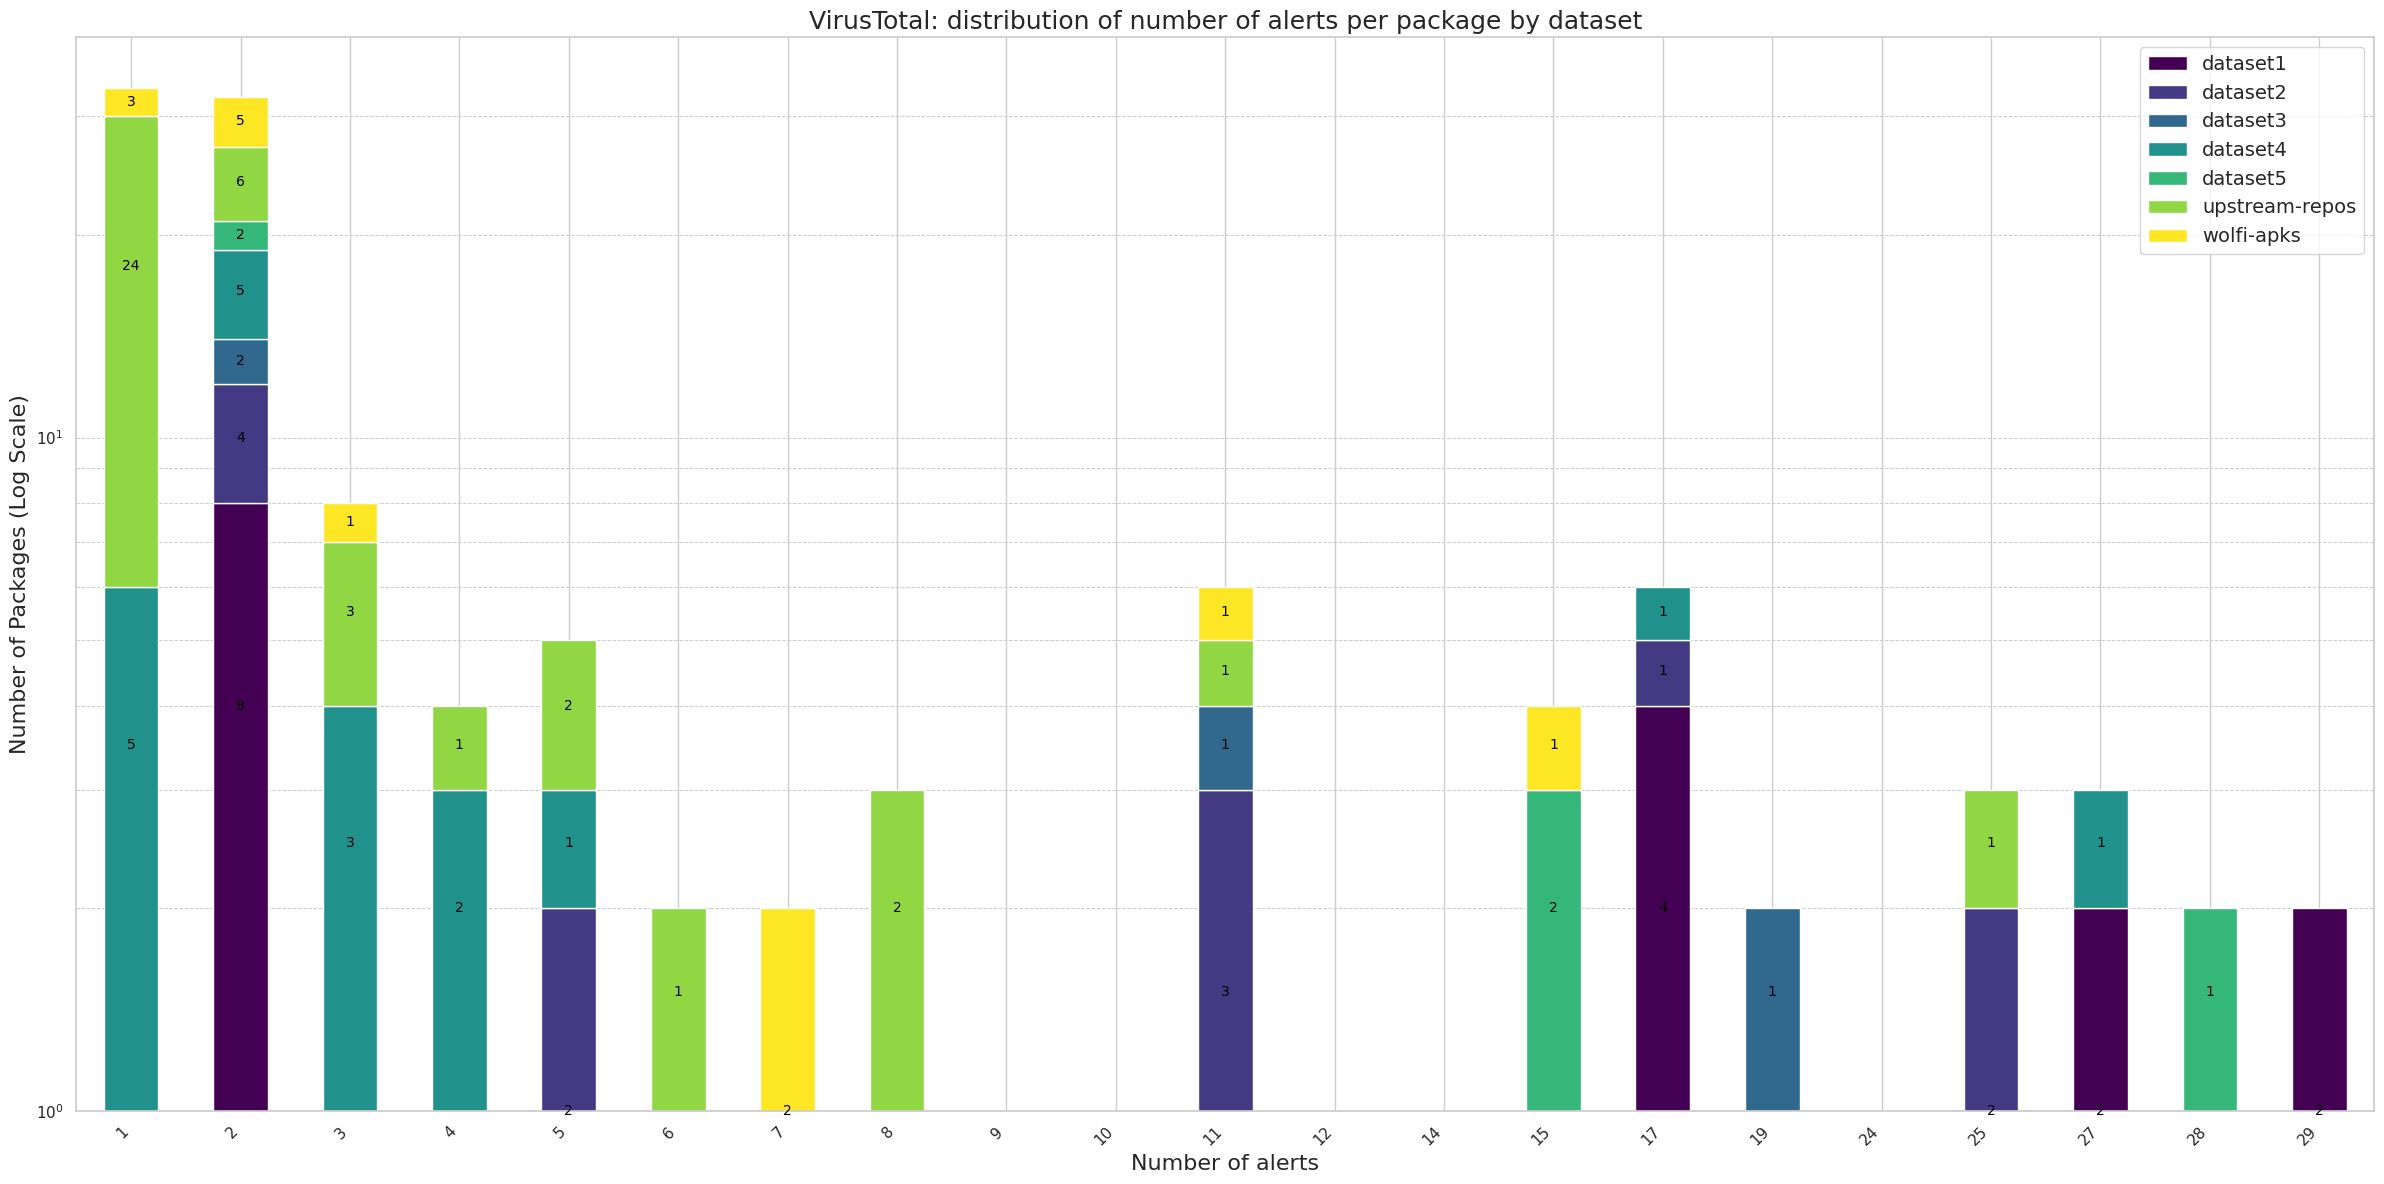

In [ ]:
# Set the style of the visualization
sns.set(style="whitegrid")

# Create the plot with wider dimensions and adjust the bar width
plt.figure(figsize=(24, 12))  # Increase width to give more space to columns
ax = vt_alerts_distribution_df.plot(kind='bar', stacked=True, colormap='viridis', figsize=(24, 12), width=0.5)  # Adjust bar width

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Reduce the number of x-axis ticks for clearer labels
ax.set_xticks(ax.get_xticks()[::1])  # Display every 1nd tick

# Set logarithmic scale for y-axis
plt.yscale('log')

# Set labels and title with larger font size
plt.xlabel('Number of alerts', fontsize=16)
plt.ylabel('Number of Packages (Log Scale)', fontsize=16)
plt.title('VirusTotal: distribution of number of alerts per package by dataset', fontsize=18)

# Add gridlines for y-axis for better readability
plt.grid(True, axis='y', which='both', linestyle='--', linewidth=0.7)

# Increase the font size of the legend
plt.legend(fontsize=14)  # Increase legend font size
# Add data labels
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only add labels for non-zero bars
        ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., p.get_y() + height / 2.),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 0),
                    textcoords='offset points')

# Adjust layout to avoid clipping
plt.tight_layout()
output_image_path = r'vt.png'
plt.savefig(output_image_path)


# Show the plot
plt.show()


## ROC curve for VirusTotal

In [ ]:
# Label the packages based on the dataset
def label_package(row):
    if row['Dataset'] in ['dataset1', 'dataset2', 'dataset3', 'dataset4', 'dataset5']:
        return 'malicious'
    elif row['Dataset'] in ['wolfi-apks', 'upstream-repos']:
        return 'benign'
    else:
        return 'unknown'

vt_pd['Label'] = vt_pd.apply(label_package, axis=1)

In [ ]:
vt_pd

,Package,Dataset,#AVs,ALYac,APEX,AVG,Acronis,AhnLab-V3,Alibaba,Antiy-AVL,...,Webroot,Xcitium,Yandex,Zillya,ZoneAlarm,Zoner,alibabacloud,huorong,tehtris,Label
0,add-position-99.10.9.tgz,dataset1,2,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,malicious
1,call-with-safe-iteration-closing-99.10.13.tgz,dataset1,2,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,malicious
2,eslint-config-eslint-5.0.2.tgz,dataset1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,malicious
3,ethers-4-99.10.9.tgz,dataset1,2,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,malicious
4,plugin-proposal-decorators-99.10.9.tgz,dataset1,2,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,malicious
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3842,zookeeper-3.9-3.9.3.1-r0.apk,wolfi-apks,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,benign
3843,zot-2.1.1-r3.apk,wolfi-apks,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,benign
3844,zoxide-0.9.6-r0.apk,wolfi-apks,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,benign
3845,zsh-5.9-r4.apk,wolfi-apks,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,benign


In [ ]:
vt_pd['Label'] = vt_pd.apply(label_package, axis=1)
df = vt_pd.copy()

y_true = (df['Label'] == 'malicious').astype(int)
y_scores = df['#AVs']

# Create thresholds from 0 to max predicted value
thresholds_vt = np.linspace(0, y_scores.max(), 100)

tpr_list_vt = []
fpr_list_vt = []

# Calculate TPR and FPR for each threshold
for threshold in thresholds_vt:
    y_pred = (y_scores >= threshold).astype(int)  # Predictions based on threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate TPR and FPR
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

    tpr_list_vt.append(tpr)
    fpr_list_vt.append(fpr)

In [ ]:
# save thresholds_vt, tpr_list_vt, fpr_list_vt,
roc_df = pd.DataFrame({
    'threshold': thresholds_vt,
    'tpr': tpr_list_vt,
    'fpr': fpr_list_vt
})

# Save the DataFrame to a CSV file
roc_df.to_csv('roc_data_vt.csv', index=False)

In [ ]:
vt_auc = round(auc(fpr_list_vt, tpr_list_vt),3)

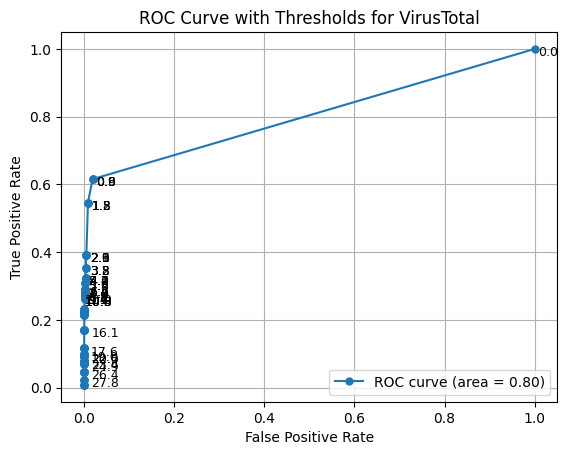

In [ ]:
# Plot ROC curve
plt.figure()
plt.plot(fpr_list_vt, tpr_list_vt, marker='o', markersize=5, label='ROC curve (area = {:.2f})'.format(auc(fpr_list_vt, tpr_list_vt)))

# Annotating the thresholds on the curve with better readability
for i, threshold in enumerate(thresholds_vt):
    if tpr_list_vt[i] > 0.25:  # Focus on the dense area
            plt.annotate(f'{threshold:.1f}', (fpr_list_vt[i], tpr_list_vt[i]),
                         textcoords="offset points", xytext=(10, -5),
                         ha='center', fontsize=9)
    elif  tpr_list_vt[i] < 0.2  and i % 5 == 0:  # Focus on the dense area
            plt.annotate(f'{threshold:.1f}', (fpr_list_vt[i], tpr_list_vt[i]),
                         textcoords="offset points", xytext=(15, -5),
                         ha='center', fontsize=9)




plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Thresholds for VirusTotal')
plt.legend(loc="lower right")
plt.grid(True)

# Save the plot as an image (e.g., PNG format)
plt.savefig('roc_curve_virus_total.png', dpi=300, bbox_inches='tight')  # Specify file name, dpi for resolution, and bbox for tight layout

# Show the plot
plt.show()


# Malcontent (bincapz)

In [ ]:
# Loading bincapz results
bincapz_pd = pd.read_csv("https://raw.githubusercontent.com/lyvd/patd-results/refs/heads/main/results-csv/bincapz.csv")
bincapz_pd.head()

,Package name,Dataset,File path,Risk level (high/critical)
0,add-position-99.10.9,dataset1,/tmp/add-position-99.10.9.tgz888927791/package...,CRITICAL
1,call-with-safe-iteration-closing-99.10.13,dataset1,/tmp/call-with-safe-iteration-closing-99.10.13...,CRITICAL
2,ethers-4-99.10.9,dataset1,/tmp/ethers-4-99.10.9.tgz3218630999/package/in...,CRITICAL
3,plugin-proposal-decorators-99.10.9,dataset1,/tmp/plugin-proposal-decorators-99.10.9.tgz975...,CRITICAL
4,spring-projects-6.0.2,dataset1,/tmp/spring-projects-6.0.2.tgz3262404390/packa...,HIGH


In [ ]:
# Number of packages per dataset
bincapz_pd.groupby(["Dataset"])["Package name"].nunique()

,Package name
Dataset,
dataset1,16
dataset2,20
dataset3,15
dataset4,21
dataset5,4
upstream-repos,934
wolfi-apks,376


In [ ]:
# Divide into source type: APKs and source code
bincapz_pd_apks = bincapz_pd[bincapz_pd['Dataset'].isin(["dataset2", "dataset3",  "dataset5", "wolfi-apks"])]
bincapz_pd_source_code = bincapz_pd[bincapz_pd['Dataset'].isin(["dataset1", "dataset4", "upstream-repos"])]

In [ ]:
bincapz_pd_apks.groupby(["Dataset"])["Package name"].nunique()

,Package name
Dataset,
dataset2,20
dataset3,15
dataset5,4
wolfi-apks,376


In [ ]:
bincapz_pd.groupby(["Dataset"])["Risk level (high/critical)"].value_counts()

Dataset         Risk level (high/critical)
dataset1        CRITICAL                          13
                HIGH                               3
dataset2        HIGH                              44
                CRITICAL                          16
dataset3        HIGH                             409
                CRITICAL                          26
dataset4        HIGH                              59
                CRITICAL                          14
dataset5        CRITICAL                           2
                HIGH                               2
upstream-repos  HIGH                          104717
                CRITICAL                        3759
wolfi-apks      HIGH                           15342
                CRITICAL                        3476
Name: count, dtype: int64

In [ ]:
bincapz_pd["Risk level (high/critical)"].value_counts()

,count
Risk level (high/critical),
HIGH,120576
CRITICAL,7306


In [ ]:
# caculate number of unique packages for each dataset
bincapz_pd.groupby(["Dataset"])["Package name"].nunique()

,Package name
Dataset,
dataset1,16
dataset2,20
dataset3,15
dataset4,21
dataset5,4
upstream-repos,934
wolfi-apks,376


## Performance of bincapz (malcontent) on the source code and apk datasets

In [ ]:
df_malicious_benign_bincapz = pd.read_csv("https://github.com/lyvd/patd-results/raw/refs/heads/master/results-csv-full/bincapz_full.csv")

In [ ]:
df_malicious_benign_bincapz

,Package name,Dataset,File path,Risk level (high/critical)
0,add-position-99.10.9,dataset1,/tmp/add-position-99.10.9.tgz888927791/package...,CRITICAL
1,call-with-safe-iteration-closing-99.10.13,dataset1,/tmp/call-with-safe-iteration-closing-99.10.13...,CRITICAL
2,eslint-config-eslint-5.0.2,dataset1,No file,No risk
3,ethers-4-99.10.9,dataset1,/tmp/ethers-4-99.10.9.tgz3218630999/package/in...,CRITICAL
4,plugin-proposal-decorators-99.10.9,dataset1,/tmp/plugin-proposal-decorators-99.10.9.tgz975...,CRITICAL
...,...,...,...,...
130343,zot-2.1.1-r3,wolfi-apks,/tmp/zot-2.1.1-r3.apk1852686240/usr/bin/zot,CRITICAL
130344,zoxide-0.9.6-r0,wolfi-apks,No file,No risk
130345,zsh-5.9-r4,wolfi-apks,/tmp/zsh-5.9-r4.apk597743517/bin/zsh,HIGH
130346,zsh-5.9-r4,wolfi-apks,/tmp/zsh-5.9-r4.apk597743517/usr/lib/zsh/5.9/z...,HIGH


In [ ]:
df_malicious_bincapz = pd.read_csv("https://raw.githubusercontent.com/lyvd/patd-results/refs/heads/main/results-csv/bincapz.csv")

In [ ]:
df_malicious_bincapz.groupby('Dataset')['Package name'].nunique()

,Package name
Dataset,
dataset1,16
dataset2,20
dataset3,15
dataset4,21
dataset5,4
upstream-repos,934
wolfi-apks,376


In [ ]:
df_malicious_benign_bincapz.groupby('Dataset')['Package name'].nunique()


,Package name
Dataset,
dataset1,30
dataset2,30
dataset3,30
dataset4,30
dataset5,10
upstream-repos,1856
wolfi-apks,1866


In [ ]:
df_benign_bincapz = df_malicious_benign_bincapz[~df_malicious_benign_bincapz['Risk level (high/critical)'].isin(['HIGH', 'CRITICAL'])]

In [ ]:
df_benign_bincapz.groupby('Dataset')['Package name'].nunique()

,Package name
Dataset,
dataset1,14
dataset2,10
dataset3,15
dataset4,9
dataset5,6
upstream-repos,922
wolfi-apks,1490


In [ ]:
# bincapz_pd_package_alerts_count = bincapz_pd.groupby(['Dataset', 'Package name'])['Risk level (high/critical)'].count().reset_index()
# bincapz_pd_package_alerts_count.columns = ['Dataset', 'Package name', 'Number of Alerts']


In [ ]:
# Count the number of alerts for each package
malicious_pd_bincapz = df_malicious_bincapz.groupby(['Dataset', 'Package name'])['Risk level (high/critical)'].count().reset_index()
malicious_pd_bincapz.columns = ['Dataset', 'Package name', 'Number of Alerts']

In [ ]:
malicious_pd_bincapz.head()

,Dataset,Package name,Number of Alerts
0,dataset1,add-position-99.10.9,1
1,dataset1,apple-py-music-1.0.tar,1
2,dataset1,call-with-safe-iteration-closing-99.10.13,1
3,dataset1,colorwin-6.6.8.tar,1
4,dataset1,colourize-0.8.1,1


In [ ]:
benign_pd_bincapz = df_benign_bincapz.groupby(['Dataset', 'Package name'])['Risk level (high/critical)'].count().reset_index()
benign_pd_bincapz.columns = ['Dataset', 'Package name', 'Number of Alerts']
benign_pd_bincapz['Number of Alerts'] = 0

In [ ]:
benign_pd_bincapz.head()

,Dataset,Package name,Number of Alerts
0,dataset1,aastra-xml_api-1.1.4,0
1,dataset1,abbyy_cloud-0.0.10,0
2,dataset1,activemerchant_clickandbuy-0.2.0,0
3,dataset1,aioconsol-1.0.tar,0
4,dataset1,atlas-client-0.0.2,0


In [ ]:
# Label the packages based on the dataset
def label_package(row):
    if row['Dataset'] in ['dataset1', 'dataset2', 'dataset3', 'dataset4', 'dataset5']:
        return 'malicious'
    elif row['Dataset'] in ['wolfi-apks', 'upstream-repos']:
        return 'benign'
    else:
        return 'unknown'

malicious_pd_bincapz['Label'] = malicious_pd_bincapz.apply(label_package, axis=1)
benign_pd_bincapz['Label'] = benign_pd_bincapz.apply(label_package, axis=1)

In [ ]:
malicious_benign_pd_bincapz = pd.concat([malicious_pd_bincapz, benign_pd_bincapz], ignore_index=True)

In [ ]:
malicious_benign_pd_bincapz.groupby('Dataset')['Package name'].nunique()

,Package name
Dataset,
dataset1,30
dataset2,30
dataset3,30
dataset4,30
dataset5,10
upstream-repos,1856
wolfi-apks,1866


In [ ]:
malicious_benign_pd_bincapz.head()

,Dataset,Package name,Number of Alerts,Label
0,dataset1,add-position-99.10.9,1,malicious
1,dataset1,apple-py-music-1.0.tar,1,malicious
2,dataset1,call-with-safe-iteration-closing-99.10.13,1,malicious
3,dataset1,colorwin-6.6.8.tar,1,malicious
4,dataset1,colourize-0.8.1,1,malicious


In [ ]:
def calculate_metrics_bincapz(df):
    # Ensure necessary columns exist
    if 'Label' not in df.columns or 'Number of Alerts' not in df.columns:
        raise ValueError("DataFrame must contain 'Label' and 'Number of Alerts' columns.")

    # Convert labels to binary values (1 for 'malicious', 0 otherwise)
    y_true = (df['Label'] == 'malicious').astype(int)
    y_scores = df['Number of Alerts']

    # Create thresholds from 0 to max predicted value
    thresholds = np.linspace(0, y_scores.max(), 100)

    tpr_values = []
    fpr_values = []

    # Calculate TPR and FPR for each threshold
    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)  # Predictions based on threshold
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        # Calculate TPR and FPR
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

        tpr_values.append(tpr)
        fpr_values.append(fpr)

    # Calculate AUC using the list of FPR and TPR values
    AUC = auc(fpr_values, tpr_values)

    # Calculate metrics at threshold = 1 (specific threshold)
    specific_threshold = 1
    y_pred_specific = (y_scores >= specific_threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_specific).ravel()

    # Calculate TPR, FPR, TNR, FNR for threshold = 1
    TPR_specific = tp / (tp + fn) if (tp + fn) > 0 else 0
    FPR_specific = fp / (fp + tn) if (fp + tn) > 0 else 0
    TNR_specific = tn / (tn + fp) if (tn + fp) > 0 else 0
    FNR_specific = fn / (fn + tp) if (fn + tp) > 0 else 0

    # Calculate precision, recall, and F1 score at threshold = 1
    precision = (tp) / (tp + fp) if (tp + fp) > 0 else 0
    recall = (tp) / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Create the DataFrame with the desired metrics
    metrics_df = pd.DataFrame({
        'TP': [tp],
        'FP': [fp],
        'TN': [tn],
        'FN': [fn],
        'True Positive Rate (TPR)': [round(TPR_specific, 2)],
        'False Positive Rate (FPR)': [round(FPR_specific, 2)],
        'True Negative Rate (TNR)': [round(TNR_specific, 2)],
        'False Negative Rate (FNR)': [round(FNR_specific, 2)],
        'Precision': [round(precision, 2)],
        'Recall': [round(recall, 2)],
        'F1 Score': [round(f1, 2)],
        'AUC': [round(AUC, 3)]
    })

    return metrics_df



In [ ]:
calculate_metrics_bincapz(malicious_benign_pd_bincapz[malicious_benign_pd_bincapz['Dataset'].isin(["dataset1", "dataset4", "upstream-repos"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,37,934,922,23,0.62,0.5,0.5,0.38,0.04,0.62,0.07,0.479


In [ ]:
#dataset1 and upstreamrepos
calculate_metrics_bincapz(malicious_benign_pd_bincapz[malicious_benign_pd_bincapz['Dataset'].isin(["dataset1", "upstream-repos"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,16,934,922,14,0.53,0.5,0.5,0.47,0.02,0.53,0.03,0.479


In [ ]:
#dataset4 and upstreamrepos
calculate_metrics_bincapz(malicious_benign_pd_bincapz[malicious_benign_pd_bincapz['Dataset'].isin(["dataset4", "upstream-repos"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,21,934,922,9,0.7,0.5,0.5,0.3,0.02,0.7,0.04,0.479


In [ ]:
#dataset2,3,5 and apks
calculate_metrics_bincapz(malicious_benign_pd_bincapz[malicious_benign_pd_bincapz['Dataset'].isin(["dataset2", "dataset3", "dataset5", "wolfi-apks"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,39,376,1490,31,0.56,0.2,0.8,0.44,0.09,0.56,0.16,0.503


In [ ]:
#dataset2 and apks
calculate_metrics_bincapz(malicious_benign_pd_bincapz[malicious_benign_pd_bincapz['Dataset'].isin(["dataset2", "wolfi-apks"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,20,376,1490,10,0.67,0.2,0.8,0.33,0.05,0.67,0.09,0.496


In [ ]:
#dataset3 and apks
calculate_metrics_bincapz(malicious_benign_pd_bincapz[malicious_benign_pd_bincapz['Dataset'].isin(["dataset3", "wolfi-apks"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,15,376,1490,15,0.5,0.2,0.8,0.5,0.04,0.5,0.07,0.513


In [ ]:
#dataset5 and apks
calculate_metrics_bincapz(malicious_benign_pd_bincapz[malicious_benign_pd_bincapz['Dataset'].isin(["dataset5", "wolfi-apks"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,4,376,1490,6,0.4,0.2,0.8,0.6,0.01,0.4,0.02,0.496


### Plot scatter number of alert and number of samples

In [ ]:
malicious_pd_bincapz.columns

Index(['Dataset', 'Package name', 'Number of Alerts', 'Label'], dtype='object')

In [ ]:
malicious_pd_bincapz
#find the package name havr higest number of alert
malicious_pd_bincapz[malicious_pd_bincapz['Number of Alerts'] == malicious_pd_bincapz['Number of Alerts'].max()]['Package name'].to_list()

['py3-azure-core', 'py3-azure-identity', 'py3-azure-storage-blob']

In [ ]:

package_names = ['py3-azure-core', 'py3-azure-identity', 'py3-azure-storage-blob']

# Filter the DataFrame for the specified packages
filtered_df = df_malicious_bincapz[df_malicious_bincapz['Package name'].isin(package_names)]

# Group by 'Package name' and 'Risk level (high/critical)' and count occurrences
risk_counts = filtered_df.groupby(['Package name', 'Risk level (high/critical)']).size().unstack(fill_value=0)

# Display the result
risk_counts

Risk level (high/critical),CRITICAL,HIGH
Package name,,
py3-azure-core,2,12955
py3-azure-identity,2,12955
py3-azure-storage-blob,2,12955


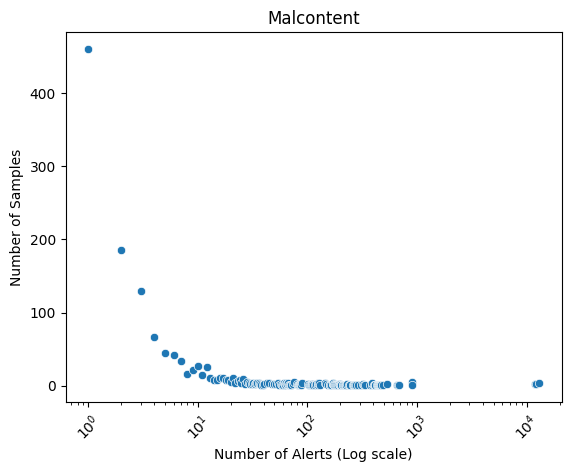

In [ ]:
alert_counts = malicious_pd_bincapz.groupby('Number of Alerts')['Package name'].count().reset_index()
alert_counts.columns = ['Number of Alerts', 'Number of Samples']


# Assuming alert_counts DataFrame has already been created
sns.scatterplot(data=alert_counts, x='Number of Alerts', y='Number of Samples')

# Make the x-axis logarithmic if it covers a large range of values
plt.xscale('log')



# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Labels and title
plt.xlabel('Number of Alerts (Log scale)')
plt.ylabel('Number of Samples')
plt.title('Malcontent')
#save to pdf
plt.savefig('malcontent_scatter.pdf', format='pdf', bbox_inches='tight')


# Show plot
plt.show()

##  malcontent APK analyses: sub-analyses for each programming language

### Java Script

In [ ]:
#read flagged JavaScript samples
df_malicious_binapz_js = pd.read_csv('https://github.com/lyvd/patd-results/raw/refs/heads/main/results-csv/bincapz_language/bincapz_js.csv')

In [ ]:
df_malicious_binapz_js.groupby('Dataset')['Package name'].nunique()

,Package name
Dataset,
dataset1,8
dataset2,9
dataset3,9
dataset4,8
upstream-repos,40
wolfi-apks,28


In [ ]:
# df_malicious_binapz_js = df_malicious_binapz_js.groupby(['Dataset', 'Package name']).filter(lambda x: x['File path'].str.contains('.js').any())

In [ ]:
#read full javascipt
df_malicious_benign_binapz_js = pd.read_csv("https://github.com/lyvd/patd-results/raw/refs/heads/master/results-csv-full/bincapz_full_js.csv")

In [ ]:
df_malicious_benign_binapz_js.groupby('Dataset')['Package name'].nunique()

,Package name
Dataset,
dataset1,10
dataset2,10
dataset3,10
dataset4,10
upstream-repos,88
wolfi-apks,129


In [ ]:
#group by Dataset, package name. get list of file path if there aren't any file .py in this list remove this package in this dataset
# df_malicious_binapz_js1 = df_malicious_binapz_js.groupby(['Dataset', 'Package name']).filter(lambda x: x['File path'].str.contains('.js').any())

In [ ]:
df_benign_bincapz_js = df_malicious_benign_binapz_js[~df_malicious_benign_binapz_js['Risk level (high/critical)'].isin(['HIGH', 'CRITICAL'])]

In [ ]:
df_benign_bincapz_js.groupby('Dataset')['Package name'].nunique()

,Package name
Dataset,
dataset1,2
dataset2,1
dataset3,1
dataset4,2
upstream-repos,48
wolfi-apks,101


In [ ]:
#remove any row if

In [ ]:
malicious_pd_bincapz_js = df_malicious_binapz_js.groupby(['Dataset', 'Package name'])['Risk level (high/critical)'].count().reset_index()
malicious_pd_bincapz_js.columns = ['Dataset', 'Package name', 'Number of Alerts']


In [ ]:
malicious_pd_bincapz_js.head()

,Dataset,Package name,Number of Alerts
0,dataset1,add-position-99.10.9,1
1,dataset1,call-with-safe-iteration-closing-99.10.13,1
2,dataset1,ethers-4-99.10.9,1
3,dataset1,plugin-proposal-decorators-99.10.9,1
4,dataset1,spring-projects-6.0.2,1


In [ ]:
benign_pd_bincapz_js = df_benign_bincapz_js.groupby(['Dataset', 'Package name'])['Risk level (high/critical)'].count().reset_index()
benign_pd_bincapz_js.columns = ['Dataset', 'Package name', 'Number of Alerts']
benign_pd_bincapz_js['Number of Alerts'] = 0

In [ ]:
#combine
malicious_benign_pd_bincapz_js = pd.concat([malicious_pd_bincapz_js, benign_pd_bincapz_js], ignore_index=True)

In [ ]:
malicious_benign_pd_bincapz_js.groupby('Dataset')['Package name'].nunique()

,Package name
Dataset,
dataset1,10
dataset2,10
dataset3,10
dataset4,10
upstream-repos,88
wolfi-apks,129


In [ ]:
malicious_benign_pd_bincapz_js['Label'] = malicious_benign_pd_bincapz_js.apply(label_package, axis=1)

In [ ]:
malicious_benign_pd_bincapz_js.head()

,Dataset,Package name,Number of Alerts,Label
0,dataset1,add-position-99.10.9,1,malicious
1,dataset1,call-with-safe-iteration-closing-99.10.13,1,malicious
2,dataset1,ethers-4-99.10.9,1,malicious
3,dataset1,plugin-proposal-decorators-99.10.9,1,malicious
4,dataset1,spring-projects-6.0.2,1,malicious


In [ ]:
#dataset2 and wolfi-apks
calculate_metrics_bincapz(malicious_benign_pd_bincapz_js[malicious_benign_pd_bincapz_js['Dataset'].isin(["dataset2", "wolfi-apks"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,9,28,101,1,0.9,0.22,0.78,0.1,0.24,0.9,0.38,0.446


In [ ]:
#dataset3 and wolfi-apks
calculate_metrics_bincapz(malicious_benign_pd_bincapz_js[malicious_benign_pd_bincapz_js['Dataset'].isin(["dataset3", "wolfi-apks"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,9,28,101,1,0.9,0.22,0.78,0.1,0.24,0.9,0.38,0.73


### Python

In [ ]:
df_malicious_bincapz_py = pd.read_csv('https://github.com/lyvd/patd-results/raw/refs/heads/main/results-csv/bincapz_language/bincapz_python.csv')

In [ ]:
# df_malicious_bincapz_py = df_malicious_bincapz_py.groupby(['Dataset', 'Package name']).filter(lambda x: x['File path'].str.contains('.py').any())


In [ ]:
df_malicious_bincapz_py.groupby('Dataset')['Package name'].nunique()

,Package name
Dataset,
dataset1,7
dataset2,7
dataset3,2
dataset4,9
upstream-repos,256
wolfi-apks,61


In [ ]:
df_malicious_benign_bincapz_py = pd.read_csv("https://github.com/lyvd/patd-results/raw/refs/heads/master/results-csv-full/bincapz_full_python.csv")

In [ ]:
df_malicious_benign_bincapz_py.groupby('Dataset')['Package name'].nunique()

,Package name
Dataset,
dataset1,10
dataset2,10
dataset3,10
dataset4,10
upstream-repos,557
wolfi-apks,729


In [ ]:
df_benign_bincapz_py = df_malicious_benign_bincapz_py[~df_malicious_benign_bincapz_py['Risk level (high/critical)'].isin(['HIGH', 'CRITICAL'])]

In [ ]:
df_benign_bincapz_py.groupby('Dataset')['Package name'].nunique()

,Package name
Dataset,
dataset1,3
dataset2,3
dataset3,8
dataset4,1
upstream-repos,301
wolfi-apks,668


In [ ]:
malicious_pd_bincapz_py = df_malicious_bincapz_py.groupby(['Dataset', 'Package name'])['Risk level (high/critical)'].count().reset_index()
malicious_pd_bincapz_py.columns = ['Dataset', 'Package name', 'Number of Alerts']

In [ ]:
benign_pd_bincapz_py = df_benign_bincapz_py.groupby(['Dataset', 'Package name'])['Risk level (high/critical)'].count().reset_index()
benign_pd_bincapz_py.columns = ['Dataset', 'Package name', 'Number of Alerts']
benign_pd_bincapz_py['Number of Alerts'] = 0

In [ ]:
#combine
malicious_benign_pd_bincapz_py = pd.concat([malicious_pd_bincapz_py, benign_pd_bincapz_py], ignore_index=True)

In [ ]:
malicious_benign_pd_bincapz_py.groupby('Dataset')['Package name'].nunique()

,Package name
Dataset,
dataset1,10
dataset2,10
dataset3,10
dataset4,10
upstream-repos,557
wolfi-apks,729


In [ ]:
malicious_benign_pd_bincapz_py['Label'] = malicious_benign_pd_bincapz_py.apply(label_package, axis=1)

In [ ]:
#dataset2 and wolfi-apks
calculate_metrics_bincapz(malicious_benign_pd_bincapz_py[malicious_benign_pd_bincapz_py['Dataset'].isin(["dataset2", "wolfi-apks"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,7,61,668,3,0.7,0.08,0.92,0.3,0.1,0.7,0.18,0.475


In [ ]:
#Dataset3 and wolfi-apks
calculate_metrics_bincapz(malicious_benign_pd_bincapz_py[malicious_benign_pd_bincapz_py['Dataset'].isin(["dataset3", "wolfi-apks"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,2,61,668,8,0.2,0.08,0.92,0.8,0.03,0.2,0.05,0.475


### Ruby

In [ ]:
df_malicious_bincapz_rb = pd.read_csv('https://github.com/lyvd/patd-results/raw/refs/heads/main/results-csv/bincapz_language/bincapz_ruby.csv')

In [ ]:
# df_malicious_bincapz_rb = df_malicious_bincapz_rb.groupby(['Dataset', 'Package name']).filter(lambda x: x['File path'].str.contains('.rb').any())

In [ ]:
df_malicious_bincapz_rb.groupby('Dataset')['Package name'].nunique()

,Package name
Dataset,
dataset1,1
dataset2,4
dataset3,4
dataset4,4
upstream-repos,31
wolfi-apks,20


In [ ]:
df_malicious_benign_bincapz_rb = pd.read_csv("https://github.com/lyvd/patd-results/raw/refs/heads/master/results-csv-full/bincapz_full_ruby.csv")

In [ ]:
df_benign_bincapz_rb = df_malicious_benign_bincapz_rb[~df_malicious_benign_bincapz_rb['Risk level (high/critical)'].isin(['HIGH', 'CRITICAL'])]


In [ ]:
df_benign_bincapz_rb.groupby('Dataset')['Package name'].nunique()

,Package name
Dataset,
dataset1,9
dataset2,6
dataset3,6
dataset4,6
upstream-repos,134
wolfi-apks,155


In [ ]:
malicious_pd_bincapz_rb = df_malicious_bincapz_rb.groupby(['Dataset', 'Package name'])['Risk level (high/critical)'].count().reset_index()
malicious_pd_bincapz_rb.columns = ['Dataset', 'Package name', 'Number of Alerts']
#

In [ ]:
benign_pd_bincapz_rb = df_benign_bincapz_rb.groupby(['Dataset', 'Package name'])['Risk level (high/critical)'].count().reset_index()
benign_pd_bincapz_rb.columns = ['Dataset', 'Package name', 'Number of Alerts']
benign_pd_bincapz_rb['Number of Alerts'] = 0
#

In [ ]:
#combine
malicious_benign_pd_bincapz_rb = pd.concat([malicious_pd_bincapz_rb, benign_pd_bincapz_rb], ignore_index=True)

In [ ]:
malicious_benign_pd_bincapz_rb.groupby('Dataset')['Package name'].nunique()

,Package name
Dataset,
dataset1,10
dataset2,10
dataset3,10
dataset4,10
upstream-repos,165
wolfi-apks,175


In [ ]:
malicious_benign_pd_bincapz_rb['Label'] = malicious_benign_pd_bincapz_rb.apply(label_package, axis=1)

In [ ]:
#dataset2 and wolfi-apks
calculate_metrics_bincapz(malicious_benign_pd_bincapz_rb[malicious_benign_pd_bincapz_rb['Dataset'].isin(["dataset2", "wolfi-apks"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,4,20,155,6,0.4,0.11,0.89,0.6,0.17,0.4,0.24,0.643


In [ ]:
#dataset3 and wolfi-apks
calculate_metrics_bincapz(malicious_benign_pd_bincapz_rb[malicious_benign_pd_bincapz_rb['Dataset'].isin(["dataset3", "wolfi-apks"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,4,20,155,6,0.4,0.11,0.89,0.6,0.17,0.4,0.24,0.64


### Dataset5 vs wolfi-apks

In [ ]:
df_malicious_bincapz_c = pd.read_csv('https://github.com/lyvd/patd-results/raw/refs/heads/main/results-csv/bincapz_language/bincapz_c.csv')

In [ ]:
df_malicious_bincapz_c.groupby('Dataset')['Package name'].nunique()

,Package name
Dataset,
dataset5,4
upstream-repos,150
wolfi-apks,10


In [ ]:
df_malicious_benign_bincapz_c = pd.read_csv('https://raw.githubusercontent.com/lyvd/patd-results/refs/heads/master/results-csv-full/bincapz_full_c.csv')

In [ ]:
df_malicious_benign_bincapz_c.groupby('Dataset')['Package name'].nunique()

,Package name
Dataset,
dataset5,10
upstream-repos,367
wolfi-apks,491


In [ ]:
df_benign_bincapz_c = df_malicious_benign_bincapz_c[~df_malicious_benign_bincapz_c['Risk level (high/critical)'].isin(['HIGH', 'CRITICAL'])]
df_benign_bincapz_c.groupby('Dataset')['Package name'].nunique()

,Package name
Dataset,
dataset5,6
upstream-repos,217
wolfi-apks,481


In [ ]:
malicious_pd_bincapz_c = df_malicious_bincapz_c.groupby(['Dataset', 'Package name'])['Risk level (high/critical)'].count().reset_index()
malicious_pd_bincapz_c.columns = ['Dataset', 'Package name', 'Number of Alerts']

In [ ]:
benign_pd_bincapz_c = df_benign_bincapz_c.groupby(['Dataset', 'Package name'])['Risk level (high/critical)'].count().reset_index()
benign_pd_bincapz_c.columns = ['Dataset', 'Package name', 'Number of Alerts']
benign_pd_bincapz_c['Number of Alerts'] = 0

In [ ]:
#combine
malicious_benign_pd_bincapz_c = pd.concat([malicious_pd_bincapz_c, benign_pd_bincapz_c], ignore_index=True)

In [ ]:
malicious_benign_pd_bincapz_c.groupby('Dataset')['Package name'].nunique()

,Package name
Dataset,
dataset5,10
upstream-repos,367
wolfi-apks,491


In [ ]:
# Label the packages based on the dataset
def label_package(row):
    if row['Dataset'] in ['dataset1', 'dataset2', 'dataset3', 'dataset4', 'dataset5']:
        return 'malicious'
    elif row['Dataset'] in ['wolfi-apks', 'upstream-repos']:
        return 'benign'
    else:
        return 'unknown'

In [ ]:
malicious_benign_pd_bincapz_c['Label'] = malicious_benign_pd_bincapz_c.apply(label_package, axis=1)

In [ ]:
malicious_benign_pd_bincapz_c

,Dataset,Package name,Number of Alerts,Label
0,dataset5,Backdoor.Linux.Rootin.b-4.5.1-r0,1,malicious
1,dataset5,KAAL_BHAIRAV-4.5.1-r0,1,malicious
2,dataset5,RedMenshenBPFDoor-4.5.1-r0,1,malicious
3,dataset5,mig-logcleaner-resurrected-4.5.1-r0,1,malicious
4,upstream-repos,R-showtext,1,benign
...,...,...,...,...
863,wolfi-apks,zetasql-2024.06.1-r1,0,benign
864,wolfi-apks,zfp-1.0.1-r1,0,benign
865,wolfi-apks,zfs-2.2.6-r1,0,benign
866,wolfi-apks,zlib-1.3.1-r4,0,benign


In [ ]:
#dataset5 , wolfi-apks
calculate_metrics_bincapz(malicious_benign_pd_bincapz_c[malicious_benign_pd_bincapz_c['Dataset'].isin(["dataset5", "wolfi-apks"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,4,10,481,6,0.4,0.02,0.98,0.6,0.29,0.4,0.33,0.497


In [ ]:
malicious_pd_bincapz.head()

,Dataset,Package name,Number of Alerts,Label
0,dataset1,add-position-99.10.9,1,malicious
1,dataset1,apple-py-music-1.0.tar,1,malicious
2,dataset1,call-with-safe-iteration-closing-99.10.13,1,malicious
3,dataset1,colorwin-6.6.8.tar,1,malicious
4,dataset1,colourize-0.8.1,1,malicious


### Distribution of the number alerts in each dataset of Malcontent

In [ ]:
alerts_distribution_df = malicious_pd_bincapz.groupby(['Number of Alerts', 'Dataset']).size().unstack(fill_value=0)

In [ ]:
alerts_distribution_df

Dataset,dataset1,dataset2,dataset3,dataset4,dataset5,upstream-repos,wolfi-apks
Number of Alerts,,,,,,,
1,16,14,4,8,4,201,214
2,0,3,2,4,0,143,34
3,0,1,1,5,0,100,22
4,0,0,1,1,0,59,6
5,0,0,0,0,0,35,10
...,...,...,...,...,...,...,...
892,0,0,0,0,0,5,0
894,0,0,0,0,0,1,0
11874,0,0,0,0,0,2,0


<Figure size 1800x1000 with 0 Axes>

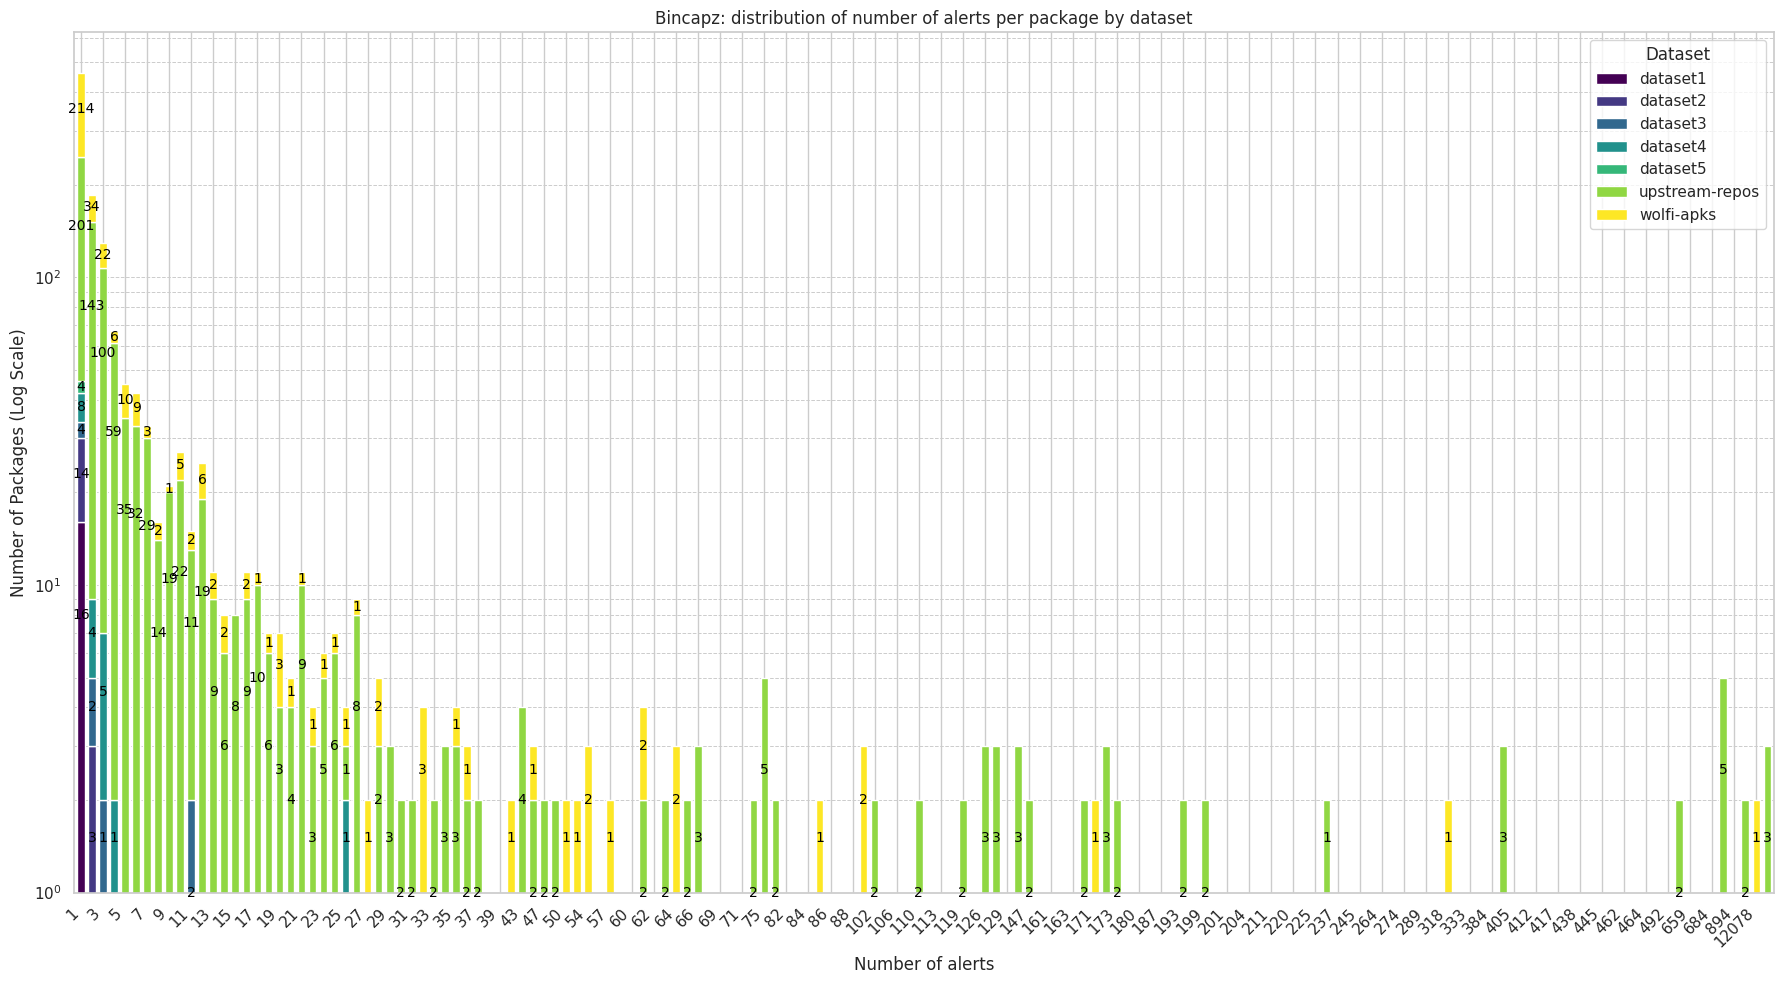

In [ ]:
# Set the style of the visualization
sns.set(style="whitegrid")

# Create the plot with wider dimensions
plt.figure(figsize=(18, 10))  # Increase width to give more space to columns
ax = alerts_distribution_df.plot(kind='bar', stacked=True, colormap='viridis', figsize=(18, 10), width=0.7)  # Reduce bar width to avoid overlap

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
ax.set_xticks(ax.get_xticks()[::2])  # Display every 2th tick

# Set logarithmic scale for y-axis
plt.yscale('log')

# Set labels and title
plt.xlabel('Number of alerts')
plt.ylabel('Number of Packages (Log Scale)')
plt.title('Bincapz: distribution of number of alerts per package by dataset')

# Add gridlines for y-axis for better readability
plt.grid(True, axis='y', which='both', linestyle='--', linewidth=0.7)

# Add data labels
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only add labels for non-zero bars
        ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., p.get_y() + height / 2.),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 0),
                    textcoords='offset points')



plt.tight_layout()
output_image_path = r'bincapz.png'
plt.savefig(output_image_path)
# Show the plot
plt.show()

In [ ]:
output_image_path = r'Distribution_of_number_of_alerts_per_package_by_dataset.png'
plt.savefig(output_image_path)

<Figure size 640x480 with 0 Axes>

## ROC curve for bincapz/malcontent

In [ ]:

df = malicious_benign_pd_bincapz.copy()
# Convert the labels to 1 (malicious) and 0 (benign)




# Convert labels to binary values (1 for 'malicious', 0 otherwise)
y_true = (df['Label'] == 'malicious').astype(int)
y_scores = df['Number of Alerts']

# Create thresholds from 0 to max predicted value
thresholds_bincapz = np.linspace(0, y_scores.max(), 100)

# Initialize lists to store TPR and FPR
tpr_list_bincapz = []
fpr_list_bincapz = []

# Calculate TPR and FPR for each threshold
for threshold in thresholds_bincapz:
    y_pred = (y_scores >= threshold).astype(int)  # Predictions based on threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate TPR and FPR
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

    tpr_list_bincapz.append(tpr)
    fpr_list_bincapz.append(fpr)

In [ ]:
roc_df_bincapz = pd.DataFrame({
    'threshold': thresholds_bincapz,
    'tpr': tpr_list_bincapz,
    'fpr': fpr_list_bincapz
})

# Save the DataFrame to a CSV file
roc_df_bincapz.to_csv('roc_data_bincapz.csv', index=False)

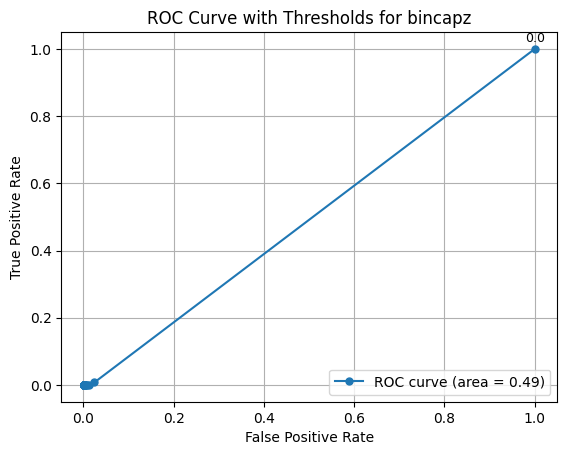

In [ ]:
# Plot ROC curve
plt.figure()
plt.plot(fpr_list_bincapz, tpr_list_bincapz, marker='o', markersize=5, label='ROC curve (area = {:.2f})'.format(auc(fpr_list_bincapz, tpr_list_bincapz)))

# Annotating the thresholds on the curve with better readability
for i, threshold in enumerate(thresholds_bincapz):
    if fpr_list_bincapz[i] > 0.12:  # Focus on the dense area
        plt.annotate(f'{threshold:}', (fpr_list_bincapz[i], tpr_list_bincapz[i]),
                         textcoords="offset points", xytext=(0, 5),
                         ha='center', fontsize=9)
    elif fpr_list_bincapz[i] > 0.1 and i %  2 == 0:
        plt.annotate(f'{threshold}', (fpr_list_bincapz[i], tpr_list_bincapz[i]),
                         textcoords="offset points", xytext=(0, 5),
                         ha='center', fontsize=9)






plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Thresholds for bincapz')
plt.legend(loc="lower right")
plt.grid(True)

# Save the plot as an image (e.g., PNG format)
plt.savefig('roc_curve_bincapz.png', dpi=300, bbox_inches='tight')  # Specify file name, dpi for resolution, and bbox for tight layout

# Show the plot
plt.show()


# Oss-detect-backdoor

In [ ]:
# Loading oss-detec-backdoor scanning results
odb_pd = pd.read_csv("https://raw.githubusercontent.com/lyvd/patd-results/refs/heads/main/results-csv/oss-detect-backdoor.csv")
odb_pd.head()

,Dataset,Package,File,Number of Alerts
0,dataset1,add-position-99.10.9,./datasets/malware/dataset1/add-position-99.10...,1
1,dataset1,add-position-99.10.9,./datasets/malware/dataset1/add-position-99.10...,21
2,dataset1,call-with-safe-iteration-closing-99.10.13,./datasets/malware/dataset1/call-with-safe-ite...,21
3,dataset1,call-with-safe-iteration-closing-99.10.13,./datasets/malware/dataset1/call-with-safe-ite...,1
4,dataset1,eslint-config-eslint-5.0.2,./datasets/malware/dataset1/eslint-config-esli...,1


In [ ]:
odb_pd.describe()

,Number of Alerts
count,180672.000000
mean,17.066845
std,1032.024078
min,1.000000
25%,1.000000
50%,3.000000
75%,7.000000
max,296523.000000


In [ ]:
# Number of packages per dataset
odb_pd.groupby(["Dataset"])["Package"].nunique()

,Package
Dataset,
dataset1,29
dataset2,24
dataset3,20
dataset4,26
dataset5,1
upstream-repos,1046
wolfi-apks,787


In [ ]:
odb_pd['Dataset'].value_counts()

,count
Dataset,
upstream-repos,152807
wolfi-apks,24177
dataset4,2119
dataset3,976
dataset2,456
dataset1,136
dataset5,1


## Performance of oss-detect-backdoor on the source code and apk datasets

In [ ]:
# Label the packages based on the dataset
def label_package(row):
    if row['Dataset'] in ['dataset1', 'dataset2', 'dataset3', 'dataset4', 'dataset5']:
        return 'malicious'
    elif row['Dataset'] in ['wolfi-apks', 'upstream-repos']:
        return 'benign'
    else:
        return 'unknown'



In [ ]:
df_malicious_benign_odb = pd.read_csv("https://github.com/lyvd/patd-results/raw/refs/heads/master/results-csv-full/oss_detect_backdoor_full.csv")

In [ ]:
df_malicious_benign_odb.groupby('Dataset')['Package'].nunique()

,Package
Dataset,
dataset1,30
dataset2,25
dataset3,28
dataset4,27
dataset5,10
upstream-repos,1775
wolfi-apks,1748


In [ ]:
df_malicious_odb = pd.read_csv("https://raw.githubusercontent.com/lyvd/patd-results/refs/heads/main/results-csv/oss-detect-backdoor.csv")

In [ ]:
df_malicious_odb.head()

,Dataset,Package,File,Number of Alerts
0,dataset1,add-position-99.10.9,./datasets/malware/dataset1/add-position-99.10...,1
1,dataset1,add-position-99.10.9,./datasets/malware/dataset1/add-position-99.10...,21
2,dataset1,call-with-safe-iteration-closing-99.10.13,./datasets/malware/dataset1/call-with-safe-ite...,21
3,dataset1,call-with-safe-iteration-closing-99.10.13,./datasets/malware/dataset1/call-with-safe-ite...,1
4,dataset1,eslint-config-eslint-5.0.2,./datasets/malware/dataset1/eslint-config-esli...,1


In [ ]:
df_malicious_odb.groupby('Dataset')['Package'].nunique()

,Package
Dataset,
dataset1,29
dataset2,24
dataset3,20
dataset4,26
dataset5,1
upstream-repos,1046
wolfi-apks,787


In [ ]:
df_benign_odb = df_malicious_benign_odb[df_malicious_benign_odb['Number of alerts'].isin([0])]

In [ ]:
df_benign_odb.groupby('Dataset')['Package'].nunique()

,Package
Dataset,
dataset1,1
dataset2,1
dataset3,8
dataset4,1
dataset5,9
upstream-repos,729
wolfi-apks,961


In [ ]:
malicious_pd_odb = df_malicious_odb.groupby(['Dataset', 'Package'])['Number of Alerts'].sum().reset_index()
malicious_pd_odb.columns = ['Dataset', 'Package name', 'Number of Alerts']

In [ ]:
malicious_pd_odb.head()

,Dataset,Package name,Number of Alerts
0,dataset1,aastra-xml_api-1.1.4,36
1,dataset1,abbyy_cloud-0.0.10,126
2,dataset1,activemerchant_clickandbuy-0.2.0,11
3,dataset1,add-position-99.10.9,22
4,dataset1,aioconsol-1.0.tar,296523


In [ ]:
benign_pd_odb = df_benign_odb.groupby(['Dataset', 'Package'])['Number of alerts'].sum().reset_index()
benign_pd_odb.columns = ['Dataset', 'Package name', 'Number of Alerts']
benign_pd_odb

,Dataset,Package name,Number of Alerts
0,dataset1,zero-falhas-vilao-1.0.0,0
1,dataset2,zero-falhas-vilao-1.0.0-r0,0
2,dataset3,lerna-8.1.6-r0,0
3,dataset3,node-gyp-10.2.0-r0,0
4,dataset3,py3-decorator-5.1.1-r2,0
...,...,...,...
1705,wolfi-apks,zig-0.13.0-r2,0
1706,wolfi-apks,zola-0.19.2-r1,0
1707,wolfi-apks,zot-2.1.1-r3,0
1708,wolfi-apks,zoxide-0.9.6-r0,0


In [ ]:
malicious_benign_pd_odb = pd.concat([malicious_pd_odb, benign_pd_odb], ignore_index=True)

In [ ]:
malicious_benign_pd_odb.groupby('Dataset')['Package name'].nunique()

,Package name
Dataset,
dataset1,30
dataset2,25
dataset3,28
dataset4,27
dataset5,10
upstream-repos,1775
wolfi-apks,1748


In [ ]:
malicious_benign_pd_odb['Label'] = malicious_benign_pd_odb.apply(label_package, axis=1)

In [ ]:
malicious_benign_pd_odb.head()

,Dataset,Package name,Number of Alerts,Label
0,dataset1,aastra-xml_api-1.1.4,36,malicious
1,dataset1,abbyy_cloud-0.0.10,126,malicious
2,dataset1,activemerchant_clickandbuy-0.2.0,11,malicious
3,dataset1,add-position-99.10.9,22,malicious
4,dataset1,aioconsol-1.0.tar,296523,malicious


In [ ]:
def calculate_metrics_odb(df):
    # Ensure necessary columns exist
    if 'Label' not in df.columns or 'Number of Alerts' not in df.columns:
        raise ValueError("DataFrame must contain 'Label' and 'Number of Alerts' columns.")

    # Convert labels to binary values (1 for 'malicious', 0 otherwise)
    y_true = (df['Label'] == 'malicious').astype(int)
    y_scores = df['Number of Alerts']

    # Create thresholds from 0 to max predicted value
    thresholds = np.linspace(0, y_scores.max(), 100)

    tpr_values = []
    fpr_values = []

    # Calculate TPR and FPR for each threshold
    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)  # Predictions based on threshold
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        # Calculate TPR and FPR
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

        tpr_values.append(tpr)
        fpr_values.append(fpr)

    # Calculate AUC using the list of FPR and TPR values
    AUC = auc(fpr_values, tpr_values)

    # Calculate metrics at threshold = 1 (specific threshold)
    specific_threshold = 1
    y_pred_specific = (y_scores >= specific_threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_specific).ravel()

    # Calculate TPR, FPR, TNR, FNR for threshold = 1
    TPR_specific = tp / (tp + fn) if (tp + fn) > 0 else 0
    FPR_specific = fp / (fp + tn) if (fp + tn) > 0 else 0
    TNR_specific = tn / (tn + fp) if (tn + fp) > 0 else 0
    FNR_specific = fn / (fn + tp) if (fn + tp) > 0 else 0

    # Calculate precision, recall, and F1 score at threshold = 1
    precision = (tp) / (tp + fp) if (tp + fp) > 0 else 0
    recall = (tp) / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Create the DataFrame with the desired metrics
    metrics_df = pd.DataFrame({
        'TP': [tp],
        'FP': [fp],
        'TN': [tn],
        'FN': [fn],
        'True Positive Rate (TPR)': [round(TPR_specific, 2)],
        'False Positive Rate (FPR)': [round(FPR_specific, 2)],
        'True Negative Rate (TNR)': [round(TNR_specific, 2)],
        'False Negative Rate (FNR)': [round(FNR_specific, 2)],
        'Precision': [round(precision, 2)],
        'Recall': [round(recall, 2)],
        'F1 Score': [round(f1, 2)],
        'AUC': [round(AUC, 3)]
    })

    return metrics_df



In [ ]:
#dataset1, 4 and upstream-repose
calculate_metrics_odb(malicious_benign_pd_odb[malicious_benign_pd_odb['Dataset'].isin(["dataset1", "dataset4", "upstream-repos"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,55,1046,729,2,0.96,0.59,0.41,0.04,0.05,0.96,0.09,0.497


In [ ]:
#dataset1 anf upstream-repose
calculate_metrics_odb(malicious_benign_pd_odb[malicious_benign_pd_odb['Dataset'].isin(["dataset1", "upstream-repos"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,29,1046,729,1,0.97,0.59,0.41,0.03,0.03,0.97,0.05,0.496


In [ ]:
#dataset4 and upstream-repose
calculate_metrics_odb(malicious_benign_pd_odb[malicious_benign_pd_odb['Dataset'].isin(["dataset4", "upstream-repos"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,26,1046,729,1,0.96,0.59,0.41,0.04,0.02,0.96,0.05,0.497


In [ ]:
#dataset2,3,5 and apks
calculate_metrics_odb(malicious_benign_pd_odb[malicious_benign_pd_odb['Dataset'].isin(["dataset2", "dataset3", "dataset5", "wolfi-apks"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,45,787,961,18,0.71,0.45,0.55,0.29,0.05,0.71,0.1,0.517


In [ ]:
#dataset2 and apks
calculate_metrics_odb(malicious_benign_pd_odb[malicious_benign_pd_odb['Dataset'].isin(["dataset2", "wolfi-apks"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,24,787,961,1,0.96,0.45,0.55,0.04,0.03,0.96,0.06,0.533


In [ ]:
#dataset3 and apks
calculate_metrics_odb(malicious_benign_pd_odb[malicious_benign_pd_odb['Dataset'].isin(["dataset3", "wolfi-apks"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,20,787,961,8,0.71,0.45,0.55,0.29,0.02,0.71,0.05,0.553


In [ ]:
#dataset5 and apks
calculate_metrics_odb(malicious_benign_pd_odb[malicious_benign_pd_odb['Dataset'].isin(["dataset5", "wolfi-apks"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,1,787,961,9,0.1,0.45,0.55,0.9,0.0,0.1,0.0,0.481


### plot scatter number of alert and number of samples

In [ ]:
malicious_pd_odb.head()

,Dataset,Package name,Number of Alerts
0,dataset1,aastra-xml_api-1.1.4,36
1,dataset1,abbyy_cloud-0.0.10,126
2,dataset1,activemerchant_clickandbuy-0.2.0,11
3,dataset1,add-position-99.10.9,22
4,dataset1,aioconsol-1.0.tar,296523


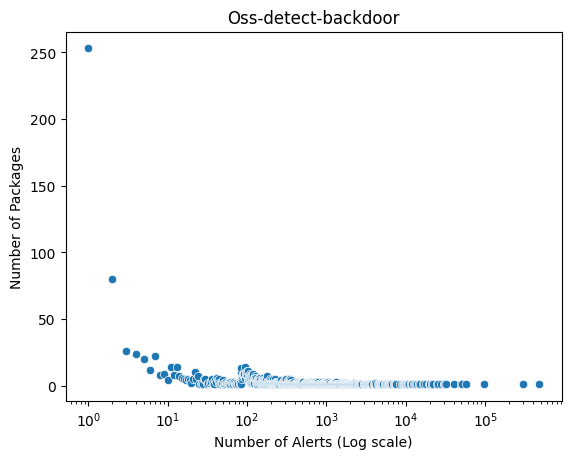

In [ ]:
alert_counts = malicious_pd_odb.groupby('Number of Alerts')['Package name'].count().reset_index()
alert_counts.columns = ['Number of Alerts', 'Number of Packages']
sns.scatterplot(data=alert_counts, x='Number of Alerts', y='Number of Packages')
plt.title('Oss-detect-backdoor')
plt.xscale('log')
plt.xlabel('Number of Alerts (Log scale)')
plt.ylabel('Number of Packages')
plt.savefig('odb_scatter.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Distribution of the number alerts in each dataset of ODB

In [ ]:
odb_alerts_distribution_df = odb_pd.groupby(['Number of alerts', 'Dataset']).size().unstack(fill_value=0)

<Figure size 2400x1200 with 0 Axes>

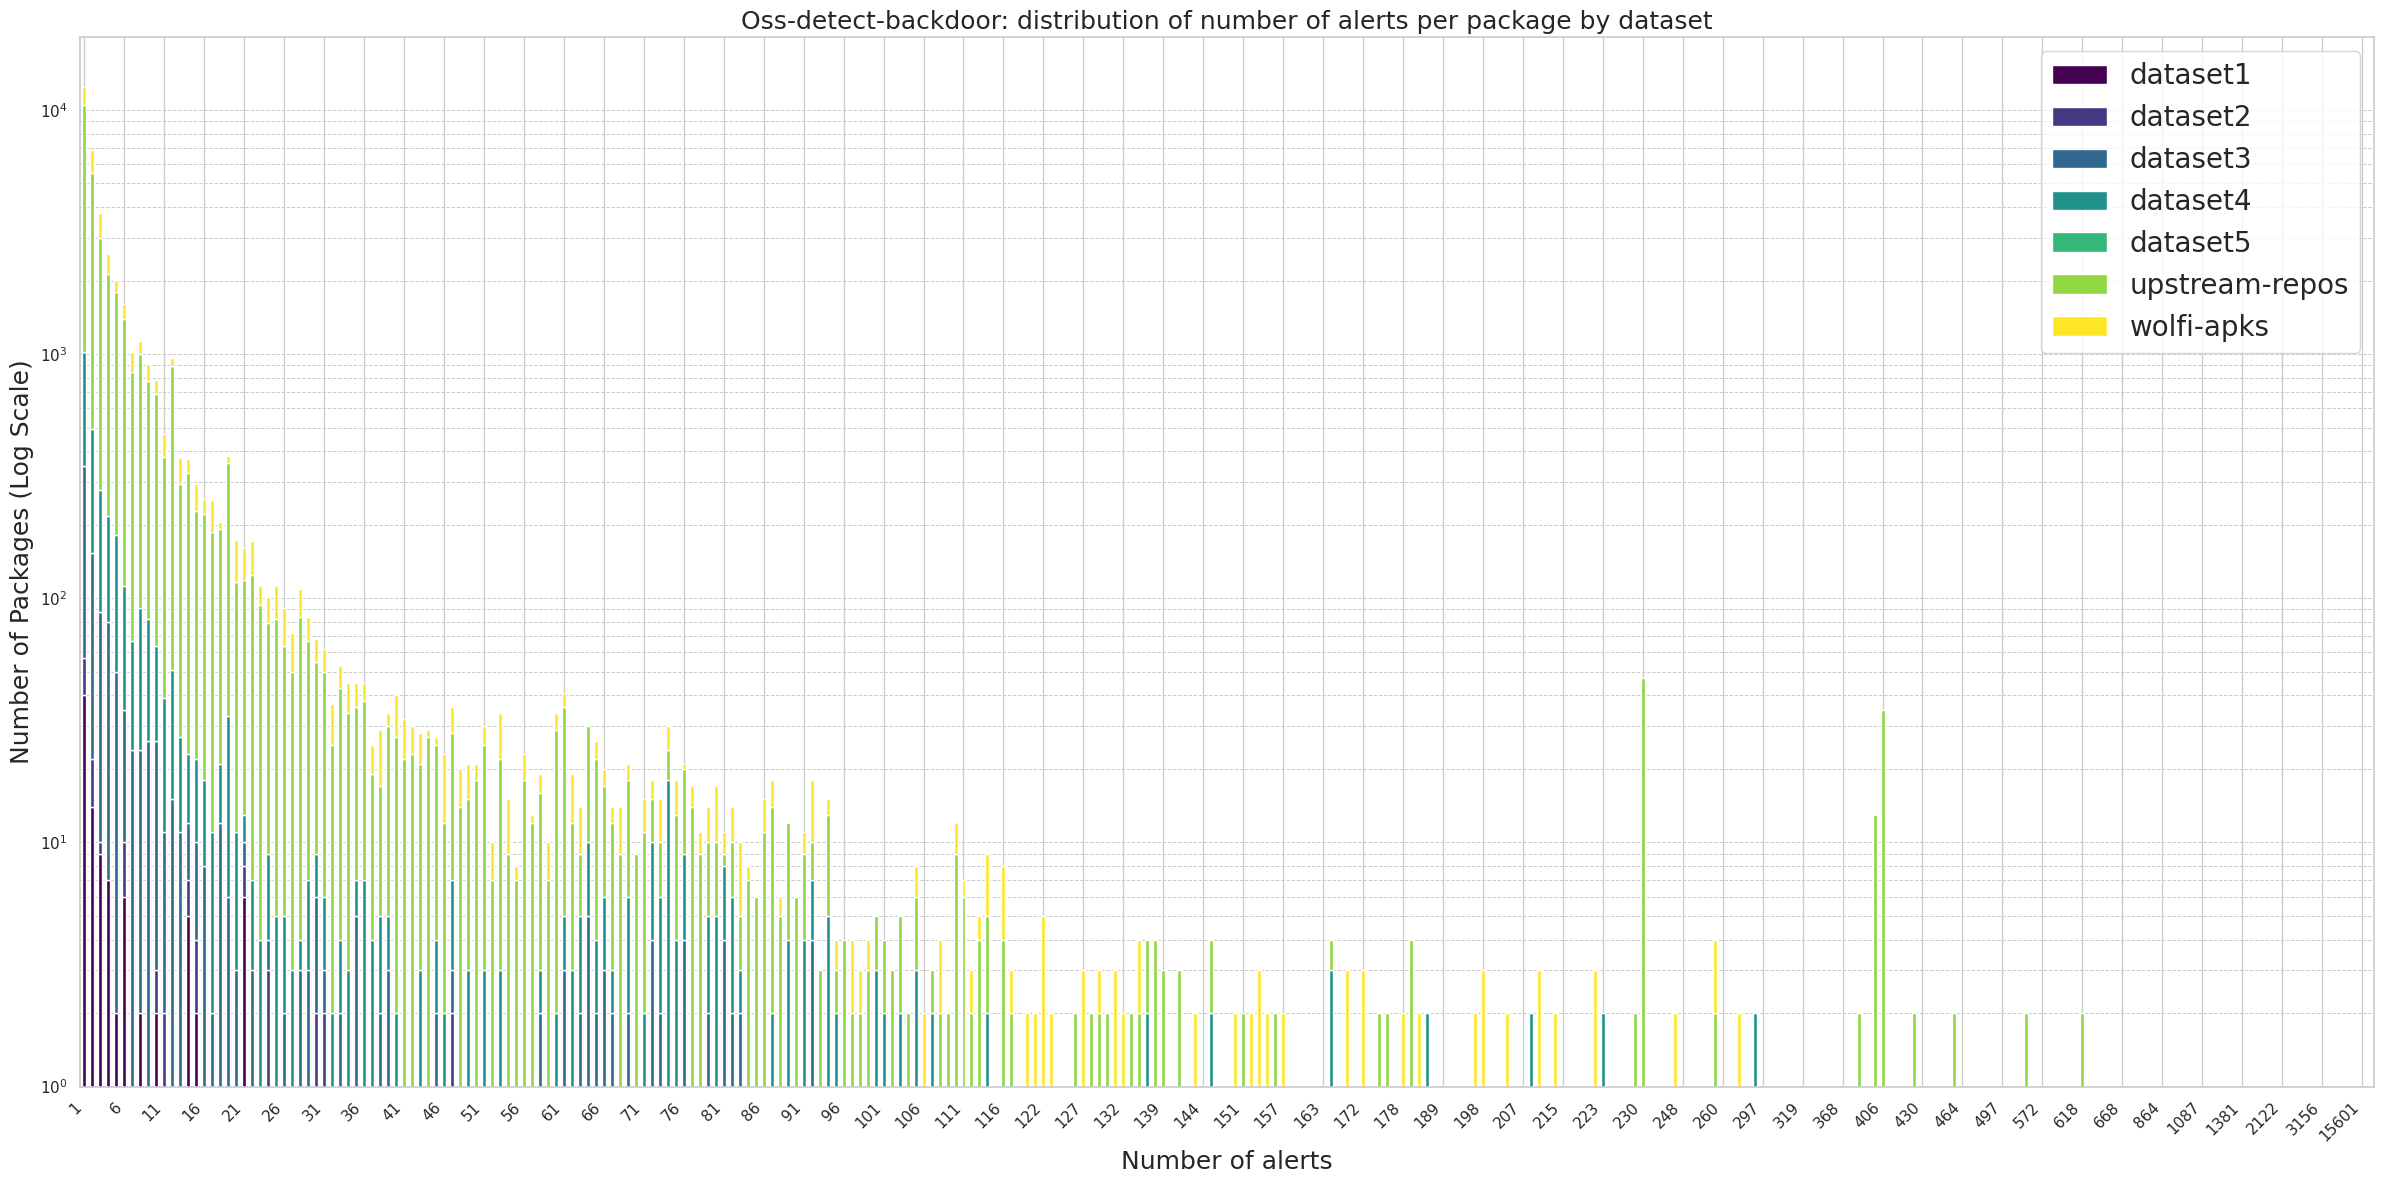

In [ ]:
# Set the style of the visualization
sns.set(style="whitegrid")

# Create the plot with wider dimensions and adjust the bar width
plt.figure(figsize=(24, 12))  # Increase width to give more space to columns
ax = odb_alerts_distribution_df.plot(kind='bar', stacked=True, colormap='viridis', figsize=(24, 12), width=0.5)  # Reduce bar width to avoid overlap

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Reduce the number of x-axis ticks
ax.set_xticks(ax.get_xticks()[::5])  # Display every 5th tick

# Set logarithmic scale for y-axis
plt.yscale('log')

# Set labels and title
plt.xlabel('Number of alerts', fontsize=18)
plt.ylabel('Number of Packages (Log Scale)', fontsize=18)
plt.title('Oss-detect-backdoor: distribution of number of alerts per package by dataset',  fontsize=18)

# Increase the font size of the legend
plt.legend(fontsize=20)  # Increase legend font size

# Add gridlines for y-axis for better readability
plt.grid(True, axis='y', which='both', linestyle='--', linewidth=0.7)



# Adjust layout and save the plot
plt.tight_layout()
out_put_image_path = r'oss-detect-backdoor.png'
plt.savefig(out_put_image_path)

# Show the plot
plt.show()

## OSS detect backdoor ROC curves

In [ ]:
# Label the packages based on the dataset
def label_package(row):
    if row['Dataset'] in ['dataset1', 'dataset2', 'dataset3', 'dataset4', 'dataset5']:
        return 'malicious'
    elif row['Dataset'] in ['wolfi-apks', 'upstream-repos']:
        return 'benign'
    else:
        return 'unknown'



In [ ]:
df = malicious_benign_pd_odb.copy()
# Convert labels to binary values (1 for 'malicious', 0 otherwise)
y_true = (df['Label'] == 'malicious').astype(int)
y_scores = df['Number of Alerts']

# Create thresholds from 0 to max predicted value
thresholds_odb = np.linspace(0, y_scores.max(), 100)

# Initialize lists to store TPR and FPR
tpr_list_odb = []
fpr_list_odb = []

# Calculate TPR and FPR for each threshold
for threshold in thresholds_odb:
    y_pred = (y_scores >= threshold).astype(int)  # Predictions based on threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate TPR and FPR
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

    tpr_list_odb.append(tpr)
    fpr_list_odb.append(fpr)

In [ ]:
df_roc_odb = pd.DataFrame({
    'threshold': thresholds_odb,
    'tpr': tpr_list_odb,
    'fpr': fpr_list_odb
})
df_roc_odb.to_csv('roc_data_odb.csv', index=False)

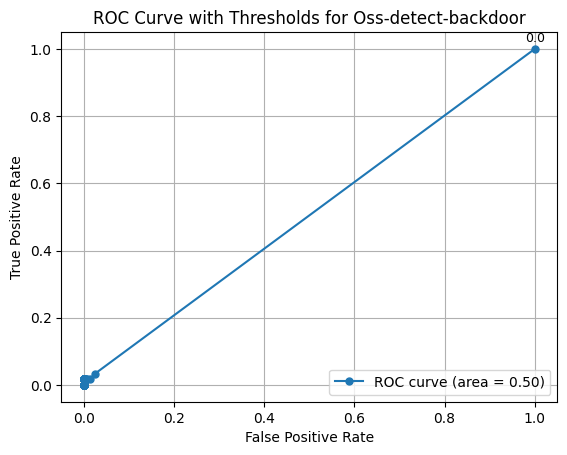

In [ ]:
# Plot ROC curve
plt.figure()
plt.plot(fpr_list_odb, tpr_list_odb, marker='o', markersize=5, label='ROC curve (area = {:.2f})'.format(auc(fpr_list_odb, tpr_list_odb)))

# Annotating the thresholds on the curve with better readability
for i, threshold in enumerate(thresholds_odb):
    if fpr_list_odb[i] < 0.3:  # Focus on the dense area
      pass
    elif i% 4 == 0:
        plt.annotate(f'{threshold}', (fpr_list_odb[i], tpr_list_odb[i]),
                     textcoords="offset points", xytext=(0, 5),
                     ha='center', fontsize=9)



plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Thresholds for Oss-detect-backdoor')
plt.legend(loc="lower right")
plt.grid(True)

# Save the plot as an image (e.g., PNG format)
plt.savefig('roc_curve_oss-detect-backdoor.png', dpi=300, bbox_inches='tight')  # Specify file name, dpi for resolution, and bbox for tight layout

# Show the plot
plt.show()


# Packj

In [ ]:
packj_pd = pd.read_csv("https://raw.githubusercontent.com/lyvd/patd-results/refs/heads/main/results-csv/packj.csv")
packj_pd.head()

,Dataset,Package,Language,fullName,sourceType
0,dataset1,add-position-99.10.9,Javascript,fs.readdirSync,SOURCE_FILE
1,dataset1,add-position-99.10.9,Javascript,Buffer.from,SOURCE_OBFUSCATION
2,dataset1,add-position-99.10.9,Javascript,https.request,SOURCE_NETWORK
3,dataset1,call-with-safe-iteration-closing-99.10.13,Javascript,fs.readdirSync,SOURCE_FILE
4,dataset1,call-with-safe-iteration-closing-99.10.13,Javascript,Buffer.from,SOURCE_OBFUSCATION


In [ ]:
packj_pd.groupby(["Dataset"])["Package"].nunique()

,Package
Dataset,
dataset1,18
dataset4,25
upstream-repos,790


## Performance of packj on the source code and apk datasets

In [ ]:
# Label the packages based on the dataset
def label_package(row):
    if row['Dataset'] in ['dataset1', 'dataset2', 'dataset3', 'dataset4', 'dataset5']:
        return 'malicious'
    elif row['Dataset'] in ['wolfi-apks', 'upstream-repos']:
        return 'benign'
    else:
        return 'unknown'


In [ ]:
df_malicious_benign_packj = pd.read_csv("https://github.com/lyvd/patd-results/raw/refs/heads/master/results-csv-full/packj_full.csv")

In [ ]:
df_malicious_benign_packj.groupby(["Dataset"])["Package"].nunique()

,Package
Dataset,
dataset1,29
dataset4,30
upstream-repos,1183


In [ ]:
df_malicious_packj = pd.read_csv("https://github.com/lyvd/patd-results/raw/refs/heads/main/results-csv/packj.csv")

In [ ]:
df_malicious_packj.groupby(["Dataset"])["Package"].nunique()

,Package
Dataset,
dataset1,18
dataset4,25
upstream-repos,790


In [ ]:
#get df_benign package that not in df_malicious pACKAGE for each dataset
df_benign_packj = df_malicious_benign_packj[df_malicious_benign_packj['sourceType'].isin(["No sourceType"])]


In [ ]:
df_benign_packj.groupby(["Dataset"])["Package"].nunique()

,Package
Dataset,
dataset1,11
dataset4,5
upstream-repos,393


In [ ]:
malicious_pd_packj = df_malicious_packj.groupby(['Dataset','Package'])['sourceType'].count().reset_index()
malicious_pd_packj.columns = ['Dataset', 'Package name', 'Number of Alerts']

In [ ]:
benign_pd_packj = df_benign_packj.groupby(['Dataset','Package'])['sourceType'].count().reset_index()
benign_pd_packj.columns = ['Dataset','Package name', 'Number of Alerts']
benign_pd_packj['Number of Alerts'] = 0

In [ ]:
malicious_benign_pd_packj = pd.concat([malicious_pd_packj, benign_pd_packj], ignore_index=True)

In [ ]:
malicious_benign_pd_packj.groupby(["Dataset"])["Package name"].nunique()

,Package name
Dataset,
dataset1,29
dataset4,30
upstream-repos,1183


In [ ]:
malicious_benign_pd_packj.head()

,Dataset,Package name,Number of Alerts
0,dataset1,abbyy_cloud-0.0.10,1
1,dataset1,activemerchant_clickandbuy-0.2.0,1
2,dataset1,add-position-99.10.9,3
3,dataset1,apple-py-music-1.0,4
4,dataset1,atlas-client-0.0.2,1


In [ ]:
malicious_benign_pd_packj['Label'] = malicious_benign_pd_packj.apply(label_package, axis=1)

In [ ]:
def calculate_metrics_packj(df):
    # Ensure necessary columns exist
    if 'Label' not in df.columns or 'Number of Alerts' not in df.columns:
        raise ValueError("DataFrame must contain 'Label' and 'Number of Alerts' columns.")

    # Convert labels to binary values (1 for 'malicious', 0 otherwise)
    y_true = (df['Label'] == 'malicious').astype(int)
    y_scores = df['Number of Alerts']

    # Create thresholds from 0 to max predicted value
    thresholds = np.linspace(0, y_scores.max(), 100)

    tpr_values = []
    fpr_values = []

    # Calculate TPR and FPR for each threshold
    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)  # Predictions based on threshold
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        # Calculate TPR and FPR
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

        tpr_values.append(tpr)
        fpr_values.append(fpr)

    # Calculate AUC using the list of FPR and TPR values
    AUC = auc(fpr_values, tpr_values)

    # Calculate metrics at threshold = 1 (specific threshold)
    specific_threshold = 1
    y_pred_specific = (y_scores >= specific_threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_specific).ravel()

    # Calculate TPR, FPR, TNR, FNR for threshold = 1
    TPR_specific = tp / (tp + fn) if (tp + fn) > 0 else 0
    FPR_specific = fp / (fp + tn) if (fp + tn) > 0 else 0
    TNR_specific = tn / (tn + fp) if (tn + fp) > 0 else 0
    FNR_specific = fn / (fn + tp) if (fn + tp) > 0 else 0

    # Calculate precision, recall, and F1 score at threshold = 1
    precision = (tp) / (tp + fp) if (tp + fp) > 0 else 0
    recall = (tp) / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Create the DataFrame with the desired metrics
    metrics_df = pd.DataFrame({
        'TP': [tp],
        'FP': [fp],
        'TN': [tn],
        'FN': [fn],
        'True Positive Rate (TPR)': [round(TPR_specific, 2)],
        'False Positive Rate (FPR)': [round(FPR_specific, 2)],
        'True Negative Rate (TNR)': [round(TNR_specific, 2)],
        'False Negative Rate (FNR)': [round(FNR_specific, 2)],
        'Precision': [round(precision, 2)],
        'Recall': [round(recall, 2)],
        'F1 Score': [round(f1, 2)],
        'AUC': [round(AUC, 3)]
    })

    return metrics_df



In [ ]:
# dataset1,4 upstream-repose
calculate_metrics_packj(malicious_benign_pd_packj[malicious_benign_pd_packj['Dataset'].isin(["dataset1", "dataset4", "upstream-repos"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,43,790,393,16,0.73,0.67,0.33,0.27,0.05,0.73,0.1,0.469


In [ ]:
#dataset1 and upstream
calculate_metrics_packj(malicious_benign_pd_packj[malicious_benign_pd_packj['Dataset'].isin(["dataset1", "upstream-repos"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,18,790,393,11,0.62,0.67,0.33,0.38,0.02,0.62,0.04,0.453


In [ ]:
#dataset4 and upstream
calculate_metrics_packj(malicious_benign_pd_packj[malicious_benign_pd_packj['Dataset'].isin(["dataset4", "upstream-repos"])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,25,790,393,5,0.83,0.67,0.33,0.17,0.03,0.83,0.06,0.256


### plotter scatter number of alert and number of samples

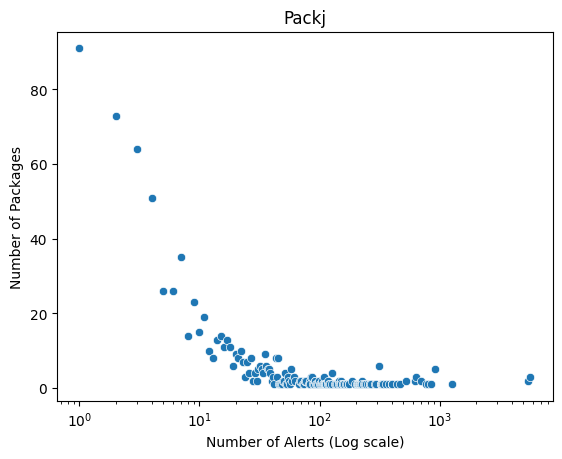

In [ ]:
#Plotter scatter number of alerts and number of sample for malicious odb malicious_pd_packj
alert_counts = malicious_pd_packj.groupby('Number of Alerts')['Package name'].count().reset_index()
alert_counts.columns = ['Number of Alerts', 'Number of Packages']
sns.scatterplot(data=alert_counts, x='Number of Alerts', y='Number of Packages')
plt.title('Packj')
plt.xscale('log')
plt.xlabel('Number of Alerts (Log scale)')
plt.ylabel('Number of Packages')
plt.savefig('packj_scatter.pdf', format='pdf', bbox_inches='tight')
plt.show()

<Figure size 1800x1000 with 0 Axes>

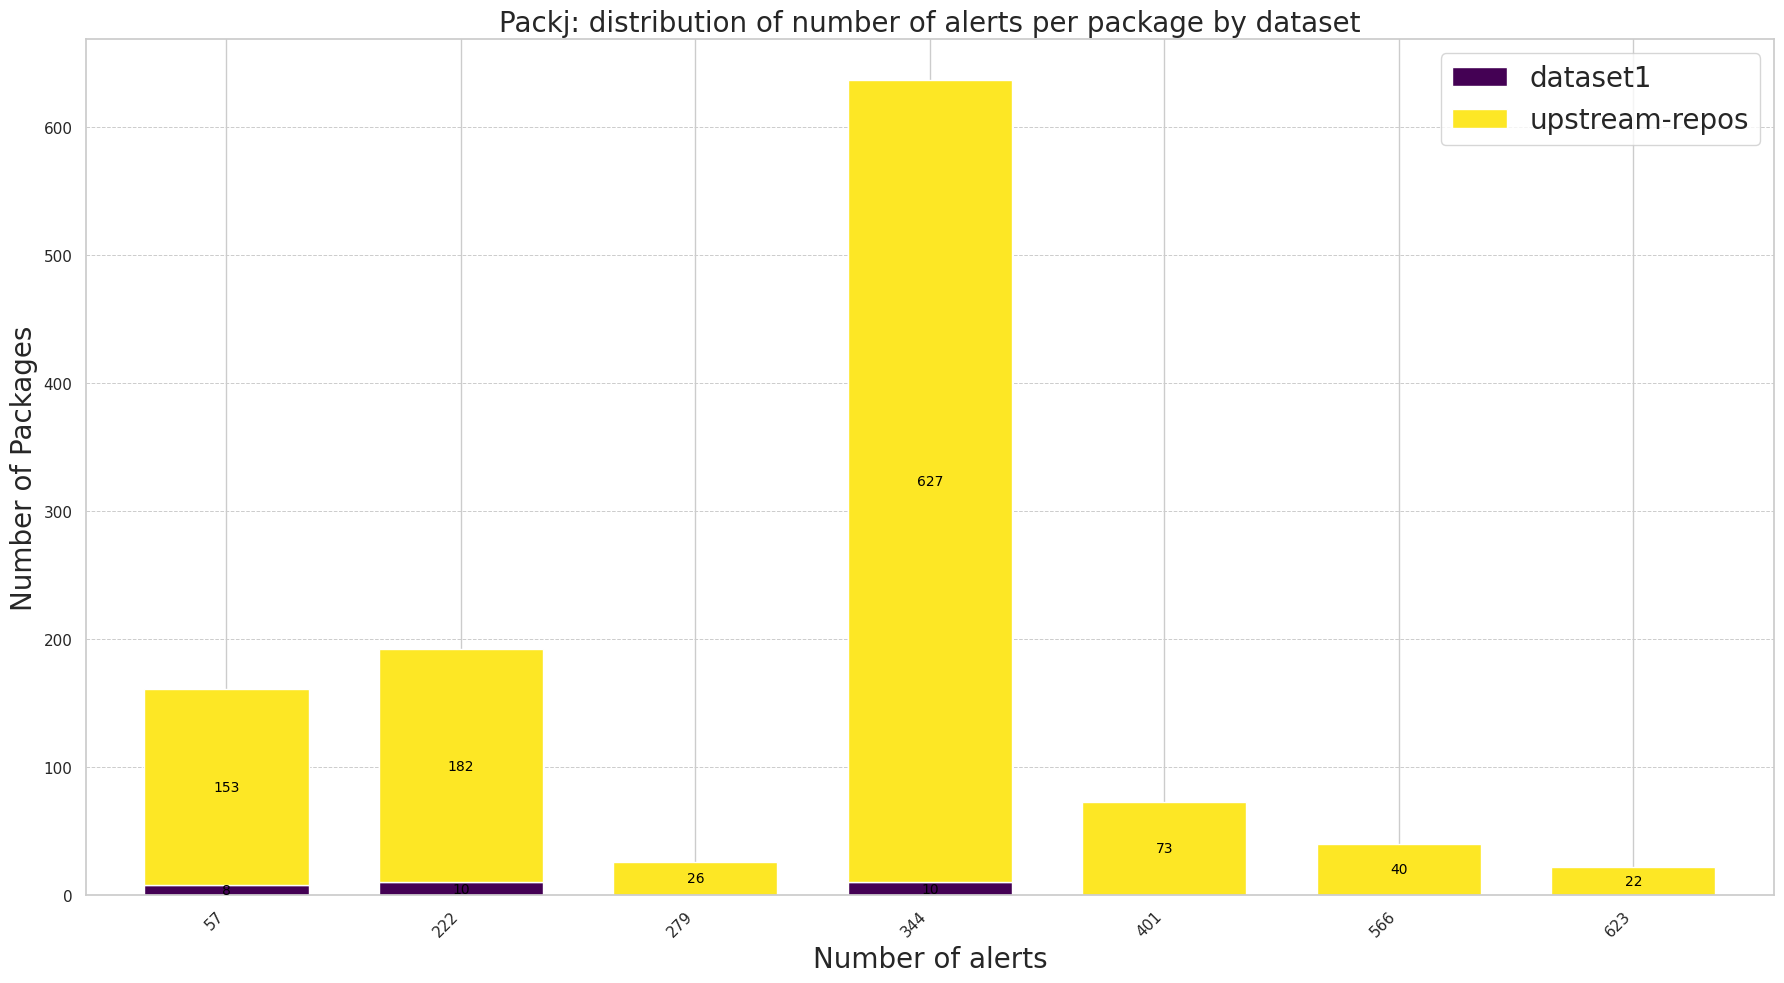

In [ ]:
# Set the style of the visualization
sns.set(style="whitegrid")

# Create the plot with wider dimensions
plt.figure(figsize=(18, 10))  # Increase width to give more space to columns
ax = packj__alerts_distribution_df.plot(kind='bar', stacked=True, colormap='viridis', figsize=(18, 10), width=0.7)  # Reduce bar width to avoid overlap

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
ax.set_xticks(ax.get_xticks()[::])  # Display every 2th tick

# Set logarithmic scale for y-axis
# plt.yscale('log')

# Set labels and title
plt.xlabel('Number of alerts', fontsize=20)
plt.ylabel('Number of Packages', fontsize=20)
plt.title('Packj: distribution of number of alerts per package by dataset', fontsize=20)

# Add gridlines for y-axis for better readability
plt.grid(True, axis='y', which='both', linestyle='--', linewidth=0.7)

# Increase the font size of the legend
plt.legend(fontsize=20)  # Increase legend font size

# Add data labels
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only add labels for non-zero bars
        ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., p.get_y() + height / 2.),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 0),
                    textcoords='offset points')



plt.tight_layout()
output_image_path = r'packj.png'
plt.savefig(output_image_path)
# Show the plot
plt.show()

## ROC curve for packj

In [ ]:
# Label the packages based on the dataset
def label_package(row):
    if row['Dataset'] in ['dataset1', 'dataset2', 'dataset3', 'dataset4', 'dataset5']:
        return 'malicious'
    elif row['Dataset'] in ['wolfi-apks', 'upstream-repos']:
        return 'benign'
    else:
        return 'unknown'


In [ ]:


df = malicious_benign_pd_packj.copy()
# Convert labels to binary values (1 for 'malicious', 0 otherwise)
y_true = (df['Label'] == 'malicious').astype(int)
y_scores = df['Number of Alerts']

# Create thresholds from 0 to max predicted value
thresholds_packj = np.linspace(0, y_scores.max(), 100)

# Initialize lists to store TPR and FPR
tpr_list_packj = []
fpr_list_packj = []

# Calculate TPR and FPR for each threshold
for threshold in thresholds_packj:
    y_pred = (y_scores >= threshold).astype(int)  # Predictions based on threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate TPR and FPR
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

    tpr_list_packj.append(tpr)
    fpr_list_packj.append(fpr)


In [ ]:
df_roc_packj = pd.DataFrame({
    'threshold': thresholds_packj,
    'tpr': tpr_list_packj,
    'fpr': fpr_list_packj
})
df_roc_packj.to_csv('roc_data_packj.csv', index=False)

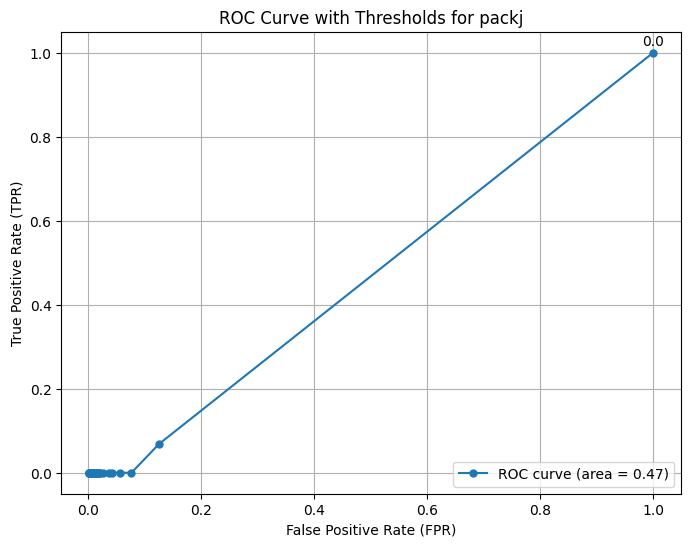

In [ ]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_list_packj, tpr_list_packj, marker='o', markersize=5, label='ROC curve (area = {:.2f})'.format(auc(fpr_list_packj, tpr_list_packj)))
# plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve with Thresholds for packj')
plt.legend(loc='lower right')
plt.grid(True)
# Add threshold values as annotations
for i, threshold in enumerate(thresholds_packj):

    if fpr_list_packj[i] > 0.4:
        plt.annotate(f'{threshold}', (fpr_list_packj[i], tpr_list_packj[i]),
                     textcoords="offset points", xytext=(0, 5), ha='center')


#save
plt.savefig('roc_curve_packj.png', dpi=300, bbox_inches='tight')  # Specify file name, dpi for resolution, and bbox for tight layout


plt.show()

# Bandit4mal

In [ ]:
bandit4mal_pd = pd.read_csv("https://github.com/lyvd/patd-results/raw/refs/heads/main/results-csv/bandit4mal.csv")
bandit4mal_pd.head()

,Dataset,Package,File,Number of alerts
0,dataset1,apple-py-music-1.0,..\patd-malware-datasets\dataset1\python\apple...,2
1,dataset1,cryptographylib-1.2.0,..\patd-malware-datasets\dataset1\python\crypt...,2
2,dataset1,equests-2.27.1,..\patd-malware-datasets\dataset1\python\eques...,3
3,dataset1,equests-2.27.1,..\patd-malware-datasets\dataset1\python\eques...,1
4,dataset1,jeIlyfish-0.7.0,..\patd-malware-datasets\dataset1\python\jeIly...,1


In [ ]:
# Number of packages per dataset
bandit4mal_pd.groupby(["Dataset"])["Package"].nunique()

,Package
Dataset,
dataset1,4
dataset4,10
upstream-repos,286


## Performance of bandit4mal on the source code datasets

In [ ]:
# Label the packages based on the dataset
def label_package(row):
    if row['Dataset'] in ['dataset1', 'dataset2', 'dataset3', 'dataset4', 'dataset5']:
        return 'malicious'
    elif row['Dataset'] in ['wolfi-apks', 'upstream-repos']:
        return 'benign'
    else:
        return 'unknown'

In [ ]:
df_malicious_benign_bandit4mal = pd.read_csv("https://github.com/lyvd/patd-results/raw/refs/heads/master/results-csv-full/bandit4mal_full.csv")

In [ ]:
df_malicious_benign_bandit4mal.head()

,Dataset,Package,File,Number of alerts
0,dataset1,aioconsol-1.0,No file,0
1,dataset1,apple-py-music-1.0,..\patd-malware-datasets\dataset1\python\apple...,2
2,dataset1,colorwin-6.6.8,No file,0
3,dataset1,cryptographylib-1.2.0,..\patd-malware-datasets\dataset1\python\crypt...,2
4,dataset1,equests-2.27.1,..\patd-malware-datasets\dataset1\python\eques...,3


In [ ]:
df_malicious_benign_bandit4mal.groupby(["Dataset"])["Package"].nunique()


,Package
Dataset,
dataset1,10
dataset4,10
upstream-repos,891


In [ ]:
df_malicious_bandit4mal = pd.read_csv("https://github.com/lyvd/patd-results/raw/refs/heads/main/results-csv/bandit4mal.csv")

In [ ]:
df_malicious_bandit4mal.head()

,Dataset,Package,File,Number of alerts
0,dataset1,apple-py-music-1.0,..\patd-malware-datasets\dataset1\python\apple...,2
1,dataset1,cryptographylib-1.2.0,..\patd-malware-datasets\dataset1\python\crypt...,2
2,dataset1,equests-2.27.1,..\patd-malware-datasets\dataset1\python\eques...,3
3,dataset1,equests-2.27.1,..\patd-malware-datasets\dataset1\python\eques...,1
4,dataset1,jeIlyfish-0.7.0,..\patd-malware-datasets\dataset1\python\jeIly...,1


In [ ]:
df_malicious_bandit4mal.groupby(["Dataset"])["Package"].nunique()

,Package
Dataset,
dataset1,4
dataset4,10
upstream-repos,286


In [ ]:
df_benign_bandit4mal = df_malicious_benign_bandit4mal[df_malicious_benign_bandit4mal['Number of alerts'] == 0]

In [ ]:
df_benign_bandit4mal.groupby(["Dataset"])["Package"].nunique()

,Package
Dataset,
dataset1,6
upstream-repos,605


In [ ]:
malicious_pd_bandit4mal = df_malicious_bandit4mal.groupby(['Dataset', 'Package'])['Number of alerts'].sum().reset_index()
malicious_pd_bandit4mal.columns = ['Dataset', 'Package name', 'Number of Alerts']

In [ ]:
benign_pd_bandit4mal = df_benign_bandit4mal.groupby(['Dataset', 'Package'])['Number of alerts'].sum().reset_index()
benign_pd_bandit4mal.columns = ['Dataset', 'Package name', 'Number of Alerts']

In [ ]:
benign_pd_bandit4mal

,Dataset,Package name,Number of Alerts
0,dataset1,aioconsol-1.0,0
1,dataset1,colorwin-6.6.8,0
2,dataset1,fijiwashere12323-0.0.0,0
3,dataset1,pytagora-1.2,0
4,dataset1,request-1.0.117,0
...,...,...,...
606,upstream-repos,zed,0
607,upstream-repos,zfp,0
608,upstream-repos,zfs,0
609,upstream-repos,zola,0


In [ ]:
malicious_benign_pd_bandit4mal = pd.concat([malicious_pd_bandit4mal, benign_pd_bandit4mal])

In [ ]:
malicious_benign_pd_bandit4mal.groupby(["Dataset"])["Package name"].nunique()

,Package name
Dataset,
dataset1,10
dataset4,10
upstream-repos,891


In [ ]:
malicious_benign_pd_bandit4mal['Label'] = malicious_benign_pd_bandit4mal.apply(label_package, axis=1)

In [ ]:
malicious_benign_pd_bandit4mal

,Dataset,Package name,Number of Alerts,Label
0,dataset1,apple-py-music-1.0,2,malicious
1,dataset1,cryptographylib-1.2.0,2,malicious
2,dataset1,equests-2.27.1,4,malicious
3,dataset1,jeIlyfish-0.7.0,1,malicious
4,dataset4,api,191,malicious
...,...,...,...,...
606,upstream-repos,zed,0,benign
607,upstream-repos,zfp,0,benign
608,upstream-repos,zfs,0,benign
609,upstream-repos,zola,0,benign


In [ ]:
def calculate_metrics_bandit4mal(df):
    # Ensure necessary columns exist
    if 'Label' not in df.columns or 'Number of Alerts' not in df.columns:
        raise ValueError("DataFrame must contain 'Label' and 'Number of Alerts' columns.")

    # Convert labels to binary values (1 for 'malicious', 0 otherwise)
    y_true = (df['Label'] == 'malicious').astype(int)
    y_scores = df['Number of Alerts']

    # Create thresholds from 0 to max predicted value
    thresholds = np.linspace(0, y_scores.max(), 100)

    tpr_values = []
    fpr_values = []

    # Calculate TPR and FPR for each threshold
    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)  # Predictions based on threshold
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        # Calculate TPR and FPR
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

        tpr_values.append(tpr)
        fpr_values.append(fpr)

    # Calculate AUC using the list of FPR and TPR values
    AUC = auc(fpr_values, tpr_values)

    # Calculate metrics at threshold = 1 (specific threshold)
    specific_threshold = 1
    y_pred_specific = (y_scores >= specific_threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_specific).ravel()

    # Calculate TPR, FPR, TNR, FNR for threshold = 1
    TPR_specific = tp / (tp + fn) if (tp + fn) > 0 else 0
    FPR_specific = fp / (fp + tn) if (fp + tn) > 0 else 0
    TNR_specific = tn / (tn + fp) if (tn + fp) > 0 else 0
    FNR_specific = fn / (fn + tp) if (fn + tp) > 0 else 0

    # Calculate precision, recall, and F1 score at threshold = 1
    precision = (tp) / (tp + fp) if (tp + fp) > 0 else 0
    recall = (tp) / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Create the DataFrame with the desired metrics
    metrics_df = pd.DataFrame({
        'TP': [tp],
        'FP': [fp],
        'TN': [tn],
        'FN': [fn],
        'True Positive Rate (TPR)': [round(TPR_specific, 2)],
        'False Positive Rate (FPR)': [round(FPR_specific, 2)],
        'True Negative Rate (TNR)': [round(TNR_specific, 2)],
        'False Negative Rate (FNR)': [round(FNR_specific, 2)],
        'Precision': [round(precision, 2)],
        'Recall': [round(recall, 2)],
        'F1 Score': [round(f1, 2)],
        'AUC': [round(AUC, 3)]
    })

    return metrics_df



In [ ]:
#dataset1,4 and upstream-repose
calculate_metrics_bandit4mal(malicious_benign_pd_bandit4mal[malicious_benign_pd_bandit4mal['Dataset'].isin(['dataset1', 'dataset4', 'upstream-repos'])])


,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,14,286,605,6,0.7,0.32,0.68,0.3,0.05,0.7,0.09,0.734


In [ ]:
#dataset1 and upstream-repos
calculate_metrics_bandit4mal(malicious_benign_pd_bandit4mal[malicious_benign_pd_bandit4mal['Dataset'].isin(['dataset1', 'upstream-repos'])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,4,286,605,6,0.4,0.32,0.68,0.6,0.01,0.4,0.03,0.516


In [ ]:
#dataset4 and upstream-repose
calculate_metrics_bandit4mal(malicious_benign_pd_bandit4mal[malicious_benign_pd_bandit4mal['Dataset'].isin(['dataset4', 'upstream-repos'])])

,TP,FP,TN,FN,True Positive Rate (TPR),False Positive Rate (FPR),True Negative Rate (TNR),False Negative Rate (FNR),Precision,Recall,F1 Score,AUC
0,10,286,605,0,1.0,0.32,0.68,0.0,0.03,1.0,0.07,0.949


### plot scatter number of alert and number of samples

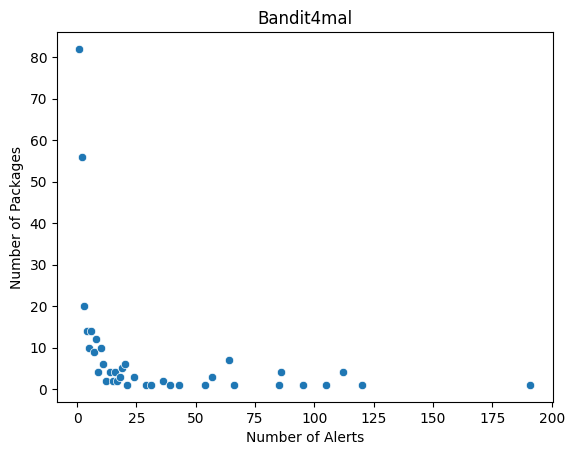

In [ ]:
alert_counts = malicious_pd_bandit4mal.groupby('Number of Alerts')['Package name'].count().reset_index()
alert_counts.columns = ['Number of Alerts', 'Number of Packages']
sns.scatterplot(data=alert_counts, x='Number of Alerts', y='Number of Packages')
plt.title('Bandit4mal')
# plt.xscale('log')
plt.xlabel('Number of Alerts')
plt.ylabel('Number of Packages')
#save to image
plt.savefig('banidt4mal_scatter.pdf', format='pdf', bbox_inches='tight')
plt.show()

 ## Distribution of the number alerts in each dataset of Bandit4mal

In [ ]:
bandit_alerts_distribution_df = bandit4mal_pd.groupby(['Number of alerts', 'Dataset']).size().unstack(fill_value=0)

<Figure size 1800x1000 with 0 Axes>

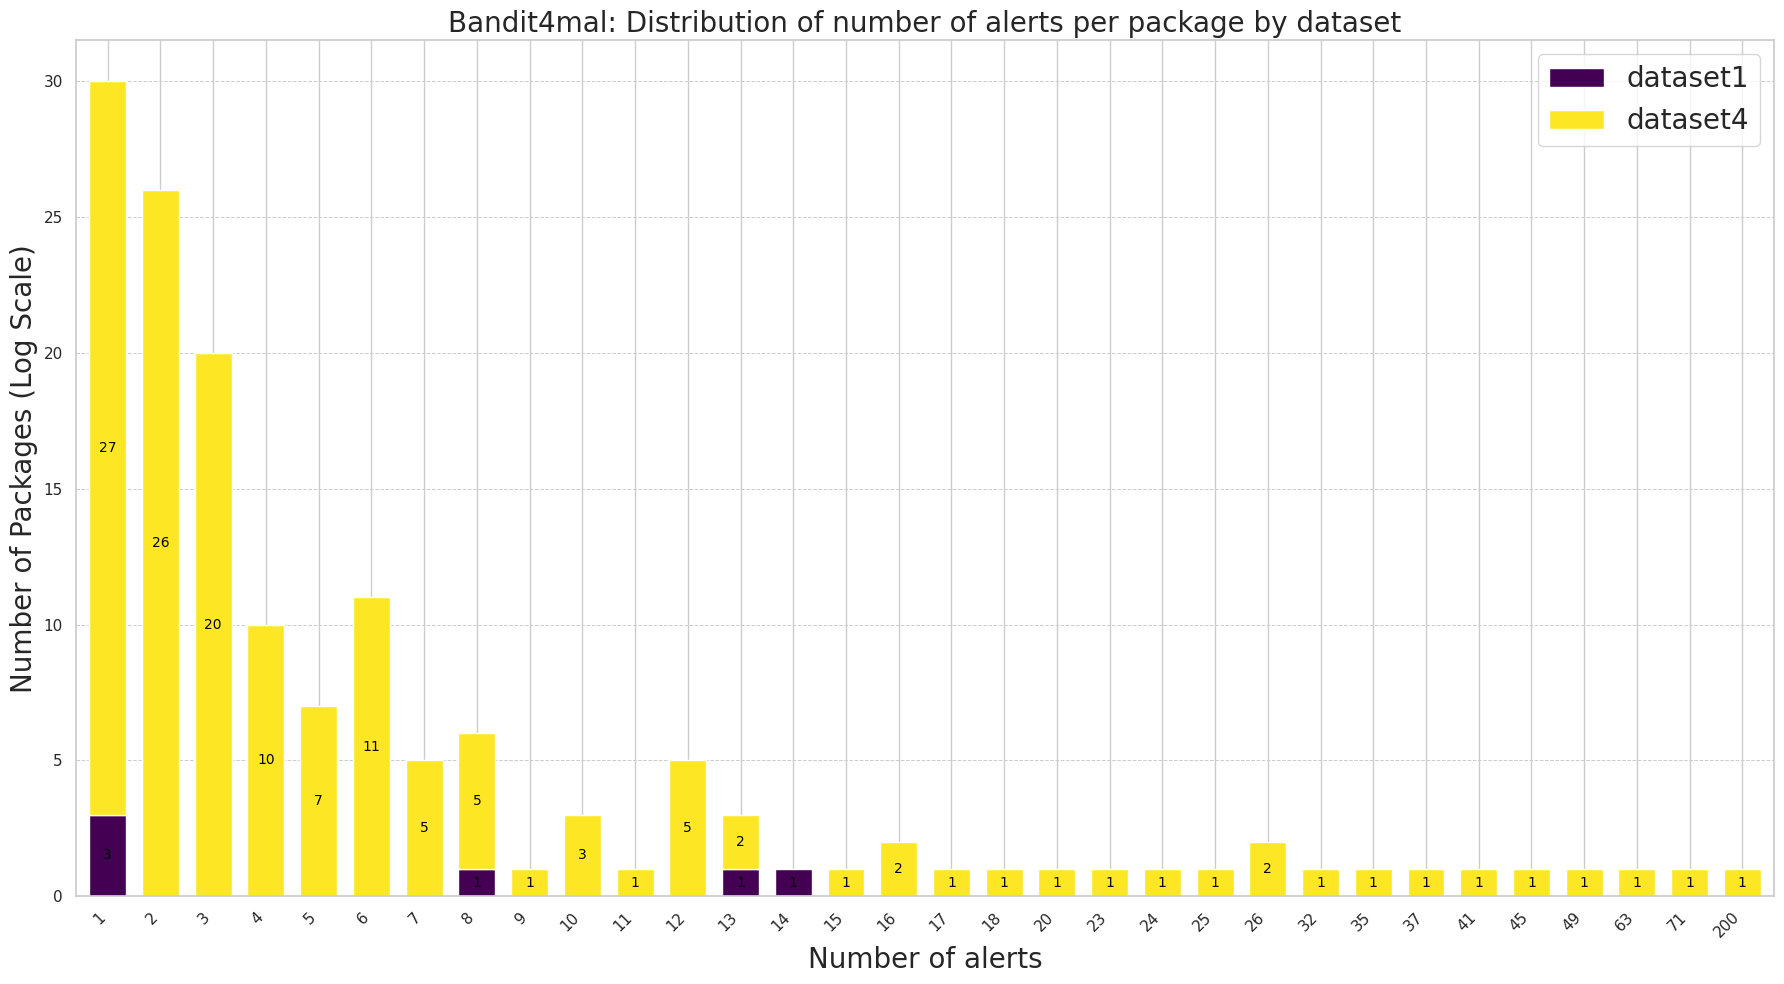

In [ ]:
# Set the style of the visualization
sns.set(style="whitegrid")

# Create the plot with wider dimensions
plt.figure(figsize=(18, 10))  # Increase width to give more space to columns
ax = bandit_alerts_distribution_df.plot(kind='bar', stacked=True, colormap='viridis', figsize=(18, 10), width=0.7)  # Reduce bar width to avoid overlap

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
ax.set_xticks(ax.get_xticks()[::])  # Display every 2th tick

# Set logarithmic scale for y-axis
# plt.yscale('log')

# Set labels and title
plt.xlabel('Number of alerts', fontsize=20)
plt.ylabel('Number of Packages (Log Scale)', fontsize=20)
plt.title('Bandit4mal: Distribution of number of alerts per package by dataset', fontsize=20)

# Add gridlines for y-axis for better readability
plt.grid(True, axis='y', which='both', linestyle='--', linewidth=0.7)

# Increase the font size of the legend
plt.legend(fontsize=20)  # Increase legend font size

# Add data labels
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only add labels for non-zero bars
        ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., p.get_y() + height / 2.),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 0),
                    textcoords='offset points')



plt.tight_layout()
output_image_path = r'banidt4mal.png'
plt.savefig(output_image_path)
# Show the plot
plt.show()

## ROC curve bandit4mal

In [ ]:
# Label the packages based on the dataset
def label_package(row):
    if row['Dataset'] in ['dataset1', 'dataset2', 'dataset3', 'dataset4', 'dataset5']:
        return 'malicious'
    elif row['Dataset'] in ['wolfi-apks', 'upstream-repos']:
        return 'benign'
    else:
        return 'unknown'



In [ ]:
df = malicious_benign_pd_bandit4mal.copy()

tpr_list_bandit4mal = []
fpr_list_bandit4mal = []

# Convert labels to binary values (1 for 'malicious', 0 otherwise)
y_true = (df['Label'] == 'malicious').astype(int)
y_scores = df['Number of Alerts']

# Create thresholds from 0 to max predicted value
thresholds_bandit4mal = np.linspace(0, y_scores.max(), 100)

# Calculate TPR and FPR for each threshold
for threshold in thresholds_bandit4mal:
    y_pred = (y_scores >= threshold).astype(int)  # Predictions based on threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate TPR and FPR
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

    tpr_list_bandit4mal.append(tpr)
    fpr_list_bandit4mal.append(fpr)

In [ ]:
df_roc_bandit4mal = pd.DataFrame({
    'threshold': thresholds_bandit4mal,
    'tpr': tpr_list_bandit4mal,
    'fpr': fpr_list_bandit4mal
})
df_roc_bandit4mal.to_csv('roc_data_bandit4mal.csv', index=False)

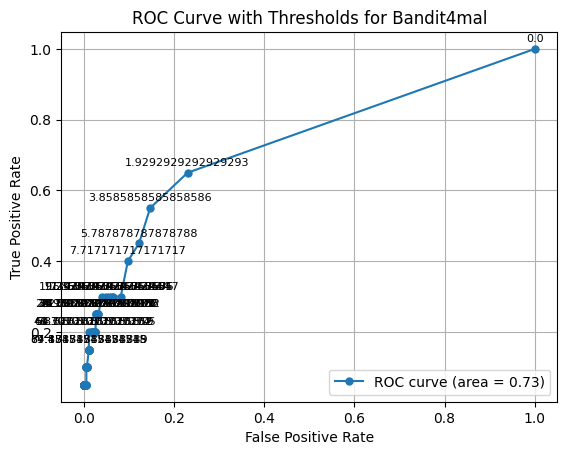

In [ ]:
# Plot ROC curve
plt.figure()
plt.plot(fpr_list_bandit4mal, tpr_list_bandit4mal, marker='o', markersize=5,
         label='ROC curve (area = {:.2f})'.format(auc(fpr_list_bandit4mal, tpr_list_bandit4mal)))

# Annotating thresholds selectively for better readability
for i, threshold in enumerate(thresholds_bandit4mal):
    if tpr_list_bandit4mal[i] > 0.2:  # Adjust the interval to reduce clutter
        plt.annotate(f'{threshold}', (fpr_list_bandit4mal[i], tpr_list_bandit4mal[i]),
                     textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)
    elif tpr_list_bandit4mal[i] > 0.1 and i %4 == 0:
        plt.annotate(f'{threshold}', (fpr_list_bandit4mal[i], tpr_list_bandit4mal[i]),
                     textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)



plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Thresholds for Bandit4mal')
plt.legend(loc="lower right")
plt.grid(True)

# Save and display the plot
# plt.savefig('roc_curve_bandit4mal.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#download all image
from google.colab import files
files.download('vt.png')
files.download('bincapz.png')
files.download('oss-detect-backdoor.png')
files.download('packj.png')
files.download('banidt4mal.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Distribution of alerts generated by the malware scanners on the combined dataset

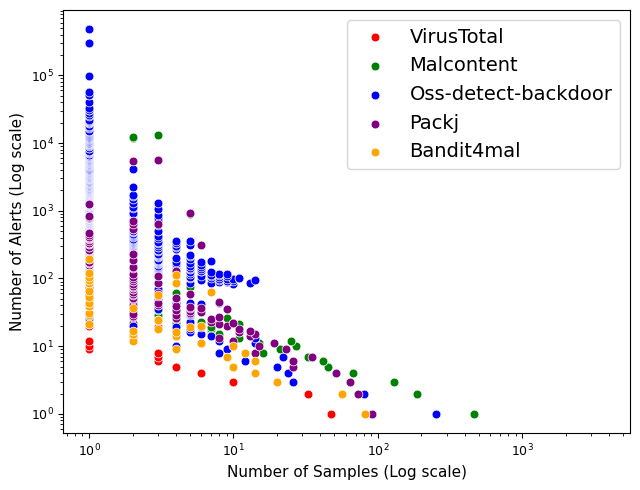

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create the figure
plt.figure(figsize=(6.5, 5))

# First scatter plot: VirusTotal
alert_counts = vt_pd.groupby('#AVs')['Package'].count().reset_index()
alert_counts.columns = ['#AV', 'Number of Samples']
sns.scatterplot(data=alert_counts, x='Number of Samples', y='#AV', label='VirusTotal', color='red', s=40)

# Second scatter plot: Malcontent
alert_counts = malicious_pd_bincapz.groupby('Number of Alerts')['Package name'].count().reset_index()
alert_counts.columns = ['Number of Alerts', 'Number of Samples']
sns.scatterplot(data=alert_counts, x='Number of Samples', y='Number of Alerts', label='Malcontent', color='green', s=40)

# Third scatter plot: Oss-detect-backdoor
alert_counts = malicious_pd_odb.groupby('Number of Alerts')['Package name'].count().reset_index()
alert_counts.columns = ['Number of Alerts', 'Number of Packages']
sns.scatterplot(data=alert_counts, x='Number of Packages', y='Number of Alerts', label='Oss-detect-backdoor', color='blue', s=40)

# Fourth scatter plot: Packj
alert_counts = malicious_pd_packj.groupby('Number of Alerts')['Package name'].count().reset_index()
alert_counts.columns = ['Number of Alerts', 'Number of Packages']
sns.scatterplot(data=alert_counts, x='Number of Packages', y='Number of Alerts', label='Packj', color='purple', s=40)

# Fifth scatter plot: Bandit4mal
alert_counts = malicious_pd_bandit4mal.groupby('Number of Alerts')['Package name'].count().reset_index()
alert_counts.columns = ['Number of Alerts', 'Number of Packages']
sns.scatterplot(data=alert_counts, x='Number of Packages', y='Number of Alerts', label='Bandit4mal', color='orange', s=40)

# Apply log scale to both axes
plt.xscale('log')
plt.yscale('log')

# Set labels and title
plt.xlabel('Number of Samples (Log scale)', fontsize=11)
plt.ylabel('Number of Alerts (Log scale)', fontsize=11)
# plt.title('Scatter Plots')
#reduce fontsize
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

# Display the legend with increased font size
plt.legend(fontsize=14)

# Show the plot
plt.tight_layout()
#save to pdf
plt.savefig('combined_scatter.pdf', format='pdf', bbox_inches='tight')
plt.show()


# CDF: Distribution of alerts generated by the malware scanners on the combined dataset

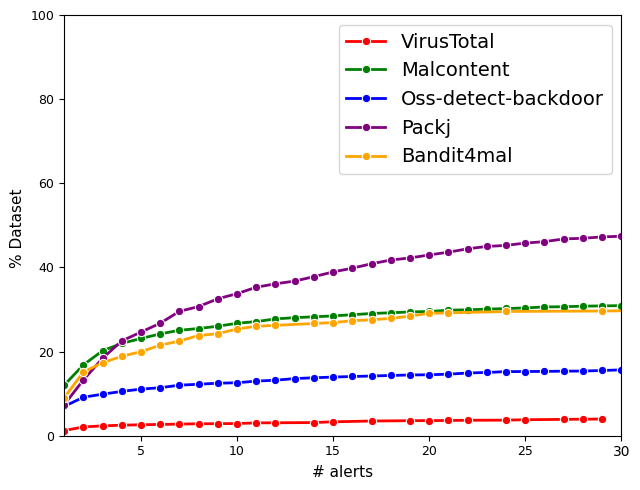

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Create the figure
plt.figure(figsize=(6.5, 5))

# --- VirusTotal Plot ---
# Calculate the total number of unique samples for VirusTotal
total_vt_samples = vt_pd['Package'].nunique()
# Group by '#AVs' and count samples, then calculate percentage
alert_counts_vt = vt_pd.groupby('#AVs')['Package'].count().reset_index()
# remove all row #Avs = 0
alert_counts_vt = alert_counts_vt[alert_counts_vt['#AVs'] > 0]
alert_counts_vt.columns = ['Number of Alerts', 'Number of Samples']
alert_counts_vt['Percentage of Dataset'] = (alert_counts_vt['Number of Samples'] / total_vt_samples) * 100
# Sort by 'Number of Alerts' and calculate CDF
alert_counts_vt = alert_counts_vt.sort_values('Number of Alerts')
alert_counts_vt['CDF'] = alert_counts_vt['Percentage of Dataset'].cumsum()
sns.lineplot(data=alert_counts_vt, x='Number of Alerts', y='CDF', label='VirusTotal', color='red', marker='o', linewidth=2) # Changed to lineplot with marker

# --- Malcontent Plot ---
# Calculate the total number of unique samples for Malcontent
total_bincapz_samples = malicious_benign_pd_bincapz['Package name'].nunique()
# Group by 'Number of Alerts' and count samples, then calculate percentage
alert_counts_bincapz = malicious_pd_bincapz.groupby('Number of Alerts')['Dataset'].count().reset_index()
alert_counts_bincapz.columns = ['Number of Alerts', 'Number of Samples']
alert_counts_bincapz['Percentage of Dataset'] = (alert_counts_bincapz['Number of Samples'] / total_bincapz_samples) * 100
# Sort by 'Number of Alerts' and calculate CDF
alert_counts_bincapz = alert_counts_bincapz.sort_values('Number of Alerts')
alert_counts_bincapz['CDF'] = alert_counts_bincapz['Percentage of Dataset'].cumsum()
sns.lineplot(data=alert_counts_bincapz, x='Number of Alerts', y='CDF', label='Malcontent', color='green', marker='o', linewidth=2) # Changed to lineplot with marker

# --- Oss-detect-backdoor Plot ---
# Calculate the total number of unique packages for Oss-detect-backdoor
total_odb_packages = malicious_benign_pd_odb['Package name'].nunique()
# Group by 'Number of Alerts' and count packages, then calculate percentage
alert_counts_odb = malicious_pd_odb.groupby('Number of Alerts')['Dataset'].count().reset_index()
alert_counts_odb.columns = ['Number of Alerts', 'Number of Packages']
alert_counts_odb['Percentage of Dataset'] = (alert_counts_odb['Number of Packages'] / total_odb_packages) * 100
# Sort by 'Number of Alerts' and calculate CDF
alert_counts_odb = alert_counts_odb.sort_values('Number of Alerts')
alert_counts_odb['CDF'] = alert_counts_odb['Percentage of Dataset'].cumsum()
sns.lineplot(data=alert_counts_odb, x='Number of Alerts', y='CDF', label='Oss-detect-backdoor', color='blue', marker='o', linewidth=2) # Changed to lineplot with marker

# --- Packj Plot ---
# Calculate the total number of unique packages for Packj
total_packj_packages = malicious_benign_pd_packj['Package name'].nunique()
# Group by 'Number of Alerts' and count packages, then calculate percentage
alert_counts_packj = malicious_pd_packj.groupby('Number of Alerts')['Dataset'].count().reset_index()
alert_counts_packj.columns = ['Number of Alerts', 'Number of Packages']
alert_counts_packj['Percentage of Dataset'] = (alert_counts_packj['Number of Packages'] / total_packj_packages) * 100
# Sort by 'Number of Alerts' and calculate CDF
alert_counts_packj = alert_counts_packj.sort_values('Number of Alerts')
alert_counts_packj['CDF'] = alert_counts_packj['Percentage of Dataset'].cumsum()
sns.lineplot(data=alert_counts_packj, x='Number of Alerts', y='CDF', label='Packj', color='purple', marker='o', linewidth=2) # Changed to lineplot with marker

# --- Bandit4mal Plot ---
# Calculate the total number of unique packages for Bandit4mal
total_bandit4mal_packages = malicious_benign_pd_bandit4mal['Package name'].nunique()
# Group by 'Number of Alerts' and count packages, then calculate percentage
alert_counts_bandit4mal = malicious_pd_bandit4mal.groupby('Number of Alerts')['Dataset'].count().reset_index()
alert_counts_bandit4mal.columns = ['Number of Alerts', 'Number of Packages']
alert_counts_bandit4mal['Percentage of Dataset'] = (alert_counts_bandit4mal['Number of Packages'] / total_bandit4mal_packages) * 100
# Sort by 'Number of Alerts' and calculate CDF
alert_counts_bandit4mal = alert_counts_bandit4mal.sort_values('Number of Alerts')
alert_counts_bandit4mal['CDF'] = alert_counts_bandit4mal['Percentage of Dataset'].cumsum()
sns.lineplot(data=alert_counts_bandit4mal, x='Number of Alerts', y='CDF', label='Bandit4mal', color='orange', marker='o', linewidth=2) # Changed to lineplot with marker


# Set the x-axis limits
max_alerts = max(
    alert_counts_vt['Number of Alerts'].max(),
    alert_counts_bincapz['Number of Alerts'].max(),
    alert_counts_odb['Number of Alerts'].max(),
    alert_counts_packj['Number of Alerts'].max(),
    alert_counts_bandit4mal['Number of Alerts'].max()
)
plt.xlim(0, max_alerts + 1) # Added some padding to the max_alerts

# Set labels and title
plt.xlabel('# alerts', fontsize=11)
plt.ylabel('% Dataset ', fontsize=11)

# Reduce fontsize for ticks
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

# Display the legend with increased font size
plt.legend(fontsize=14)

# Set y-axis limit for CDF
plt.ylim(0, 100) # CDF always goes from 0 to 100%
plt.xlim(1, 30)

# Show the plot
plt.tight_layout()
# Save to pdf
plt.savefig('CDF.pdf', format='pdf', bbox_inches='tight') # Changed filename
plt.show()

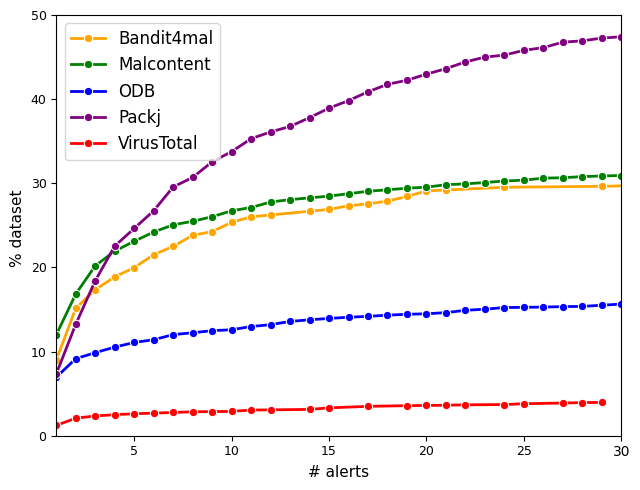

In [ ]:
# Create the figure
plt.figure(figsize=(6.5, 5))

# --- Bandit4mal Plot ---
# Calculate the total number of unique packages for Bandit4mal
total_bandit4mal_packages = malicious_benign_pd_bandit4mal['Package name'].nunique()
# Group by 'Number of Alerts' and count packages, then calculate percentage
alert_counts_bandit4mal = malicious_pd_bandit4mal.groupby('Number of Alerts')['Dataset'].count().reset_index()
alert_counts_bandit4mal.columns = ['Number of Alerts', 'Number of Packages']
alert_counts_bandit4mal['Percentage of Dataset'] = (alert_counts_bandit4mal['Number of Packages'] / total_bandit4mal_packages) * 100
# Sort by 'Number of Alerts' and calculate CDF
alert_counts_bandit4mal = alert_counts_bandit4mal.sort_values('Number of Alerts')
alert_counts_bandit4mal['CDF'] = alert_counts_bandit4mal['Percentage of Dataset'].cumsum()
sns.lineplot(data=alert_counts_bandit4mal, x='Number of Alerts', y='CDF', label='Bandit4mal', color='orange', marker='o', linewidth=2) # Changed to lineplot with marker

# --- Malcontent Plot ---
# Calculate the total number of unique samples for Malcontent
total_bincapz_samples = malicious_benign_pd_bincapz['Package name'].nunique()
# Group by 'Number of Alerts' and count samples, then calculate percentage
alert_counts_bincapz = malicious_pd_bincapz.groupby('Number of Alerts')['Dataset'].count().reset_index()
alert_counts_bincapz.columns = ['Number of Alerts', 'Number of Samples']
alert_counts_bincapz['Percentage of Dataset'] = (alert_counts_bincapz['Number of Samples'] / total_bincapz_samples) * 100
# Sort by 'Number of Alerts' and calculate CDF
alert_counts_bincapz = alert_counts_bincapz.sort_values('Number of Alerts')
alert_counts_bincapz['CDF'] = alert_counts_bincapz['Percentage of Dataset'].cumsum()
sns.lineplot(data=alert_counts_bincapz, x='Number of Alerts', y='CDF', label='Malcontent', color='green', marker='o', linewidth=2) # Changed to lineplot with marker

# --- ODB Plot ---
# Calculate the total number of unique packages for ODB
total_odb_packages = malicious_benign_pd_odb['Package name'].nunique()
# Group by 'Number of Alerts' and count packages, then calculate percentage
alert_counts_odb = malicious_pd_odb.groupby('Number of Alerts')['Dataset'].count().reset_index()
alert_counts_odb.columns = ['Number of Alerts', 'Number of Packages']
alert_counts_odb['Percentage of Dataset'] = (alert_counts_odb['Number of Packages'] / total_odb_packages) * 100
# Sort by 'Number of Alerts' and calculate CDF
alert_counts_odb = alert_counts_odb.sort_values('Number of Alerts')
alert_counts_odb['CDF'] = alert_counts_odb['Percentage of Dataset'].cumsum()
# Changed label from 'Oss-detect-backdoor' to 'ODB' as requested
sns.lineplot(data=alert_counts_odb, x='Number of Alerts', y='CDF', label='ODB', color='blue', marker='o', linewidth=2) # Changed to lineplot with marker

# --- Packj Plot ---
# Calculate the total number of unique packages for Packj
total_packj_packages = malicious_benign_pd_packj['Package name'].nunique()
# Group by 'Number of Alerts' and count packages, then calculate percentage
alert_counts_packj = malicious_pd_packj.groupby('Number of Alerts')['Dataset'].count().reset_index()
alert_counts_packj.columns = ['Number of Alerts', 'Number of Packages']
alert_counts_packj['Percentage of Dataset'] = (alert_counts_packj['Number of Packages'] / total_packj_packages) * 100
# Sort by 'Number of Alerts' and calculate CDF
alert_counts_packj = alert_counts_packj.sort_values('Number of Alerts')
alert_counts_packj['CDF'] = alert_counts_packj['Percentage of Dataset'].cumsum()
sns.lineplot(data=alert_counts_packj, x='Number of Alerts', y='CDF', label='Packj', color='purple', marker='o', linewidth=2) # Changed to lineplot with marker


# --- VirusTotal Plot ---
# Calculate the total number of unique samples for VirusTotal
total_vt_samples = vt_pd['Package'].nunique()
# Group by '#AVs' and count samples, then calculate percentage
alert_counts_vt = vt_pd.groupby('#AVs')['Package'].count().reset_index()
# remove all row #Avs = 0
alert_counts_vt = alert_counts_vt[alert_counts_vt['#AVs'] > 0]
alert_counts_vt.columns = ['Number of Alerts', 'Number of Samples']
alert_counts_vt['Percentage of Dataset'] = (alert_counts_vt['Number of Samples'] / total_vt_samples) * 100
# Sort by 'Number of Alerts' and calculate CDF
alert_counts_vt = alert_counts_vt.sort_values('Number of Alerts')
alert_counts_vt['CDF'] = alert_counts_vt['Percentage of Dataset'].cumsum()
sns.lineplot(data=alert_counts_vt, x='Number of Alerts', y='CDF', label='VirusTotal', color='red', marker='o', linewidth=2) # Changed to lineplot with marker



# Set the x-axis limits
max_alerts = max(
    alert_counts_vt['Number of Alerts'].max(),
    alert_counts_bincapz['Number of Alerts'].max(),
    alert_counts_odb['Number of Alerts'].max(),
    alert_counts_packj['Number of Alerts'].max(),
    alert_counts_bandit4mal['Number of Alerts'].max()
)
plt.xlim(0, max_alerts + 1) # Added some padding to the max_alerts

# Set labels and title
plt.xlabel('# alerts', fontsize=11)
plt.ylabel('% dataset ', fontsize=11)

# Reduce fontsize for ticks
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.legend(fontsize=12, loc='upper left')

# Set y-axis limit for CDF
plt.ylim(0, 50) # CDF always goes from 0 to 100%
plt.xlim(1, 30)

# Show the plot
plt.tight_layout()
# Save to pdf
plt.savefig('CDF.pdf', format='pdf', bbox_inches='tight') # Changed filename
plt.show()

# Distribution of generated alerts on the samples in the combined dataset

In [ ]:


# Function to calculate statistics
def calculate_statistics(df, count_column):
    stats = {
        'min': df[count_column].min(),
        'max': df[count_column].max(),
        'mean': df[count_column].mean(),
        'std_dev': df[count_column].std(),
        'Q25': df[count_column].quantile(0.25),
        'median': df[count_column].median(),
        'Q75': df[count_column].quantile(0.75)
    }
    return stats

# Calculate statistics and add tool identifier for each tool
# VirusTotal
alert_counts_vt = vt_pd.groupby('#AVs')['Package'].count().reset_index()
alert_counts_vt.columns = ['Number of Alerts', 'Number of Samples']
alert_counts_vt['Tool'] = 'VirusTotal'
vt_stats = calculate_statistics(alert_counts_vt, 'Number of Samples')

# Malcontent
alert_counts_malcontent = malicious_pd_bincapz.groupby('Number of Alerts')['Package name'].count().reset_index()
alert_counts_malcontent.columns = ['Number of Alerts', 'Number of Samples']
alert_counts_malcontent['Tool'] = 'Malcontent'
malcontent_stats = calculate_statistics(alert_counts_malcontent, 'Number of Samples')

# Oss-detect-backdoor
alert_counts_odb = malicious_pd_odb.groupby('Number of Alerts')['Package name'].count().reset_index()
alert_counts_odb.columns = ['Number of Alerts', 'Number of Samples']
alert_counts_odb['Tool'] = 'Oss-detect-backdoor'
odb_stats = calculate_statistics(alert_counts_odb, 'Number of Samples')

# Packj
alert_counts_packj = malicious_pd_packj.groupby('Number of Alerts')['Package name'].count().reset_index()
alert_counts_packj.columns = ['Number of Alerts', 'Number of Samples']
alert_counts_packj['Tool'] = 'Packj'
packj_stats = calculate_statistics(alert_counts_packj, 'Number of Samples')

# Bandit4mal
alert_counts_bandit4mal = malicious_pd_bandit4mal.groupby('Number of Alerts')['Package name'].count().reset_index()
alert_counts_bandit4mal.columns = ['Number of Alerts', 'Number of Samples']
alert_counts_bandit4mal['Tool'] = 'Bandit4mal'
bandit4mal_stats = calculate_statistics(alert_counts_bandit4mal, 'Number of Samples')

# Combine all tool DataFrames into one
combined_df = pd.concat([alert_counts_vt, alert_counts_malcontent, alert_counts_odb, alert_counts_packj, alert_counts_bandit4mal])

# Calculate statistics for the combined dataset
combined_stats = calculate_statistics(combined_df, 'Number of Samples')

# Create DataFrame for individual and combined statistics
stats_df = pd.DataFrame({
    'Tool': ['VirusTotal', 'Malcontent', 'Oss-detect-backdoor', 'Packj', 'Bandit4mal', 'Combined'],
    'Min': [vt_stats['min'], malcontent_stats['min'], odb_stats['min'], packj_stats['min'], bandit4mal_stats['min'], combined_stats['min']],
    'Max': [vt_stats['max'], malcontent_stats['max'], odb_stats['max'], packj_stats['max'], bandit4mal_stats['max'], combined_stats['max']],
    'Mean': [vt_stats['mean'], malcontent_stats['mean'], odb_stats['mean'], packj_stats['mean'], bandit4mal_stats['mean'], combined_stats['mean']],
    'Std Dev': [vt_stats['std_dev'], malcontent_stats['std_dev'], odb_stats['std_dev'], packj_stats['std_dev'], bandit4mal_stats['std_dev'], combined_stats['std_dev']],
    'Q25': [vt_stats['Q25'], malcontent_stats['Q25'], odb_stats['Q25'], packj_stats['Q25'], bandit4mal_stats['Q25'], combined_stats['Q25']],
    'Median': [vt_stats['median'], malcontent_stats['median'], odb_stats['median'], packj_stats['median'], bandit4mal_stats['median'], combined_stats['median']],
    'Q75': [vt_stats['Q75'], malcontent_stats['Q75'], odb_stats['Q75'], packj_stats['Q75'], bandit4mal_stats['Q75'], combined_stats['Q75']]
})

# Display the stats DataFrame
print(stats_df)


                  Tool  Min   Max        Mean     Std Dev  Q25  Median   Q75
0           VirusTotal    1  3695  153.880000  737.809614  1.0     3.0  6.00
1           Malcontent    1   461    9.000000   41.564345  1.0     1.5  3.00
2  Oss-detect-backdoor    1   253    2.465561    9.702804  1.0     1.0  2.00
3                Packj    1    91    5.206250   11.784809  1.0     1.5  4.00
4           Bandit4mal    1    82    8.108108   15.745870  1.0     3.0  7.00
5             Combined    1  3695    7.154310  109.868418  1.0     1.0  2.25


In [ ]:
stats_df.to_csv('stats_data.csv', index=False)

In [ ]:


# Function to calculate statistics
def calculate_statistics(df, count_column):
    stats = {
        'min': df[count_column].min(),
        'max': df[count_column].max(),
        'mean': df[count_column].mean(),
        'std_dev': df[count_column].std(),
        'Q25': df[count_column].quantile(0.25),
        'median': df[count_column].median(),
        'Q75': df[count_column].quantile(0.75)
    }
    return stats

# Calculate statistics and add tool identifier for each tool
# VirusTotal
alert_counts_vt = vt_pd.groupby('#AVs')['Package'].count().reset_index()
alert_counts_vt.columns = ['Number of Alerts', 'Number of Samples']
alert_counts_vt['Tool'] = 'VirusTotal'
vt_stats = calculate_statistics(alert_counts_vt, 'Number of Alerts')

# Malcontent
alert_counts_malcontent = malicious_pd_bincapz.groupby('Number of Alerts')['Package name'].count().reset_index()
alert_counts_malcontent.columns = ['Number of Alerts', 'Number of Samples']
alert_counts_malcontent['Tool'] = 'Malcontent'
malcontent_stats = calculate_statistics(alert_counts_malcontent, 'Number of Alerts')

# Oss-detect-backdoor
alert_counts_odb = malicious_pd_odb.groupby('Number of Alerts')['Package name'].count().reset_index()
alert_counts_odb.columns = ['Number of Alerts', 'Number of Samples']
alert_counts_odb['Tool'] = 'Oss-detect-backdoor'
odb_stats = calculate_statistics(alert_counts_odb, 'Number of Alerts')

# Packj
alert_counts_packj = malicious_pd_packj.groupby('Number of Alerts')['Package name'].count().reset_index()
alert_counts_packj.columns = ['Number of Alerts', 'Number of Samples']
alert_counts_packj['Tool'] = 'Packj'
packj_stats = calculate_statistics(alert_counts_packj, 'Number of Alerts')

# Bandit4mal
alert_counts_bandit4mal = malicious_pd_bandit4mal.groupby('Number of Alerts')['Package name'].count().reset_index()
alert_counts_bandit4mal.columns = ['Number of Alerts', 'Number of Samples']
alert_counts_bandit4mal['Tool'] = 'Bandit4mal'
bandit4mal_stats = calculate_statistics(alert_counts_bandit4mal, 'Number of Alerts')

# Combine all tool DataFrames into one
combined_df = pd.concat([alert_counts_vt, alert_counts_malcontent, alert_counts_odb, alert_counts_packj, alert_counts_bandit4mal])

# Calculate statistics for the combined dataset
combined_stats = calculate_statistics(combined_df, 'Number of Alerts')

# Create DataFrame for individual and combined statistics
stats_df = pd.DataFrame({
    'Tool': ['VirusTotal', 'Malcontent', 'Oss-detect-backdoor', 'Packj', 'Bandit4mal', 'Combined'],
    'Min': [vt_stats['min'], malcontent_stats['min'], odb_stats['min'], packj_stats['min'], bandit4mal_stats['min'], combined_stats['min']],
    'Max': [vt_stats['max'], malcontent_stats['max'], odb_stats['max'], packj_stats['max'], bandit4mal_stats['max'], combined_stats['max']],
    'Mean': [vt_stats['mean'], malcontent_stats['mean'], odb_stats['mean'], packj_stats['mean'], bandit4mal_stats['mean'], combined_stats['mean']],
    'Std Dev': [vt_stats['std_dev'], malcontent_stats['std_dev'], odb_stats['std_dev'], packj_stats['std_dev'], bandit4mal_stats['std_dev'], combined_stats['std_dev']],
    'Q25': [vt_stats['Q25'], malcontent_stats['Q25'], odb_stats['Q25'], packj_stats['Q25'], bandit4mal_stats['Q25'], combined_stats['Q25']],
    'Median': [vt_stats['median'], malcontent_stats['median'], odb_stats['median'], packj_stats['median'], bandit4mal_stats['median'], combined_stats['median']],
    'Q75': [vt_stats['Q75'], malcontent_stats['Q75'], odb_stats['Q75'], packj_stats['Q75'], bandit4mal_stats['Q75'], combined_stats['Q75']]
})

# Display the stats DataFrame
stats_df


,Tool,Min,Max,Mean,Std Dev,Q25,Median,Q75
0,VirusTotal,0,29,13.560000,9.138198,6.00,12.0,21.00
1,Malcontent,1,12957,406.168831,1692.645475,39.25,110.5,242.25
2,Oss-detect-backdoor,1,478611,3765.752551,23430.899183,210.75,628.5,1870.00
3,Packj,1,5706,225.581250,633.897532,40.75,94.0,212.00
4,Bandit4mal,1,191,39.324324,42.714201,10.00,20.0,57.00
5,Combined,0,478611,2631.712931,19339.663834,90.75,306.5,1079.75


# Combine ROC curve

In [ ]:
auc_vt = round(auc(fpr_list_vt, tpr_list_vt), 2)
auc_packj = round(auc(fpr_list_packj, tpr_list_packj), 2)
auc_bincapz = round(auc(fpr_list_bincapz, tpr_list_bincapz), 2)
auc_odb = round(auc(fpr_list_odb, tpr_list_odb), 2)
auc_bandit4mal = round(auc(fpr_list_bandit4mal, tpr_list_bandit4mal), 2)
df_auc_data = pd.DataFrame({
    'tool': ['VirusTotal', 'Packj', 'Bincapz', 'Oss-detect-backdoor', 'Bandit4mal'],
    'auc': [auc_vt, auc_packj, auc_bincapz, auc_odb, auc_bandit4mal]
})
df_auc_data.to_csv('combined_auc_data.csv', index=False)

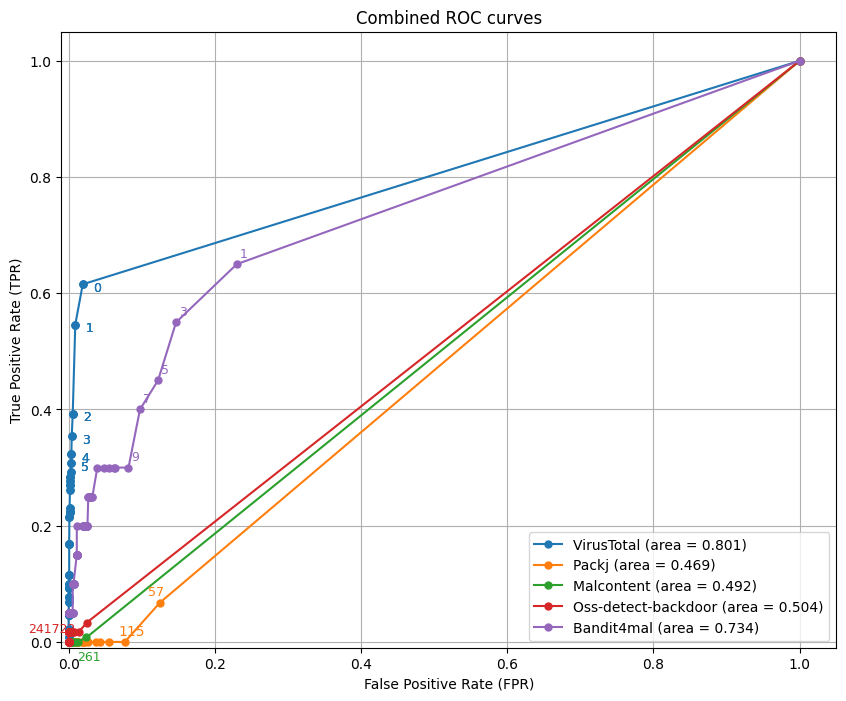

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc

# Define colors for each ROC curve
colors = {
    'VirusTotal': '#1f77b4',  # Blue
    'Packj': '#ff7f0e',       # Orange
    'Bincapz': '#2ca02c',     # Green
    'Oss-detect-backdoor': '#d62728',  # Red
    'Bandit4mal': '#9467bd'   # Purple
}

# Plot combined ROC curves
plt.figure(figsize=(10, 8))
SIZE = 150

# Plot ROC curve for VirusTotal
plt.plot(fpr_list_vt, tpr_list_vt, marker='o', markersize=5, color=colors['VirusTotal'], label='VirusTotal (area = {:.3f})'.format(round(auc(fpr_list_vt, tpr_list_vt), 3)))
for i, threshold in enumerate(thresholds_vt):
    if threshold != 0  and tpr_list_vt[i] > 0.3:
        plt.annotate(f'{int(threshold)}', (fpr_list_vt[i], tpr_list_vt[i]), textcoords="offset points", xytext=(10, -5), ha='center', fontsize=9, color=colors['VirusTotal'])
    # elif i % 50 == 0:
    #     plt.annotate(f'{int(threshold)}', (fpr_list_vt[i], tpr_list_vt[i]), textcoords="offset points", xytext=(10, -5), ha='center', fontsize=9, color=colors['VirusTotal'])

# Plot ROC curve for Packj
plt.plot(fpr_list_packj, tpr_list_packj, marker='o', markersize=5, color=colors['Packj'], label='Packj (area = {:.3f})'.format(round(auc(fpr_list_packj, tpr_list_packj), 3)))
for i, threshold in enumerate(thresholds_packj):
    if threshold != 0  and  fpr_list_packj[i] > 0.1:
        plt.annotate(f'{int(threshold)}', (fpr_list_packj[i], tpr_list_packj[i]), textcoords="offset points", xytext=(-3, 5), ha='center', fontsize=9, color=colors['Packj'])
    elif  threshold != 0  and fpr_list_packj[i] > 0.07 and i % 2 == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_packj[i], tpr_list_packj[i]), textcoords="offset points", xytext=(5, 5), ha='center', color=colors['Packj'])

# Plot ROC curve for Bincapz
plt.plot(fpr_list_bincapz, tpr_list_bincapz, marker='o', markersize=5, color=colors['Bincapz'], label='Malcontent (area = {:.3f})'.format(round(auc(fpr_list_bincapz, tpr_list_bincapz), 3)))
for i, threshold in enumerate(thresholds_bincapz):
    if threshold != 0  and fpr_list_bincapz[i] > 0.01 and i % 2 == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_bincapz[i], tpr_list_bincapz[i]), textcoords="offset points", xytext=(8,-13), ha='center', fontsize=9, color=colors['Bincapz'])
    elif threshold != 0  and i % SIZE == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_bincapz[i], tpr_list_bincapz[i]), textcoords="offset points", xytext=(8, -13), ha='center', fontsize=9, color=colors['Bincapz'])

# Plot ROC curve for Oss-detect-backdoor
plt.plot(fpr_list_odb, tpr_list_odb, marker='o', markersize=5, color=colors['Oss-detect-backdoor'], label='Oss-detect-backdoor (area = {:.3f})'.format(round(auc(fpr_list_odb, tpr_list_odb), 3)))
for i, threshold in enumerate(thresholds_odb):
    if threshold != 0  and i % 50 == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_odb[i], tpr_list_odb[i]), textcoords="offset points", xytext=(-12, 0), ha='center', fontsize=9, color=colors['Oss-detect-backdoor'])
    elif threshold != 0  and i % SIZE == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_odb[i], tpr_list_odb[i]), textcoords="offset points", xytext=(-10, 5), ha='center', fontsize=9, color=colors['Oss-detect-backdoor'])

# Plot ROC curve for Bandit4mal
plt.plot(fpr_list_bandit4mal, tpr_list_bandit4mal, marker='o', markersize=5, color=colors['Bandit4mal'], label='Bandit4mal (area = {:.3f})'.format(round(auc(fpr_list_bandit4mal, tpr_list_bandit4mal), 3)))
for i, threshold in enumerate(thresholds_bandit4mal):
    if threshold != 0  and fpr_list_bandit4mal[i] > 0.08:
        plt.annotate(f'{int(threshold)}', (fpr_list_bandit4mal[i], tpr_list_bandit4mal[i]), textcoords="offset points", xytext=(5,5), ha='center', fontsize=9, color=colors['Bandit4mal'])
    elif threshold != 0  and i % SIZE == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_bandit4mal[i], tpr_list_bandit4mal[i]), textcoords="offset points", xytext=(12, -5), ha='center', fontsize=9, color=colors['Bandit4mal'])

# plt.plot([0, 1], [0, 1], 'k--')

plt.xlim(-0.01, 1.05)
plt.ylim(-0.01, 1.05)

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Combined ROC curves')
plt.legend(loc='lower right')
plt.grid(True)

# Save the combined plot as an image (e.g., PNG format)
plt.savefig('ROC_curves_all.png', dpi=300, bbox_inches='tight')

# Show the combined plot
plt.show()


# Datset1 and upstream repos

## vt

In [ ]:


vt_pd['Label'] = vt_pd.apply(label_package, axis=1)
df = vt_pd[vt_pd['Dataset'].isin(["dataset1", "upstream-repos"])]

y_true = (df['Label'] == 'malicious').astype(int)
y_scores = df['#AVs']

# Create thresholds from 0 to max predicted value
thresholds_vt = np.linspace(0, y_scores.max(), 100)

tpr_list_vt = []
fpr_list_vt = []

# Calculate TPR and FPR for each threshold
for threshold in thresholds_vt:
    y_pred = (y_scores >= threshold).astype(int)  # Predictions based on threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate TPR and FPR
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

    tpr_list_vt.append(tpr)
    fpr_list_vt.append(fpr)

In [ ]:
df_dataset1_roc_vt = pd.DataFrame({
    'threshold': thresholds_vt,
    'tpr': tpr_list_vt,
    'fpr': fpr_list_vt
})
df_dataset1_roc_vt.to_csv('dataset1_roc_data_vt.csv', index=False)

## bincapz

In [ ]:

malicious_benign_pd_bincapz
df = malicious_benign_pd_bincapz[malicious_benign_pd_bincapz['Dataset'].isin(["dataset1", "upstream-repos"])]
# Convert the labels to 1 (malicious) and 0 (benign)




# Convert labels to binary values (1 for 'malicious', 0 otherwise)
y_true = (df['Label'] == 'malicious').astype(int)
y_scores = df['Number of Alerts']

# Create thresholds from 0 to max predicted value
thresholds_bincapz = np.linspace(0, y_scores.max(), 100)

# Initialize lists to store TPR and FPR
tpr_list_bincapz = []
fpr_list_bincapz = []

# Calculate TPR and FPR for each threshold
for threshold in thresholds_bincapz:
    y_pred = (y_scores >= threshold).astype(int)  # Predictions based on threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate TPR and FPR
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

    tpr_list_bincapz.append(tpr)
    fpr_list_bincapz.append(fpr)

In [ ]:
df_dataset1_roc_bincapz = pd.DataFrame({
    'threshold': thresholds_bincapz,
    'tpr': tpr_list_bincapz,
    'fpr': fpr_list_bincapz
})
df_dataset1_roc_bincapz.to_csv('dataset1_roc_data_bincapz.csv', index=False)

## OSS detect-backdoor

In [ ]:
df = malicious_benign_pd_odb[malicious_benign_pd_odb['Dataset'].isin(["dataset1", "upstream-repos"])]
# Convert labels to binary values (1 for 'malicious', 0 otherwise)
y_true = (df['Label'] == 'malicious').astype(int)
y_scores = df['Number of Alerts']

# Create thresholds from 0 to max predicted value
thresholds_odb = np.linspace(0, y_scores.max(), 100)

# Initialize lists to store TPR and FPR
tpr_list_odb = []
fpr_list_odb = []

# Calculate TPR and FPR for each threshold
for threshold in thresholds_odb:
    y_pred = (y_scores >= threshold).astype(int)  # Predictions based on threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate TPR and FPR
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

    tpr_list_odb.append(tpr)
    fpr_list_odb.append(fpr)

In [ ]:
df_dataset1_odb = pd.DataFrame({
    'threshold': thresholds_odb,
    'tpr': tpr_list_odb,
    'fpr': fpr_list_odb
})
df_dataset1_odb.to_csv('dataset1_roc_data_odb.csv', index=False)

## packj

In [ ]:


df = malicious_benign_pd_packj[malicious_benign_pd_packj['Dataset'].isin(["dataset1", "upstream-repos"])]
# Convert labels to binary values (1 for 'malicious', 0 otherwise)
y_true = (df['Label'] == 'malicious').astype(int)
y_scores = df['Number of Alerts']

# Create thresholds from 0 to max predicted value
thresholds_packj = np.linspace(0, y_scores.max(), 100)

# Initialize lists to store TPR and FPR
tpr_list_packj = []
fpr_list_packj = []

# Calculate TPR and FPR for each threshold
for threshold in thresholds_packj:
    y_pred = (y_scores >= threshold).astype(int)  # Predictions based on threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate TPR and FPR
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

    tpr_list_packj.append(tpr)
    fpr_list_packj.append(fpr)


In [ ]:
df_dataset1_packj = pd.DataFrame({
    'threshold': thresholds_packj,
    'tpr': tpr_list_packj,
    'fpr': fpr_list_packj
})
df_dataset1_packj.to_csv('dataset1_roc_data_packj.csv', index=False)

## bandit4mal

In [ ]:
df = malicious_benign_pd_bandit4mal[malicious_benign_pd_bandit4mal['Dataset'].isin(["dataset1", "upstream-repos"])]

tpr_list_bandit4mal = []
fpr_list_bandit4mal = []

# Convert labels to binary values (1 for 'malicious', 0 otherwise)
y_true = (df['Label'] == 'malicious').astype(int)
y_scores = df['Number of Alerts']

# Create thresholds from 0 to max predicted value
thresholds_bandit4mal = np.linspace(0, y_scores.max(), 100)

# Calculate TPR and FPR for each threshold
for threshold in thresholds_bandit4mal:
    y_pred = (y_scores >= threshold).astype(int)  # Predictions based on threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate TPR and FPR
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

    tpr_list_bandit4mal.append(tpr)
    fpr_list_bandit4mal.append(fpr)

In [ ]:
df_dataset1_bandit4mal = pd.DataFrame({
    'threshold': thresholds_bandit4mal,
    'tpr': tpr_list_bandit4mal,
    'fpr': fpr_list_bandit4mal
})
df_dataset1_bandit4mal.to_csv('dataset1_roc_data_bandit4mal.csv', index=False)

## ROC AUC

In [ ]:
auc_vt = round(auc(fpr_list_vt, tpr_list_vt), 2)
auc_packj = round(auc(fpr_list_packj, tpr_list_packj), 2)
auc_bincapz = round(auc(fpr_list_bincapz, tpr_list_bincapz), 2)
auc_odb = round(auc(fpr_list_odb, tpr_list_odb), 2)
auc_bandit4mal = round(auc(fpr_list_bandit4mal, tpr_list_bandit4mal), 2)
df_auc_data = pd.DataFrame({
    'tool': ['VirusTotal', 'Packj', 'Bincapz', 'Oss-detect-backdoor', 'Bandit4mal'],
    'auc': [auc_vt, auc_packj, auc_bincapz, auc_odb, auc_bandit4mal]
})
df_auc_data.to_csv('dataset1_auc_data.csv', index=False)

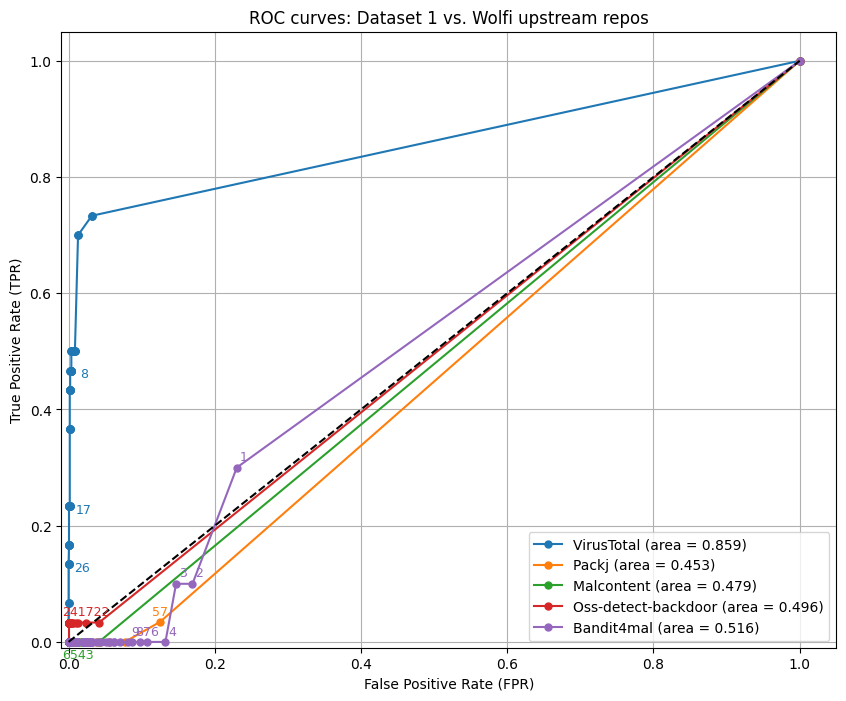

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc

# Define colors for each ROC curve
colors = {
    'VirusTotal': '#1f77b4',  # Blue
    'Packj': '#ff7f0e',       # Orange
    'Bincapz': '#2ca02c',     # Green
    'Oss-detect-backdoor': '#d62728',  # Red
    'Bandit4mal': '#9467bd'   # Purple
}

# Plot combined ROC curves
plt.figure(figsize=(10, 8))
SIZE = 120

# Plot ROC curve for VirusTotal
plt.plot(fpr_list_vt, tpr_list_vt, marker='o', markersize=5, color=colors['VirusTotal'], label='VirusTotal (area = {:.3f})'.format(round(auc(fpr_list_vt, tpr_list_vt), 3)))
for i, threshold in enumerate(thresholds_vt):
    if threshold != 0  and fpr_list_vt[i] > 0.2 and i % 20 == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_vt[i], tpr_list_vt[i]), textcoords="offset points", xytext=(10, -5), ha='center', fontsize=9, color=colors['VirusTotal'])
    elif threshold != 0  and i % 30 == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_vt[i], tpr_list_vt[i]), textcoords="offset points", xytext=(10, -5), ha='center', fontsize=9, color=colors['VirusTotal'])

# Plot ROC curve for Packj
plt.plot(fpr_list_packj, tpr_list_packj, marker='o', markersize=5, color=colors['Packj'], label='Packj (area = {:.3f})'.format(round(auc(fpr_list_packj, tpr_list_packj), 3)))
for i, threshold in enumerate(thresholds_packj):
    if threshold != 0  and  fpr_list_packj[i] > 0.1 :
        plt.annotate(f'{int(threshold)}', (fpr_list_packj[i], tpr_list_packj[i]), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=9, color=colors['Packj'])
    elif threshold != 0  and i % SIZE == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_packj[i], tpr_list_packj[i]), textcoords="offset points", xytext=(0, 5), ha='center', color=colors['Packj'])

# Plot ROC curve for Bincapz
plt.plot(fpr_list_bincapz, tpr_list_bincapz, marker='o', markersize=5, color=colors['Bincapz'], label='Malcontent (area = {:.3f})'.format(round(auc(fpr_list_bincapz, tpr_list_bincapz), 3)))
for i, threshold in enumerate(thresholds_bincapz):
    if  threshold != 0  and i % 50 == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_bincapz[i], tpr_list_bincapz[i]), textcoords="offset points", xytext=(5,-12), ha='center', fontsize=9, color=colors['Bincapz'])
    elif threshold != 0  and i % SIZE == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_bincapz[i], tpr_list_bincapz[i]), textcoords="offset points", xytext=(5, -12), ha='center', fontsize=9, color=colors['Bincapz'])

# Plot ROC curve for Oss-detect-backdoor
plt.plot(fpr_list_odb, tpr_list_odb, marker='o', markersize=5, color=colors['Oss-detect-backdoor'], label='Oss-detect-backdoor (area = {:.3f})'.format(round(auc(fpr_list_odb, tpr_list_odb), 3)))
for i, threshold in enumerate(thresholds_odb):
    if threshold != 0  and tpr_list_odb[i] > 0.01 and i % 50 == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_odb[i], tpr_list_odb[i]), textcoords="offset points", xytext=(12, 5), ha='center', fontsize=9, color=colors['Oss-detect-backdoor'])
    elif threshold != 0  and  i % SIZE == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_odb[i], tpr_list_odb[i]), textcoords="offset points", xytext=(-10, 5), ha='center', fontsize=9, color=colors['Oss-detect-backdoor'])

# Plot ROC curve for Bandit4mal
plt.plot(fpr_list_bandit4mal, tpr_list_bandit4mal, marker='o', markersize=5, color=colors['Bandit4mal'], label='Bandit4mal (area = {:.3f})'.format(round(auc(fpr_list_bandit4mal, tpr_list_bandit4mal), 3)))
for i, threshold in enumerate(thresholds_bandit4mal):
    if threshold != 0  and fpr_list_bandit4mal[i] > 0.08:
        plt.annotate(f'{int(threshold)}', (fpr_list_bandit4mal[i], tpr_list_bandit4mal[i]), textcoords="offset points", xytext=(5,5), ha='center', fontsize=9, color=colors['Bandit4mal'])
    elif threshold != 0  and i % SIZE == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_bandit4mal[i], tpr_list_bandit4mal[i]), textcoords="offset points", xytext=(12, -5), ha='center', fontsize=9, color=colors['Bandit4mal'])

plt.plot([0, 1], [0, 1], 'k--')

plt.xlim(-0.01, 1.05)
plt.ylim(-0.01, 1.05)

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curves: Dataset 1 vs. Wolfi upstream repos')
plt.legend(loc='lower right')
plt.grid(True)

# Save the combined plot as an image (e.g., PNG format)
plt.savefig('ROC_curves_Dataset_1_vs_Wolfi_upstream_repos.png', dpi=300, bbox_inches='tight')

# Show the combined plot
plt.show()


# Dataset4 and upstream-repos

## VT

In [ ]:

vt_pd['Label'] = vt_pd.apply(label_package, axis=1)
df = vt_pd[vt_pd['Dataset'].isin(["dataset4", "upstream-repos"])]

y_true = (df['Label'] == 'malicious').astype(int)
y_scores = df['#AVs']

# Create thresholds from 0 to max predicted value
thresholds_vt = np.linspace(0, y_scores.max(), 100)

tpr_list_vt = []
fpr_list_vt = []

# Calculate TPR and FPR for each threshold
for threshold in thresholds_vt:
    y_pred = (y_scores >= threshold).astype(int)  # Predictions based on threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate TPR and FPR
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

    tpr_list_vt.append(tpr)
    fpr_list_vt.append(fpr)

In [ ]:
df_dataset4_roc_vt = pd.DataFrame({
    'threshold': thresholds_vt,
    'tpr': tpr_list_vt,
    'fpr': fpr_list_vt
})
df_dataset4_roc_vt.to_csv('dataset4_roc_data_vt.csv', index=False)

## bincapz

In [ ]:

df = malicious_benign_pd_bincapz [malicious_benign_pd_bincapz['Dataset'].isin(["dataset4", "upstream-repos"])]
# Convert the labels to 1 (malicious) and 0 (benign)




# Convert labels to binary values (1 for 'malicious', 0 otherwise)
y_true = (df['Label'] == 'malicious').astype(int)
y_scores = df['Number of Alerts']

# Create thresholds from 0 to max predicted value
thresholds_bincapz = np.linspace(0, y_scores.max(), 100)

# Initialize lists to store TPR and FPR
tpr_list_bincapz = []
fpr_list_bincapz = []

# Calculate TPR and FPR for each threshold
for threshold in thresholds_bincapz:
    y_pred = (y_scores >= threshold).astype(int)  # Predictions based on threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate TPR and FPR
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

    tpr_list_bincapz.append(tpr)
    fpr_list_bincapz.append(fpr)

In [ ]:
df_dataset4_roc_bincapz = pd.DataFrame({
    'threshold': thresholds_bincapz,
    'tpr': tpr_list_bincapz,
    'fpr': fpr_list_bincapz
})
df_dataset4_roc_bincapz.to_csv('dataset4_roc_data_bincapz.csv', index=False)

## OSS-detect-backdoor

In [ ]:
df = malicious_benign_pd_odb[malicious_benign_pd_odb['Dataset'].isin(["dataset4", "upstream-repos"])]
# Convert labels to binary values (1 for 'malicious', 0 otherwise)
y_true = (df['Label'] == 'malicious').astype(int)
y_scores = df['Number of Alerts']

# Create thresholds from 0 to max predicted value
thresholds_odb = np.linspace(0, y_scores.max(), 100)

# Initialize lists to store TPR and FPR
tpr_list_odb = []
fpr_list_odb = []

# Calculate TPR and FPR for each threshold
for threshold in thresholds_odb:
    y_pred = (y_scores >= threshold).astype(int)  # Predictions based on threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate TPR and FPR
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

    tpr_list_odb.append(tpr)
    fpr_list_odb.append(fpr)

In [ ]:
df_dataset4_roc_odb = pd.DataFrame({
    'threshold': thresholds_odb,
    'tpr': tpr_list_odb,
    'fpr': fpr_list_odb
})
df_dataset4_roc_odb.to_csv('dataset4_roc_data_odb.csv', index=False)

## packj

In [ ]:


df = malicious_benign_pd_packj[malicious_benign_pd_packj['Dataset'].isin(["dataset4", "upstream-repos"])]
# Convert labels to binary values (1 for 'malicious', 0 otherwise)
y_true = (df['Label'] == 'malicious').astype(int)
y_scores = df['Number of Alerts']

# Create thresholds from 0 to max predicted value
thresholds_packj = np.linspace(0, y_scores.max(), 100)

# Initialize lists to store TPR and FPR
tpr_list_packj = []
fpr_list_packj = []

# Calculate TPR and FPR for each threshold
for threshold in thresholds_packj:
    y_pred = (y_scores >= threshold).astype(int)  # Predictions based on threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate TPR and FPR
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

    tpr_list_packj.append(tpr)
    fpr_list_packj.append(fpr)


In [ ]:
df_dataset4_roc_packj = pd.DataFrame({
    'threshold': thresholds_packj,
    'tpr': tpr_list_packj,
    'fpr': fpr_list_packj
})
df_dataset4_roc_packj.to_csv('dataset4_roc_data_packj.csv', index=False)

## bandit4mal

In [ ]:
df = malicious_benign_pd_bandit4mal[malicious_benign_pd_bandit4mal['Dataset'].isin(["dataset4", "upstream-repos"])]

tpr_list_bandit4mal = []
fpr_list_bandit4mal = []

# Convert labels to binary values (1 for 'malicious', 0 otherwise)
y_true = (df['Label'] == 'malicious').astype(int)
y_scores = df['Number of Alerts']

# Create thresholds from 0 to max predicted value
thresholds_bandit4mal = np.linspace(0, y_scores.max(), 100)

# Calculate TPR and FPR for each threshold
for threshold in thresholds_bandit4mal:
    y_pred = (y_scores >= threshold).astype(int)  # Predictions based on threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate TPR and FPR
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

    tpr_list_bandit4mal.append(tpr)
    fpr_list_bandit4mal.append(fpr)

In [ ]:
df_dataset4_roc_bandit4mal = pd.DataFrame({
    'threshold': thresholds_bandit4mal,
    'tpr': tpr_list_bandit4mal,
    'fpr': fpr_list_bandit4mal
})
df_dataset4_roc_bandit4mal.to_csv('dataset4_roc_data_bandit4mal.csv', index=False)

## ROC AUC

In [ ]:
auc_vt = round(auc(fpr_list_vt, tpr_list_vt), 2)
auc_packj = round(auc(fpr_list_packj, tpr_list_packj), 2)
auc_bincapz = round(auc(fpr_list_bincapz, tpr_list_bincapz), 2)
auc_odb = round(auc(fpr_list_odb, tpr_list_odb), 2)
auc_bandit4mal = round(auc(fpr_list_bandit4mal, tpr_list_bandit4mal), 2)
df_auc_data = pd.DataFrame({
    'tool': ['VirusTotal', 'Packj', 'Bincapz', 'Oss-detect-backdoor', 'Bandit4mal'],
    'auc': [auc_vt, auc_packj, auc_bincapz, auc_odb, auc_bandit4mal]
})
df_auc_data.to_csv('dataset4_auc_data.csv', index=False)

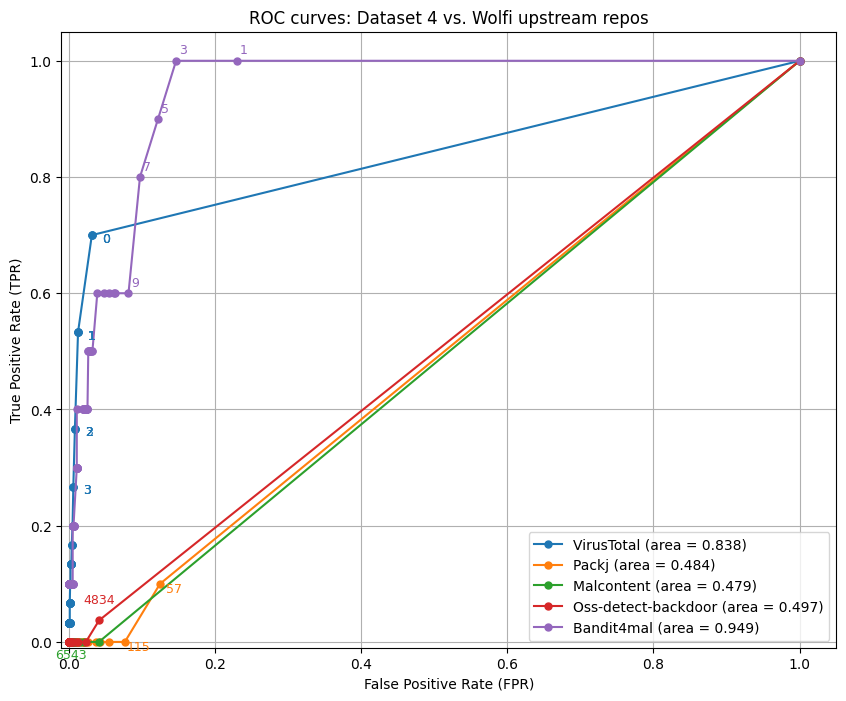

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc

# Define colors for each ROC curve
colors = {
    'VirusTotal': '#1f77b4',  # Blue
    'Packj': '#ff7f0e',       # Orange
    'Bincapz': '#2ca02c',     # Green
    'Oss-detect-backdoor': '#d62728',  # Red
    'Bandit4mal': '#9467bd'   # Purple
}

# Plot combined ROC curves
plt.figure(figsize=(10, 8))
SIZE = 150

# Plot ROC curve for VirusTotal
plt.plot(fpr_list_vt, tpr_list_vt, marker='o', markersize=5, color=colors['VirusTotal'], label='VirusTotal (area = {:.3f})'.format(round(auc(fpr_list_vt, tpr_list_vt), 3)))
for i, threshold in enumerate(thresholds_vt):
    if threshold != 0  and tpr_list_vt[i] > 0.2:
        plt.annotate(f'{int(threshold)}', (fpr_list_vt[i], tpr_list_vt[i]), textcoords="offset points", xytext=(10, -5), ha='center', fontsize=9, color=colors['VirusTotal'])
    # elif i % 50 == 0:
    #     plt.annotate(f'{int(threshold)}', (fpr_list_vt[i], tpr_list_vt[i]), textcoords="offset points", xytext=(10, -5), ha='center', fontsize=9, color=colors['VirusTotal'])

# Plot ROC curve for Packj
plt.plot(fpr_list_packj, tpr_list_packj, marker='o', markersize=5, color=colors['Packj'], label='Packj (area = {:.3f})'.format(round(auc(fpr_list_packj, tpr_list_packj), 3)))
for i, threshold in enumerate(thresholds_packj):
    if threshold != 0  and fpr_list_packj[i] > 0.07:
        plt.annotate(f'{int(threshold)}', (fpr_list_packj[i], tpr_list_packj[i]), textcoords="offset points", xytext=(10, -6), ha='center', fontsize=9, color=colors['Packj'])
    elif threshold != 0  and  i % 200 == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_packj[i], tpr_list_packj[i]), textcoords="offset points", xytext=(0, 5), ha='center', color=colors['Packj'])

# Plot ROC curve for Bincapz
plt.plot(fpr_list_bincapz, tpr_list_bincapz, marker='o', markersize=5, color=colors['Bincapz'], label='Malcontent (area = {:.3f})'.format(round(auc(fpr_list_bincapz, tpr_list_bincapz), 3)))
for i, threshold in enumerate(thresholds_bincapz):
    if threshold != 0  and i % 50 == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_bincapz[i], tpr_list_bincapz[i]), textcoords="offset points", xytext=(0,-12), ha='center', fontsize=9, color=colors['Bincapz'])
    elif threshold != 0  and i % SIZE == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_bincapz[i], tpr_list_bincapz[i]), textcoords="offset points", xytext=(8, -13), ha='center', fontsize=9, color=colors['Bincapz'])

# Plot ROC curve for Oss-detect-backdoor
plt.plot(fpr_list_odb, tpr_list_odb, marker='o', markersize=5, color=colors['Oss-detect-backdoor'], label='Oss-detect-backdoor (area = {:.3f})'.format(round(auc(fpr_list_odb, tpr_list_odb), 3)))
for i, threshold in enumerate(thresholds_odb):
    if threshold != 0  and tpr_list_odb[i] > 0.01:
        plt.annotate(f'{int(threshold)}', (fpr_list_odb[i], tpr_list_odb[i]), textcoords="offset points", xytext=(0, 12), ha='center', fontsize=9, color=colors['Oss-detect-backdoor'])
    elif threshold != 0  and i % SIZE == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_odb[i], tpr_list_odb[i]), textcoords="offset points", xytext=(-10, 5), ha='center', fontsize=9, color=colors['Oss-detect-backdoor'])

# Plot ROC curve for Bandit4mal
plt.plot(fpr_list_bandit4mal, tpr_list_bandit4mal, marker='o', markersize=5, color=colors['Bandit4mal'], label='Bandit4mal (area = {:.3f})'.format(round(auc(fpr_list_bandit4mal, tpr_list_bandit4mal), 3)))
for i, threshold in enumerate(thresholds_bandit4mal):
    if threshold != 0  and fpr_list_bandit4mal[i] > 0.08:
        plt.annotate(f'{int(threshold)}', (fpr_list_bandit4mal[i], tpr_list_bandit4mal[i]), textcoords="offset points", xytext=(5,5), ha='center', fontsize=9, color=colors['Bandit4mal'])
    elif threshold != 0  and i % SIZE == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_bandit4mal[i], tpr_list_bandit4mal[i]), textcoords="offset points", xytext=(12, -5), ha='center', fontsize=9, color=colors['Bandit4mal'])

# plt.plot([0, 1], [0, 1], 'k--')

plt.xlim(-0.01, 1.05)
plt.ylim(-0.01, 1.05)

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curves: Dataset 4 vs. Wolfi upstream repos')
plt.legend(loc='lower right')
plt.grid(True)

# Save the combined plot as an image (e.g., PNG format)
plt.savefig('ROC_curves_Dataset_4_vs_Wolfi_upstream_repos.png', dpi=300, bbox_inches='tight')

# Show the combined plot
plt.show()


# Dataset2 and wolfi-apks

## VT

In [ ]:



vt_pd['Label'] = vt_pd.apply(label_package, axis=1)
df = vt_pd[vt_pd['Dataset'].isin(["dataset2", "wolfi-apks"])]

y_true = (df['Label'] == 'malicious').astype(int)
y_scores = df['#AVs']

# Create thresholds from 0 to max predicted value
thresholds_vt = np.linspace(0, y_scores.max(), 100)

tpr_list_vt = []
fpr_list_vt = []

# Calculate TPR and FPR for each threshold
for threshold in thresholds_vt:
    y_pred = (y_scores >= threshold).astype(int)  # Predictions based on threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate TPR and FPR
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

    tpr_list_vt.append(tpr)
    fpr_list_vt.append(fpr)

In [ ]:
df_dataset2_roc_vt = pd.DataFrame({
    'threshold': thresholds_vt,
    'tpr': tpr_list_vt,
    'fpr': fpr_list_vt
})
df_dataset2_roc_vt.to_csv('dataset2_roc_data_vt.csv', index=False)

## malcontent

In [ ]:

df = malicious_benign_pd_bincapz [malicious_benign_pd_bincapz['Dataset'].isin(["dataset2", 'wolfi-apks'])]
# Convert the labels to 1 (malicious) and 0 (benign)




# Convert labels to binary values (1 for 'malicious', 0 otherwise)
y_true = (df['Label'] == 'malicious').astype(int)
y_scores = df['Number of Alerts']

# Create thresholds from 0 to max predicted value
thresholds_bincapz = np.linspace(0, y_scores.max(), 100)

# Initialize lists to store TPR and FPR
tpr_list_bincapz = []
fpr_list_bincapz = []

# Calculate TPR and FPR for each threshold
for threshold in thresholds_bincapz:
    y_pred = (y_scores >= threshold).astype(int)  # Predictions based on threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate TPR and FPR
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

    tpr_list_bincapz.append(tpr)
    fpr_list_bincapz.append(fpr)

In [ ]:
df_dataset2_roc_bincapz = pd.DataFrame({
    'threshold': thresholds_bincapz,
    'tpr': tpr_list_bincapz,
    'fpr': fpr_list_bincapz
})
df_dataset2_roc_bincapz.to_csv('dataset2_roc_data_bincapz.csv', index=False)

## oss-detect-backdoor

In [ ]:
df = malicious_benign_pd_odb[malicious_benign_pd_odb['Dataset'].isin(["dataset2", 'wolfi-apks'])]
# Convert labels to binary values (1 for 'malicious', 0 otherwise)
y_true = (df['Label'] == 'malicious').astype(int)
y_scores = df['Number of Alerts']

# Create thresholds from 0 to max predicted value
thresholds_odb = np.linspace(0, y_scores.max(), 100)

# Initialize lists to store TPR and FPR
tpr_list_odb = []
fpr_list_odb = []

# Calculate TPR and FPR for each threshold
for threshold in thresholds_odb:
    y_pred = (y_scores >= threshold).astype(int)  # Predictions based on threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate TPR and FPR
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

    tpr_list_odb.append(tpr)
    fpr_list_odb.append(fpr)

In [ ]:
df_dataset2_roc_odb = pd.DataFrame({
    'threshold': thresholds_odb,
    'tpr': tpr_list_odb,
    'fpr': fpr_list_odb
})
df_dataset2_roc_odb.to_csv('dataset2_roc_data_odb.csv', index=False)

## ROC auc

In [ ]:
auc_vt = round(auc(fpr_list_vt, tpr_list_vt), 2)
auc_bincapz = round(auc(fpr_list_bincapz, tpr_list_bincapz), 2)
auc_odb = round(auc(fpr_list_odb, tpr_list_odb), 2)
df_auc_data = pd.DataFrame({
    'tool': ['VirusTotal', 'Bincapz', 'Oss-detect-backdoor'],
    'auc': [auc_vt, auc_bincapz, auc_odb]
})
df_auc_data.to_csv('dataset2_auc_data.csv', index=False)

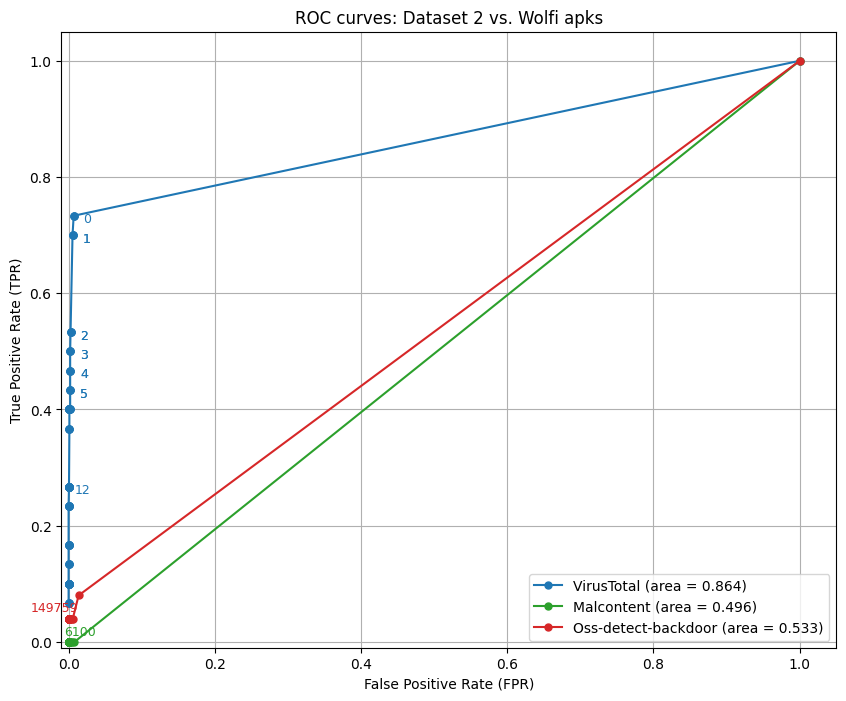

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc

# Define colors for each ROC curve
colors = {
    'VirusTotal': '#1f77b4',  # Blue
    'Packj': '#ff7f0e',       # Orange
    'Bincapz': '#2ca02c',     # Green
    'Oss-detect-backdoor': '#d62728',  # Red
    'Bandit4mal': '#9467bd'   # Purple
}

# Plot combined ROC curves
plt.figure(figsize=(10, 8))
SIZE = 300

# Plot ROC curve for VirusTotal
plt.plot(fpr_list_vt, tpr_list_vt, marker='o', markersize=5, color=colors['VirusTotal'], label='VirusTotal (area = {:.3f})'.format(round(auc(fpr_list_vt, tpr_list_vt), 3)))
for i, threshold in enumerate(thresholds_vt):
    if threshold != 0  and tpr_list_vt[i] > 0.4 and i % 2 == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_vt[i], tpr_list_vt[i]), textcoords="offset points", xytext=(10, -5), ha='center', fontsize=9, color=colors['VirusTotal'])
    elif threshold != 0  and  i % 50 == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_vt[i], tpr_list_vt[i]), textcoords="offset points", xytext=(10, -5), ha='center', fontsize=9, color=colors['VirusTotal'])


# Plot ROC curve for Bincapz
plt.plot(fpr_list_bincapz, tpr_list_bincapz, marker='o', markersize=5, color=colors['Bincapz'], label='Malcontent (area = {:.3f})'.format(round(auc(fpr_list_bincapz, tpr_list_bincapz), 3)))
for i, threshold in enumerate(thresholds_bincapz):
    if threshold != 0  and tpr_list_bincapz[i] < 0.2 and i % 50 == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_bincapz[i], tpr_list_bincapz[i]), textcoords="offset points", xytext=(8,5), ha='center', fontsize=9, color=colors['Bincapz'])
    elif threshold != 0  and  i % 100 == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_bincapz[i], tpr_list_bincapz[i]), textcoords="offset points", xytext=(8, -13), ha='center', fontsize=9, color=colors['Bincapz'])

# Plot ROC curve for Oss-detect-backdoor
plt.plot(fpr_list_odb, tpr_list_odb, marker='o', markersize=5, color=colors['Oss-detect-backdoor'], label='Oss-detect-backdoor (area = {:.3f})'.format(round(auc(fpr_list_odb, tpr_list_odb), 3)))
for i, threshold in enumerate(thresholds_odb):
    if threshold != 0  and tpr_list_odb[i] > 0.05 and i % 2 == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_odb[i], tpr_list_odb[i]), textcoords="offset points", xytext=(20, 5), ha='center', fontsize=9, color=colors['Oss-detect-backdoor'])
    elif threshold != 0  and  i % 50 == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_odb[i], tpr_list_odb[i]), textcoords="offset points", xytext=(-10, 5), ha='center', fontsize=9, color=colors['Oss-detect-backdoor'])


# plt.plot([0, 1], [0, 1], 'k--')

plt.xlim(-0.01, 1.05)
plt.ylim(-0.01, 1.05)

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curves: Dataset 2 vs. Wolfi apks')
plt.legend(loc='lower right')
plt.grid(True)

# Save the combined plot as an image (e.g., PNG format)
plt.savefig('ROC_curves_Dataset_2_vs_Wolfi_apks.png', dpi=300, bbox_inches='tight')

# Show the combined plot
plt.show()


# Dataset3 and wolfi apks

## VT

In [ ]:



vt_pd['Label'] = vt_pd.apply(label_package, axis=1)
df = vt_pd[vt_pd['Dataset'].isin(["dataset3", "wolfi-apks"])]

y_true = (df['Label'] == 'malicious').astype(int)
y_scores = df['#AVs']

# Create thresholds from 0 to max predicted value
thresholds_vt = np.linspace(0, y_scores.max(), 100)

tpr_list_vt = []
fpr_list_vt = []

# Calculate TPR and FPR for each threshold
for threshold in thresholds_vt:
    y_pred = (y_scores >= threshold).astype(int)  # Predictions based on threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate TPR and FPR
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

    tpr_list_vt.append(tpr)
    fpr_list_vt.append(fpr)

In [ ]:
df_dataset3_roc_vt = pd.DataFrame({
    'threshold': thresholds_vt,
    'tpr': tpr_list_vt,
    'fpr': fpr_list_vt
})
df_dataset3_roc_vt.to_csv('dataset3_roc_data_vt.csv', index=False)

## malcontent

In [ ]:

df = malicious_benign_pd_bincapz [malicious_benign_pd_bincapz['Dataset'].isin(["dataset3", 'wolfi-apks'])]
# Convert the labels to 1 (malicious) and 0 (benign)




# Convert labels to binary values (1 for 'malicious', 0 otherwise)
y_true = (df['Label'] == 'malicious').astype(int)
y_scores = df['Number of Alerts']

# Create thresholds from 0 to max predicted value
thresholds_bincapz = np.linspace(0, y_scores.max(), 100)

# Initialize lists to store TPR and FPR
tpr_list_bincapz = []
fpr_list_bincapz = []

# Calculate TPR and FPR for each threshold
for threshold in thresholds_bincapz:
    y_pred = (y_scores >= threshold).astype(int)  # Predictions based on threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate TPR and FPR
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

    tpr_list_bincapz.append(tpr)
    fpr_list_bincapz.append(fpr)

In [ ]:
df_dataset3_roc_bincapz = pd.DataFrame({
    'threshold': thresholds_bincapz,
    'tpr': tpr_list_bincapz,
    'fpr': fpr_list_bincapz
})
df_dataset3_roc_bincapz.to_csv('dataset3_roc_data_bincapz.csv', index=False)

## Oss-detect-backdoor

In [ ]:
df = malicious_benign_pd_odb[malicious_benign_pd_odb['Dataset'].isin(["dataset3", 'wolfi-apks'])]
# Convert labels to binary values (1 for 'malicious', 0 otherwise)
y_true = (df['Label'] == 'malicious').astype(int)
y_scores = df['Number of Alerts']

# Create thresholds from 0 to max predicted value
thresholds_odb = np.linspace(0, y_scores.max(), 100)

# Initialize lists to store TPR and FPR
tpr_list_odb = []
fpr_list_odb = []

# Calculate TPR and FPR for each threshold
for threshold in thresholds_odb:
    y_pred = (y_scores >= threshold).astype(int)  # Predictions based on threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate TPR and FPR
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

    tpr_list_odb.append(tpr)
    fpr_list_odb.append(fpr)

In [ ]:
df_dataset3_roc_odb = pd.DataFrame({
    'threshold': thresholds_odb,
    'tpr': tpr_list_odb,
    'fpr': fpr_list_odb
})
df_dataset3_roc_odb.to_csv('dataset3_roc_data_odb.csv', index=False)

## ROC curves

In [ ]:
auc_vt = round(auc(fpr_list_vt, tpr_list_vt), 2)
auc_bincapz = round(auc(fpr_list_bincapz, tpr_list_bincapz), 2)
auc_odb = round(auc(fpr_list_odb, tpr_list_odb), 2)
df_auc_data = pd.DataFrame({
    'tool': ['VirusTotal', 'Bincapz', 'Oss-detect-backdoor'],
    'auc': [auc_vt, auc_bincapz, auc_odb]
})
df_auc_data.to_csv('dataset3_auc_data.csv', index=False)

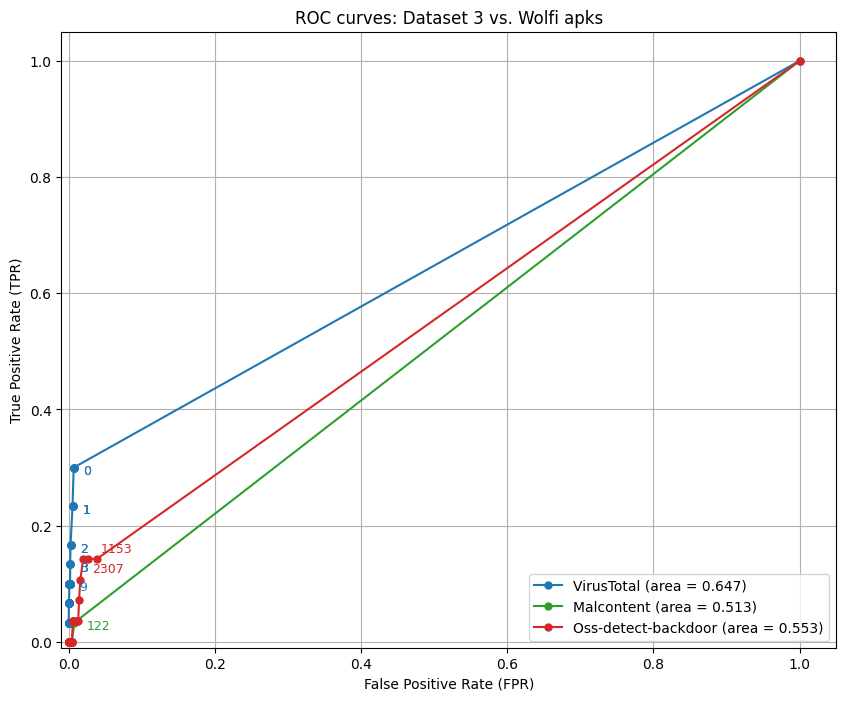

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc

# Define colors for each ROC curve
colors = {
    'VirusTotal': '#1f77b4',  # Blue
    'Packj': '#ff7f0e',       # Orange
    'Bincapz': '#2ca02c',     # Green
    'Oss-detect-backdoor': '#d62728',  # Red
    'Bandit4mal': '#9467bd'   # Purple
}

# Plot combined ROC curves
plt.figure(figsize=(10, 8))
SIZE = 300

# Plot ROC curve for VirusTotal
plt.plot(fpr_list_vt, tpr_list_vt, marker='o', markersize=5, color=colors['VirusTotal'], label='VirusTotal (area = {:.3f})'.format(round(auc(fpr_list_vt, tpr_list_vt), 3)))
for i, threshold in enumerate(thresholds_vt):
    if threshold != 0  and tpr_list_vt[i] > 0.1 and i % 2 == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_vt[i], tpr_list_vt[i]), textcoords="offset points", xytext=(10, -5), ha='center', fontsize=9, color=colors['VirusTotal'])
    elif threshold != 0  and i % 50 == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_vt[i], tpr_list_vt[i]), textcoords="offset points", xytext=(10, -5), ha='center', fontsize=9, color=colors['VirusTotal'])


# Plot ROC curve for Bincapz
plt.plot(fpr_list_bincapz, tpr_list_bincapz, marker='o', markersize=5, color=colors['Bincapz'], label='Malcontent (area = {:.3f})'.format(round(auc(fpr_list_bincapz, tpr_list_bincapz), 3)))
for i, threshold in enumerate(thresholds_bincapz):
    if threshold != 0  and fpr_list_bincapz[i] > 0.005:
        plt.annotate(f'{int(threshold)}', (fpr_list_bincapz[i], tpr_list_bincapz[i]), textcoords="offset points", xytext=(17,-5), ha='center', fontsize=9, color=colors['Bincapz'])
    elif threshold != 0  and i % 100 == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_bincapz[i], tpr_list_bincapz[i]), textcoords="offset points", xytext=(8, -13), ha='center', fontsize=9, color=colors['Bincapz'])

# Plot ROC curve for Oss-detect-backdoor
plt.plot(fpr_list_odb, tpr_list_odb, marker='o', markersize=5, color=colors['Oss-detect-backdoor'], label='Oss-detect-backdoor (area = {:.3f})'.format(round(auc(fpr_list_odb, tpr_list_odb), 3)))
for i, threshold in enumerate(thresholds_odb):
    if threshold != 0  and tpr_list_odb[i] > 0.05 and i % 2 == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_odb[i], tpr_list_odb[i]), textcoords="offset points", xytext=(20, 5), ha='center', fontsize=9, color=colors['Oss-detect-backdoor'])
    elif threshold != 0  and i % SIZE == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_odb[i], tpr_list_odb[i]), textcoords="offset points", xytext=(-10, 5), ha='center', fontsize=9, color=colors['Oss-detect-backdoor'])


# plt.plot([0, 1], [0, 1], 'k--')

plt.xlim(-0.01, 1.05)
plt.ylim(-0.01, 1.05)

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curves: Dataset 3 vs. Wolfi apks')
plt.legend(loc='lower right')
plt.grid(True)

# Save the combined plot as an image (e.g., PNG format)
plt.savefig('ROC_curves_Dataset_3_vs_Wolfi_apks.png', dpi=300, bbox_inches='tight')

# Show the combined plot
plt.show()


# Dataset5 and wolfi-apks

## VT

In [ ]:



vt_pd['Label'] = vt_pd.apply(label_package, axis=1)
df = vt_pd[vt_pd['Dataset'].isin(["dataset5", "wolfi-apks"])]

y_true = (df['Label'] == 'malicious').astype(int)
y_scores = df['#AVs']

# Create thresholds from 0 to max predicted value
thresholds_vt = np.linspace(0, y_scores.max(), 100)

tpr_list_vt = []
fpr_list_vt = []

# Calculate TPR and FPR for each threshold
for threshold in thresholds_vt:
    y_pred = (y_scores >= threshold).astype(int)  # Predictions based on threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate TPR and FPR
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

    tpr_list_vt.append(tpr)
    fpr_list_vt.append(fpr)

In [ ]:
df_dataset5_roc_vt = pd.DataFrame({
    'threshold': thresholds_vt,
    'tpr': tpr_list_vt,
    'fpr': fpr_list_vt
})
df_dataset5_roc_vt.to_csv('dataset5_roc_data_vt.csv', index=False)

## malcontent

In [ ]:

df = malicious_benign_pd_bincapz [malicious_benign_pd_bincapz['Dataset'].isin(["dataset5", 'wolfi-apks'])]
# Convert the labels to 1 (malicious) and 0 (benign)




# Convert labels to binary values (1 for 'malicious', 0 otherwise)
y_true = (df['Label'] == 'malicious').astype(int)
y_scores = df['Number of Alerts']

# Create thresholds from 0 to max predicted value
thresholds_bincapz = np.linspace(0, y_scores.max(), 100)

# Initialize lists to store TPR and FPR
tpr_list_bincapz = []
fpr_list_bincapz = []

# Calculate TPR and FPR for each threshold
for threshold in thresholds_bincapz:
    y_pred = (y_scores >= threshold).astype(int)  # Predictions based on threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate TPR and FPR
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

    tpr_list_bincapz.append(tpr)
    fpr_list_bincapz.append(fpr)

In [ ]:
df_dataset5_roc_bincapz = pd.DataFrame({
    'threshold': thresholds_bincapz,
    'tpr': tpr_list_bincapz,
    'fpr': fpr_list_bincapz
})
df_dataset5_roc_bincapz.to_csv('dataset5_roc_data_bincapz.csv', index=False)

## Oss-detect-backdoor

In [ ]:
df = malicious_benign_pd_odb[malicious_benign_pd_odb['Dataset'].isin(["dataset5", 'wolfi-apks'])]
# Convert labels to binary values (1 for 'malicious', 0 otherwise)
y_true = (df['Label'] == 'malicious').astype(int)
y_scores = df['Number of Alerts']

# Create thresholds from 0 to max predicted value
thresholds_odb = np.linspace(0, y_scores.max(), 100)

# Initialize lists to store TPR and FPR
tpr_list_odb = []
fpr_list_odb = []

# Calculate TPR and FPR for each threshold
for threshold in thresholds_odb:
    y_pred = (y_scores >= threshold).astype(int)  # Predictions based on threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate TPR and FPR
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

    tpr_list_odb.append(tpr)
    fpr_list_odb.append(fpr)

In [ ]:
df_dataset5_roc_odb = pd.DataFrame({
    'threshold': thresholds_odb,
    'tpr': tpr_list_odb,
    'fpr': fpr_list_odb
})
df_dataset5_roc_odb.to_csv('dataset5_roc_data_odb.csv', index=False)

## ROC curves

In [ ]:
auc_vt = round(auc(fpr_list_vt, tpr_list_vt), 2)
auc_bincapz = round(auc(fpr_list_bincapz, tpr_list_bincapz), 2)
auc_odb = round(auc(fpr_list_odb, tpr_list_odb), 2)
df_auc_data = pd.DataFrame({
    'tool': ['VirusTotal', 'Bincapz', 'Oss-detect-backdoor'],
    'auc': [auc_vt, auc_bincapz, auc_odb]
})
df_auc_data.to_csv('dataset5_auc_data.csv', index=False)

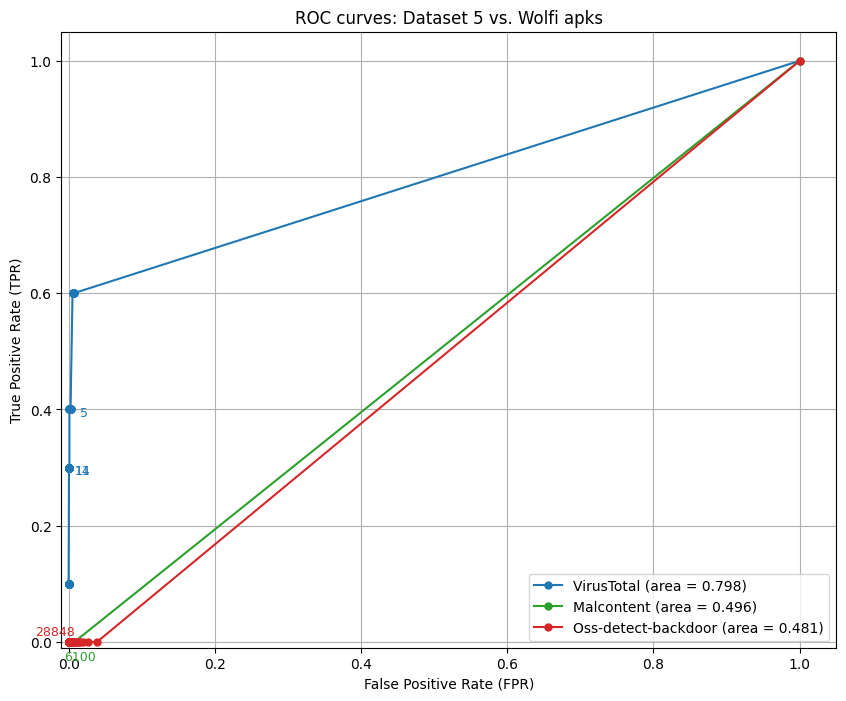

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc

# Define colors for each ROC curve
colors = {
    'VirusTotal': '#1f77b4',  # Blue
    'Packj': '#ff7f0e',       # Orange
    'Bincapz': '#2ca02c',     # Green
    'Oss-detect-backdoor': '#d62728',  # Red
    'Bandit4mal': '#9467bd'   # Purple
}

# Plot combined ROC curves
plt.figure(figsize=(10, 8))
SIZE = 300

# Plot ROC curve for VirusTotal
plt.plot(fpr_list_vt, tpr_list_vt, marker='o', markersize=5, color=colors['VirusTotal'], label='VirusTotal (area = {:.3f})'.format(round(auc(fpr_list_vt, tpr_list_vt), 3)))
for i, threshold in enumerate(thresholds_vt):
    if  threshold != 0  and tpr_list_vt[i] > 0.1 and i % 20 == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_vt[i], tpr_list_vt[i]), textcoords="offset points", xytext=(10, -5), ha='center', fontsize=9, color=colors['VirusTotal'])
    elif threshold != 0  and i % 50 == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_vt[i], tpr_list_vt[i]), textcoords="offset points", xytext=(10, -5), ha='center', fontsize=9, color=colors['VirusTotal'])


# Plot ROC curve for Bincapz
plt.plot(fpr_list_bincapz, tpr_list_bincapz, marker='o', markersize=5, color=colors['Bincapz'], label='Malcontent (area = {:.3f})'.format(round(auc(fpr_list_bincapz, tpr_list_bincapz), 3)))
for i, threshold in enumerate(thresholds_bincapz):
    if threshold != 0  and fpr_list_bincapz[i] > 0.2:
        plt.annotate(f'{int(threshold)}', (fpr_list_bincapz[i], tpr_list_bincapz[i]), textcoords="offset points", xytext=(8,5), ha='center', fontsize=9, color=colors['Bincapz'])
    elif threshold != 0  and i % 50 == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_bincapz[i], tpr_list_bincapz[i]), textcoords="offset points", xytext=(8, -13), ha='center', fontsize=9, color=colors['Bincapz'])

# Plot ROC curve for Oss-detect-backdoor
plt.plot(fpr_list_odb, tpr_list_odb, marker='o', markersize=5, color=colors['Oss-detect-backdoor'], label='Oss-detect-backdoor (area = {:.3f})'.format(round(auc(fpr_list_odb, tpr_list_odb), 3)))
for i, threshold in enumerate(thresholds_odb):
    if threshold != 0  and tpr_list_odb[i] > 0.05 and i % 2 == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_odb[i], tpr_list_odb[i]), textcoords="offset points", xytext=(20, 5), ha='center', fontsize=9, color=colors['Oss-detect-backdoor'])
    elif threshold != 0  and i % 50 == 0:
        plt.annotate(f'{int(threshold)}', (fpr_list_odb[i], tpr_list_odb[i]), textcoords="offset points", xytext=(-10, 5), ha='center', fontsize=9, color=colors['Oss-detect-backdoor'])


# plt.plot([0, 1], [0, 1], 'k--')

plt.xlim(-0.01, 1.05)
plt.ylim(-0.01, 1.05)

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curves: Dataset 5 vs. Wolfi apks')
plt.legend(loc='lower right')
plt.grid(True)

# Save the combined plot as an image (e.g., PNG format)
plt.savefig('ROC_curves_Dataset_5_vs_Wolfi_apks.png', dpi=300, bbox_inches='tight')

# Show the combined plot
plt.show()
